In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils
from utils.training_utils import train_model, test_model
from models.dense_convtranspose1d import DenseConvTranspose1D
import Simple_RCWA

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
pi = np.pi

# ================= Unit Define
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ================= Constant Define
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Visualize Target Spectra

freq_true.shape (1003,)
R_true.shape (201,)


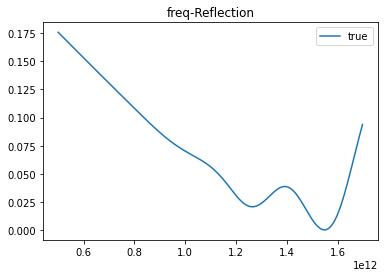

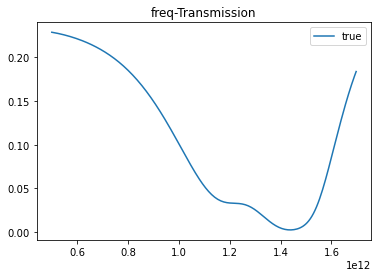

1098
(222,)
idx_freq_tg1 ORIG: 151
idx_freq_tg1: 166.77611940298507
R_tg1: 0.038314723405216806
T_tg1: 0.004280525157849011
T_tg2: 0.22840801357720697
--------
idx_freq_tg2 ORIG: 117
idx_freq_tg2: 129.22388059701493
R_tg2: 0.03066116289643781


In [4]:
path_true_R = './Simple_RCWA/data/R_absorber.txt'
R_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_R)
freq_true = R_file[:, 0] * 1e12
R_true = R_file[:, 1]
R_true = R_true**2
print('freq_true.shape', freq_true.shape)
# print(R_true)

path_true_T = './Simple_RCWA/data/T_absorber.txt'
T_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_T)
T_true = T_file[:, 1]
T_true = T_true**2

# truncate freq
freq_truncate = 1.7  # in THz
N_freq_stop = np.argmax(R_file[:,0]>freq_truncate)
freq_true = freq_true[:N_freq_stop]
R_true = R_true[:N_freq_stop]
T_true = T_true[:N_freq_stop]
freq_step = 4
freq_true, R_true, T_true = freq_true[::freq_step], R_true[::freq_step], T_true[::freq_step]
print('R_true.shape', R_true.shape)

plt.figure(1)
plt.plot(freq_true, R_true, label='true')
plt.title('freq-Reflection')
plt.legend()

plt.figure(2)
plt.plot(freq_true, T_true, label='true')
plt.title('freq-Transmission')
plt.legend()
plt.show()

# ================= Material Property Define
path_absorber = './Simple_RCWA/material_property/permittivity_absorber.txt'
eps_absorber_file = Simple_RCWA.utils.data_utils.load_property_txt(path_absorber)
print(eps_absorber_file.shape[0])
# truncate freq over 1.7THz
# freq_truncate = 1.7  # in THz
# freq_step = 4
if freq_truncate != 'none' and freq_truncate>eps_absorber_file[0,0] and freq_truncate<eps_absorber_file[-1,0]:
    N_freq_stop = np.argmax(eps_absorber_file[:,0]>freq_truncate)
    eps_absorber_file = eps_absorber_file[:N_freq_stop]
eps_absorber_file = eps_absorber_file[::freq_step]  # solve rcwa with a step size
eps_absorber = eps_absorber_file[:,1] + eps_absorber_file[:,2]*1j

freq = eps_absorber_file[:,0]*1e12
print(freq.shape)


# ================== Get Target Spectra Value
# print(freq_true)
idx_freq_tg1 = np.min(np.argwhere(freq_true>=1.4*1e12))
print('idx_freq_tg1 ORIG:', idx_freq_tg1)
R_tg1 = R_true[idx_freq_tg1]
T_tg1 = T_true[idx_freq_tg1]
T_tg2 = T_true[0]

idx_freq_tg1 = idx_freq_tg1/201*222
print('idx_freq_tg1:', idx_freq_tg1)
print('R_tg1:', R_tg1)
print('T_tg1:', T_tg1)
print('T_tg2:', T_tg2)


print('--------')
idx_freq_tg2 = np.min(np.argwhere(freq_true>=1.2*1e12))
print('idx_freq_tg2 ORIG:', idx_freq_tg2)
R_tg2 = R_true[idx_freq_tg2]

idx_freq_tg2 = idx_freq_tg2/201*222
print('idx_freq_tg2:', idx_freq_tg2)
print('R_tg2:', R_tg2)

# Looping to generate data and training

In [5]:
def visualize_trained_net(dataloader_test, size_fig=(21,12)):
    for idx, data in enumerate(dataloader_test):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        y_pred = net_dense(X)  # [N_eg,2,N_freq]

        y_np = y.cpu().detach().numpy()
        y_pred_np = y_pred.cpu().detach().numpy()
        if idx==0:
            y_test_np = y_np
            y_test_pred_np = y_pred_np
        else:
            y_test_np = np.concatenate((y_test_np,y_np), axis=0)
            y_test_pred_np = np.concatenate((y_test_pred_np,y_pred_np), axis=0)
            
        if y_test_pred_np.shape[0]>=4:
            break
    print('y_test_np.shape:', y_test_np.shape)
    print('y_test_pred_np.shape:', y_test_pred_np.shape)

    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Training result on test set: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Training result on test set: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))
    plt.show()
    
    
def visualize_spectra_search(params_pick, R_pick, T_pick, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra search result: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra search result: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()
    
    
def visualize_learned_and_rcwa(param_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra of learned network and RCWA: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(R_simu.shape[1]), R_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra of learned network and RCWA: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(T_simu.shape[1]), T_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()

**************************** ROUND 1 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 200
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [77. 73.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [149.  93.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [104. 131.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 91. 132.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 64. 103.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [105.  95.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [128.  75.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [103. 123.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [104.  75.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [82. 76.]
Calculation Progress: 100%
---

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 81. 120.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [137. 101.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [135. 121.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [107. 145.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [132. 114.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [137. 149.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [83. 98.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [120.  91.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [67. 54.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [137. 141.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [103.  76.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 79. 107.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.001910173129508621
### TEST LOSS  0.0004922486744665852
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.0006517025801804266
### TEST LOSS  0.0005100154279110333
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 0.0002988467138584383
### TEST LOSS  0.0002859465506238242
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 0.0006075962952127157
### TEST LOSS  0.00035009241158453125
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 0.000262634465825613
### TEST LOSS  0.00020948456464490542
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 0.00035235897298662165
### TEST LOSS  0.00017908620551073304
----------------------------------------------------------------------
***

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.6828259196017824e-05
### TEST LOSS  1.7142053972444653e-05
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.5660517790934135e-05
### TEST LOSS  1.263204376300564e-05
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.9916885146358255e-05
### TEST LOSS  2.0871432449591037e-05
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.730374904980181e-05
### TEST LOSS  1.3331827328026217e-05
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.0421758595100528e-05
### TEST LOSS  1.1421814027319973e-05
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 8.900447618884754e-06
### TEST LOSS  6.008631316944957e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.2625468582427856e-06
### TEST LOSS  1.3605631465907209e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.6343193545509393e-06
### TEST LOSS  1.116771348582309e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.3959678389596774e-06
### TEST LOSS  1.4788870430493262e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.1581653804881853e-06
### TEST LOSS  1.2184783599877846e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 9.858758370739905e-07
### TEST LOSS  8.555238840320575e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.140028091057843e-06
### TEST LOSS  1.1061637981886936e-06
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 6.892777754785584e-07
### TEST LOSS  9.368607341760556e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 8.568675641384971e-07
### TEST LOSS  6.452997733200997e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.065487962165662e-07
### TEST LOSS  5.373471860063243e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.685370339136852e-07
### TEST LOSS  5.467905452860577e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.487010459466092e-07
### TEST LOSS  4.892479902688743e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 5.868762025329488e-07
### TEST LOSS  5.818787371936196e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 6.182091060225048e-07
### TEST LOSS  1.1182430246966153e-06
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 6.112899208332578e-07
### TEST LOSS  3.956922114412009e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 4.869501917781349e-07
### TEST LOSS  6.47189513832321e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.329636932633775e-07
### TEST LOSS  3.5938345869605354e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.381392635290695e-07
### TEST LOSS  3.9716138644507737e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.182779434775852e-07
### TEST LOSS  3.8095850148541405e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 3.3710249601526244e-07
### TEST LOSS  2.628504821207874e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.50864322054656e-07
### TEST LOSS  3.3620768628376635e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 3.501449829457215e-07
### TEST LOSS  3.053270252924752e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 3.9960493680268883e-07
### TEST LOSS  6.163882820449847e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 3.8900571738054166e-07
### TEST LOSS  3.0183652673561784e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 3.3726107719900254e-07
### TEST LOSS  2.3297345800680583e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 2.6942512942440544e-07
### TEST LOSS  2.1410335667345257e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.18611584755979e-07
### TEST LOSS  2.7028800294222793e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 3.2260010893736537e-07
### TEST LOSS  3.2572205554970424e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.0903318257790036e-07
### TEST LOSS  2.488542113117849e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.141540301143664e-07
### TEST LOSS  2.4843468319583434e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.138406057701104e-07
### TEST LOSS  2.710117901945826e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.092687332717503e-07
### TEST LOSS  2.964424652418529e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.643685084599781e-07
### TEST LOSS  3.2504981580435316e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.836208577036928e-07
### TEST LOSS  5.233190544610503e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 4.1593470317735637e-07
### TEST LOSS  4.804902573596337e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.6553527262460646e-07
### TEST LOSS  9.566903524197794e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.5170400707329464e-07
### TEST LOSS  2.2057903474130094e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 2.2158397600335888e-07
### TEST LOSS  1.8280296387729322e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.039349351574572e-07
### TEST LOSS  1.868694283757577e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 2.2248426454041237e-07
### TEST LOSS  2.2984498097381825e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 2.3946083068437927e-07
### TEST LOSS  2.2604435893451105e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 2.2876291128071102e-07
### TEST LOSS  1.3917057610039288e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 2.5261948747967723e-07
### TEST LOSS  3.0463861359445826e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 2.280653243857955e-07
### TEST LOSS  2.4042118222193193e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.3628420315068297e-07
### TEST LOSS  2.6969220812134154e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 2.1882691132901756e-07
### TEST LOSS  1.8382434063823894e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 2.7203505339912224e-07
### TEST LOSS  1.8868755091716594e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 2.6294959482697777e-07
### TEST LOSS  2.2491035167604423e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 2.264306862720389e-07
### TEST LOSS  9.049816185324744e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 2.606786121006621e-07
### TEST LOSS  2.0563095404213527e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 2.049968230899424e-07
### TEST LOSS  2.477525337477952e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 1.9924997573639303e-07
### TEST LOSS  1.7924825594188101e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 2.04128454406316e-07
### TEST LOSS  1.5239353956530977e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 2.204560403562539e-07
### TEST LOSS  2.101756138017663e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 2.494919656470529e-07
### TEST LOSS  1.7296054958630217e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.164397850241585e-07
### TEST LOSS  2.5798819554741687e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 2.313050232061187e-07
### TEST LOSS  2.669313895845941e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 2.4087871731026666e-07
### TEST LOSS  2.5528247723135184e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.610344125919539e-07
### TEST LOSS  1.8555968021397953e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 1.8536002006186435e-07
### TEST LOSS  1.2707386076726834e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 1.5883634773672384e-07
### TEST LOSS  5.962351868523305e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 2.0838580114812543e-07
### TEST LOSS  1.4180810126163124e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 1.8044166422370722e-07
### TEST LOSS  1.556080633235979e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 1.977347744386293e-07
### TEST LOSS  1.828455869675357e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 2.108017270341378e-07
### TEST LOSS  1.1935798956604535e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 1.6981027133766702e-07
### TEST LOSS  1.6430210318200503e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.571218598212965e-07
### TEST LOSS  1.4555385992783462e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 1.6626470537239867e-07
### TEST LOSS  1.7383282605957598e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 1.7053347862727718e-07
### TEST LOSS  1.0969127117732569e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 1.736730914458917e-07
### TEST LOSS  1.600322671417113e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 1.6658914911982236e-07
### TEST LOSS  1.322046803882889e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.2581838331703353e-07
### TEST LOSS  1.3797099048436698e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 2.2899746586091395e-07
### TEST LOSS  1.5639325567917695e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 1.6001745471783126e-07
### TEST LOSS  1.314253073777157e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 1.7744783249895592e-07
### TEST LOSS  1.6467638393654246e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 1.9173442241005035e-07
### TEST LOSS  1.6192755462422306e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 1.658542379168182e-07
### TEST LOSS  1.3082861016755487e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 1.5097289951526704e-07
### TEST LOSS  2.3422628695849804e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.3745043455036806e-07
### TEST LOSS  2.415524467854387e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 1.6383668022257325e-07
### TEST LOSS  1.6622625764739496e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 1.5047090263564654e-07
### TEST LOSS  1.441638441216734e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 1.830930637325423e-07
### TEST LOSS  6.162566137390968e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 2.509902287872734e-07
### TEST LOSS  3.66338885745184e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 2.3568609549329268e-07
### TEST LOSS  3.051240942871421e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 2.1442497072143851e-07
### TEST LOSS  2.1441176064248188e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.1781611072135832e-07
### TEST LOSS  2.9151194288109156e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 1.7248708932271485e-07
### TEST LOSS  2.0966151718463758e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.834539301588279e-07
### TEST LOSS  1.598538214390525e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 2.3412028101077455e-07
### TEST LOSS  1.2452947117935764e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 1.8115925598749527e-07
### TEST LOSS  3.1819754061264877e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.0917111346108186e-07
### TEST LOSS  1.470479323491721e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 1.4123629301643348e-07
### TEST LOSS  1.6544812334965778e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 1.7674877598850002e-07
### TEST LOSS  2.632537056494281e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.506951708802774e-07
### TEST LOSS  1.529631532548592e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 1.6758124758098346e-07
### TEST LOSS  1.1068681260439917e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 1.5091340374695505e-07
### TEST LOSS  1.0662601350001448e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 1.517945296747314e-07
### TEST LOSS  9.640990109952934e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.1692282580865197e-07
### TEST LOSS  1.5435265747025065e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 2.976403784238357e-07
### TEST LOSS  1.2297874481722223e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 1.5754128147804635e-07
### TEST LOSS  1.0042189539187045e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.235444888716188e-07
### TEST LOSS  2.6635537153651967e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.2738233674601815e-07
### TEST LOSS  2.1306205155724456e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 1.499961345352574e-07
### TEST LOSS  2.0846166629932364e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 1.5131355865172225e-07
### TEST LOSS  8.257357346034648e-08
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 1.0671642942661208e-07
### TEST LOSS  1.0271093486835525e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 1.1932320154173226e-07
### TEST LOSS  1.2439396120574506e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 1.2517589922378392e-07
### TEST LOSS  1.6414214580133071e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 1.9562539690376469e-07
### TEST LOSS  1.5257677432600758e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 1.2740411699851962e-07
### TEST LOSS  7.327652914076073e-08
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 1.6411561248652618e-07
### TEST LOSS  1.672997171908719e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 1.2758316914940337e-07
### TEST LOSS  1.581342038055785e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 1.2813684617363207e-07
### TEST LOSS  1.511972129719652e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 1.4821624089833562e-07
### TEST LOSS  3.0825750248671585e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 1.661412160114395e-07
### TEST LOSS  9.46512225633948e-08
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 1.252143341012868e-07
### TEST LOSS  1.1545095901510649e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 1.414167007052214e-07
### TEST LOSS  9.120248734006964e-08
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 1.1940371734020515e-07
### TEST LOSS  8.612199072407141e-08
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 1.4834167219035522e-07
### TEST LOSS  3.137558337584778e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 1.4885567834355129e-07
### TEST LOSS  8.387049869421996e-08
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 1.2130960716394412e-07
### TEST LOSS  1.0787525894784267e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 1.6481234596632532e-07
### TEST LOSS  1.0777342159447774e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 1.3641427871746713e-07
### TEST LOSS  7.921898278103375e-08
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 1.0473432981328302e-07
### TEST LOSS  9.117110740438268e-08
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 1.1643508273095904e-07
### TEST LOSS  2.814698045009815e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 1.7365214963760422e-07
### TEST LOSS  9.605341470357114e-08
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 1.235925556919426e-07
### TEST LOSS  6.6278211363624e-08
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 1.603921446058365e-07
### TEST LOSS  2.3352279754362826e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.2616771414796232e-07
### TEST LOSS  2.3622379311897626e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 1.3698277364859735e-07
### TEST LOSS  1.2433589328490294e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 1.172783679592726e-07
### TEST LOSS  9.106715500214098e-08
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 1.0247865147583469e-07
### TEST LOSS  9.262379071136213e-08
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 1.1945146458636202e-07
### TEST LOSS  1.6583689917600472e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 1.2110635380757628e-07
### TEST LOSS  1.471302321457794e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 1.7284132292516574e-07
### TEST LOSS  1.4531440702588347e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 1.2213374916747455e-07
### TEST LOSS  1.1022255582323244e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 9.905299255486e-08
### TEST LOSS  7.603909798111393e-08
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 1.7178175537146956e-07
### TEST LOSS  2.426120175869073e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 1.5094255722658545e-07
### TEST LOSS  1.3486813088547933e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 4.632529334536173e-07
### TEST LOSS  1.8995447703673563e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 1.1313348688979374e-07
### TEST LOSS  8.904511380099696e-08
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 1.459928095126628e-07
### TEST LOSS  7.014413228034755e-08
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 1.3469167146951123e-07
### TEST LOSS  1.0040209967125217e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 4.474807190213426e-07
### TEST LOSS  1.6332122735699764e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.45301188783742e-07
### TEST LOSS  3.484761729547851e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 1.384867137321777e-07
### TEST LOSS  9.530398870083445e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 1.6807613667957355e-07
### TEST LOSS  1.14696708427194e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 1.3409232497263445e-07
### TEST LOSS  1.0267925176776771e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 1.2102944732639287e-07
### TEST LOSS  8.935530360076882e-08
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 1.2864756379293852e-07
### TEST LOSS  7.119068475465913e-08
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 1.08792101869426e-07
### TEST LOSS  6.475624303448058e-08
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 1.1786352667186862e-07
### TEST LOSS  8.470326425443393e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 8.84839409920346e-08
### TEST LOSS  8.105218777624638e-08
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 1.3477673189932203e-07
### TEST LOSS  1.1375755330315467e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 1.6983210096910284e-07
### TEST LOSS  3.9310372320263315e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 1.667871269717125e-07
### TEST LOSS  7.716266499831666e-08
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 9.583139514823813e-08
### TEST LOSS  2.556906745591429e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 9.756397907345616e-08
### TEST LOSS  8.313541618084248e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 1.0030917666270511e-07
### TEST LOSS  9.505171050250283e-08
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 9.741510193173042e-08
### TEST LOSS  7.771983234761137e-08
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 1.455147861051387e-07
### TEST LOSS  8.108419535801659e-08
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 1.0883835591002367e-07
### TEST LOSS  1.6811916244326616e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 1.607341202003454e-07
### TEST LOSS  7.917351515137246e-08
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 9.786458901928085e-08
### TEST LOSS  1.3929305472023165e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 1.365434346123351e-07
### TEST LOSS  9.70835808781582e-08
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 1.7189537630635242e-07
### TEST LOSS  3.398672419052673e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.422487003794771e-07
### TEST LOSS  4.705858221617139e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.3100387115171372e-07
### TEST LOSS  9.711945381241094e-08
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 1.0291493291347819e-07
### TEST LOSS  7.922391394761992e-08
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 1.4700968605563248e-07
### TEST LOSS  3.4102185964002274e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 1.5423188729712933e-07
### TEST LOSS  5.872189963914328e-08
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 1.0180268792403523e-07
### TEST LOSS  2.691344131259636e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 1.210304515453231e-07
### TEST LOSS  8.937148265886208e-08
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 9.342658533917359e-08
### TEST LOSS  8.088328939948042e-08
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 8.082001206943801e-08
### TEST LOSS  1.1482977176531979e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 1.0431096019836162e-07
### TEST LOSS  7.123815729907317e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 1.0134958047025577e-07
### TEST LOSS  6.536876876831836e-08
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 1.0746168190856054e-07
### TEST LOSS  1.4166374739943421e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 1.9172582192528152e-07
### TEST LOSS  1.1170369162982752e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 1.0526105342023583e-07
### TEST LOSS  8.085991254347391e-08
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 1.20373845966526e-07
### TEST LOSS  1.5344257064953126e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 1.79230467542979e-07
### TEST LOSS  8.937091659314926e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 1.1229608178453531e-07
### TEST LOSS  7.341100172197912e-08
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 1.3624399114675611e-07
### TEST LOSS  7.221852532287206e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 1.291843020911898e-07
### TEST LOSS  1.41236140412578e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 8.969337608188966e-08
### TEST LOSS  8.932584449894421e-08
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 1.209852999473071e-07
### TEST LOSS  1.0081265363245014e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 8.412242517685797e-08
### TEST LOSS  7.467059977746733e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 1.0709284864685031e-07
### TEST LOSS  8.522136596411656e-08
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 1.2144414080594856e-07
### TEST LOSS  9.16687644310817e-08
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 1.1229484950359136e-07
### TEST LOSS  1.1358942704949489e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 1.0678897262028642e-07
### TEST LOSS  6.060751545078347e-08
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 1.5762237844718641e-07
### TEST LOSS  8.334693527937513e-08
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 1.1451054070743538e-07
### TEST LOSS  1.1612353034706757e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 1.0610893612650329e-07
### TEST LOSS  4.592074394812092e-08
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 1.016726954361502e-07
### TEST LOSS  6.239555006004593e-08
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.729816534596807e-07
### TEST LOSS  4.718938271253137e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.7762995724600614e-07
### TEST LOSS  8.93475634219006e-08
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.7366389265814917e-07
### TEST LOSS  1.3278794834074384e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 1.2760759128482845e-07
### TEST LOSS  8.42785278602302e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 1.0615705061667314e-07
### TEST LOSS  1.2896235309275048e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 1.1211868991445329e-07
### TEST LOSS  1.4277214906618005e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 1.2220828123243878e-07
### TEST LOSS  2.0683357604411867e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 1.6788205871698382e-07
### TEST LOSS  2.0864288785560348e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 1.0823282710514803e-07
### TEST LOSS  7.254834481310961e-08
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 2.8444760364010335e-07
### TEST LOSS  5.057305448493329e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 9.935230053770283e-08
### TEST LOSS  1.3304831725236e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 1.2865075483148302e-07
### TEST LOSS  7.271935231756288e-08
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 1.344962788962789e-07
### TEST LOSS  1.4752649946103702e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 1.0340696134925054e-07
### TEST LOSS  8.68411499747405e-08
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 8.637038502179451e-08
### TEST LOSS  6.168061617017884e-08
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 9.585703157011239e-08
### TEST LOSS  6.764092338092571e-08
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 1.6470642841603933e-07
### TEST LOSS  1.5184450319338794e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 1.0573006630210102e-07
### TEST LOSS  7.340754137885597e-08
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 9.496358926330829e-08
### TEST LOSS  4.960131860798356e-08
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 1.2509771142532598e-07
### TEST LOSS  1.199383253454774e-06
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 2.732438617680799e-07
### TEST LOSS  1.3278784649628506e-07
----------------------------------------------------------------------
*** EPOCH 1951 || AVG LOSS 1.2762251217601772e-07
### TEST LOSS  1.238562248317976e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 1.1595579080925233e-07
### TEST LOSS  1.7170250051397792e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 1.1245351850597274e-07
### TEST LOSS  8.146037326165849e-08
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.939717954264509e-07
### TEST LOSS  2.421722153182297e-07
** loss_train 2.939717954264509e-07
** loss_test 2.421722153182297e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


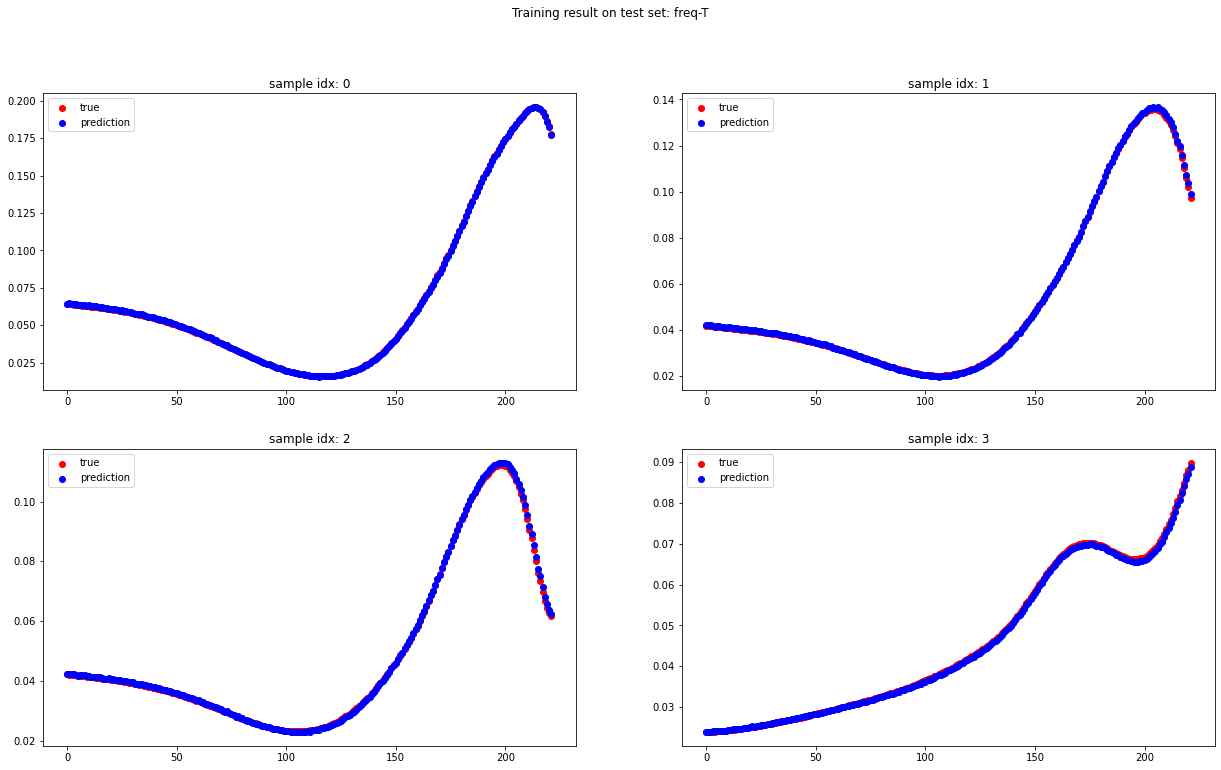

params_pick.shape: (10, 4)
params_pick: [[146. 118. 160.  75.]
 [146. 119. 160.  75.]
 [145. 121. 160.  75.]
 [146. 117. 160.  75.]
 [146. 120. 160.  75.]
 [145. 122. 160.  75.]
 [146. 116. 160.  75.]
 [145. 120. 160.  75.]
 [145. 123. 160.  75.]
 [147. 118. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


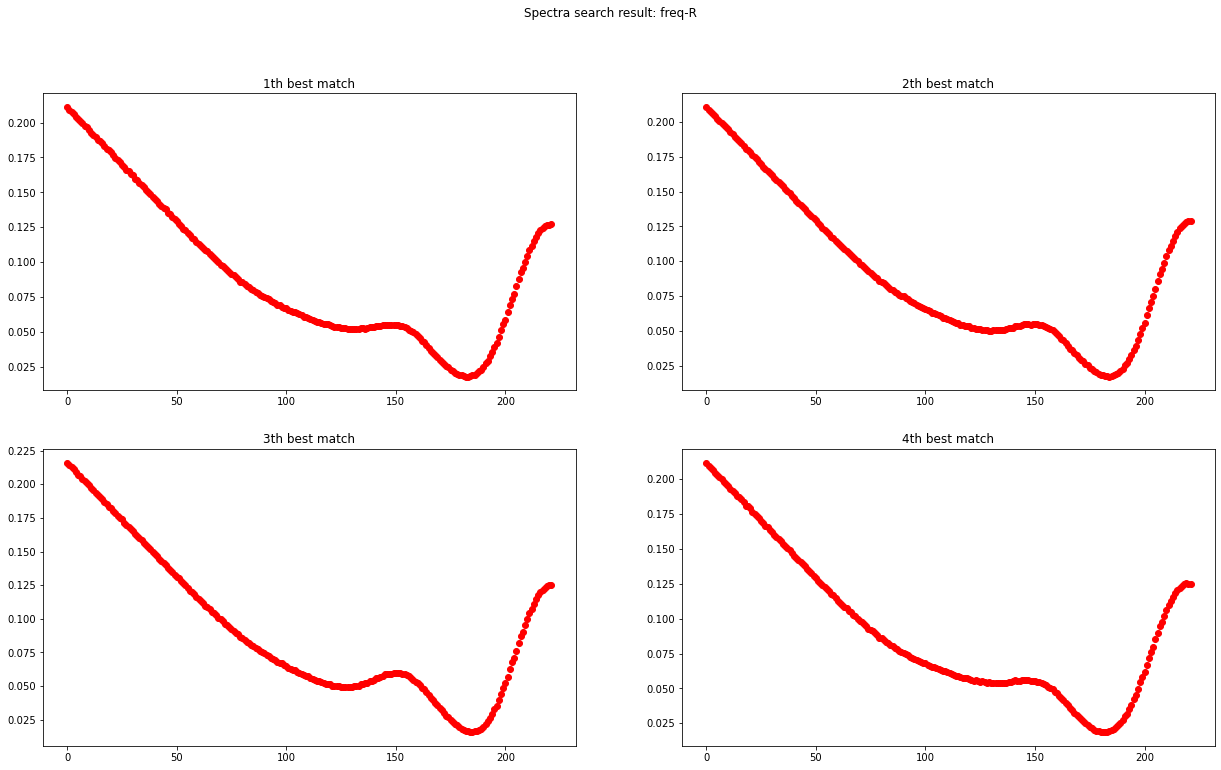

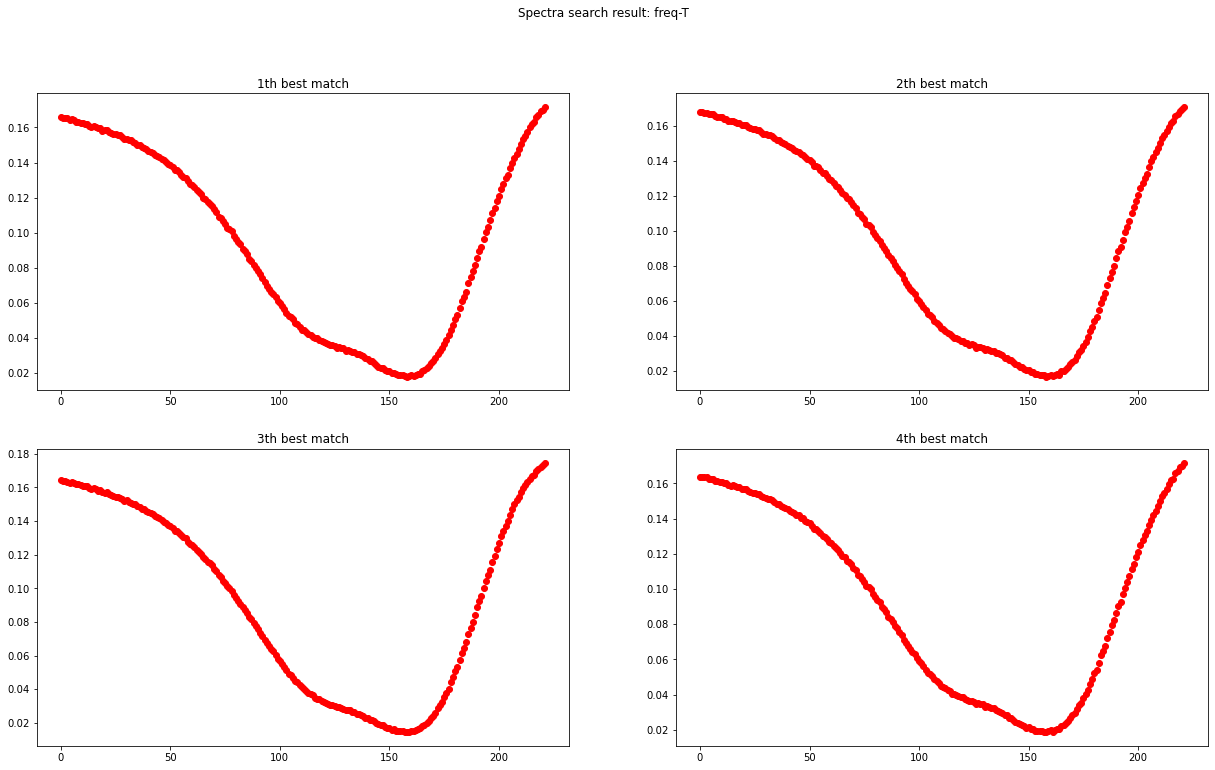

*** Reruning RCWA on picked params
params_dict.shape: (200, 4)
R_dict.shape: (200, 222)
T_dict.shape: (200, 222)
--------------------
1 th match
Not in the dict, calling RCWA...
# params_pick: [146. 118. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
2 th match
Not in the dict, calling RCWA...
# params_pick: [146. 119. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [145. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Not in the dict, calling RCWA...
# params_pick: [146. 117. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
5 th match
Not in the dict, calling RCWA...
# params_pick: [146. 120. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
6

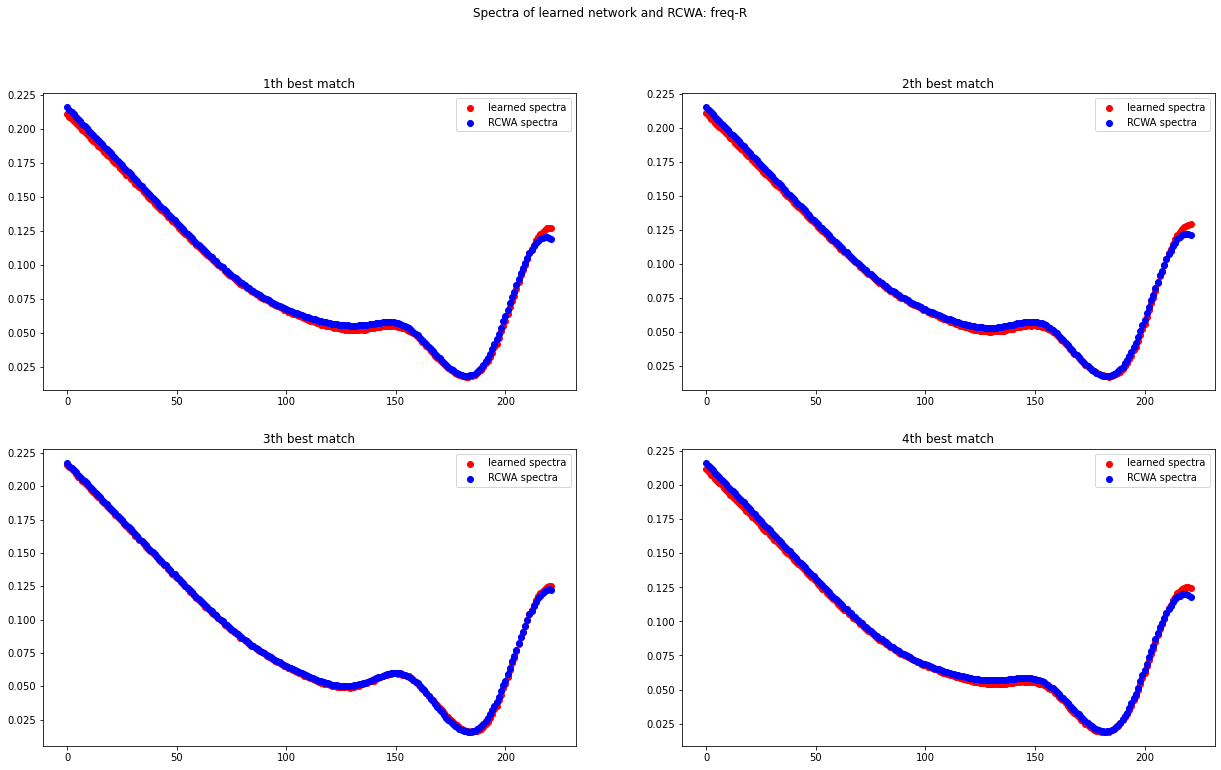

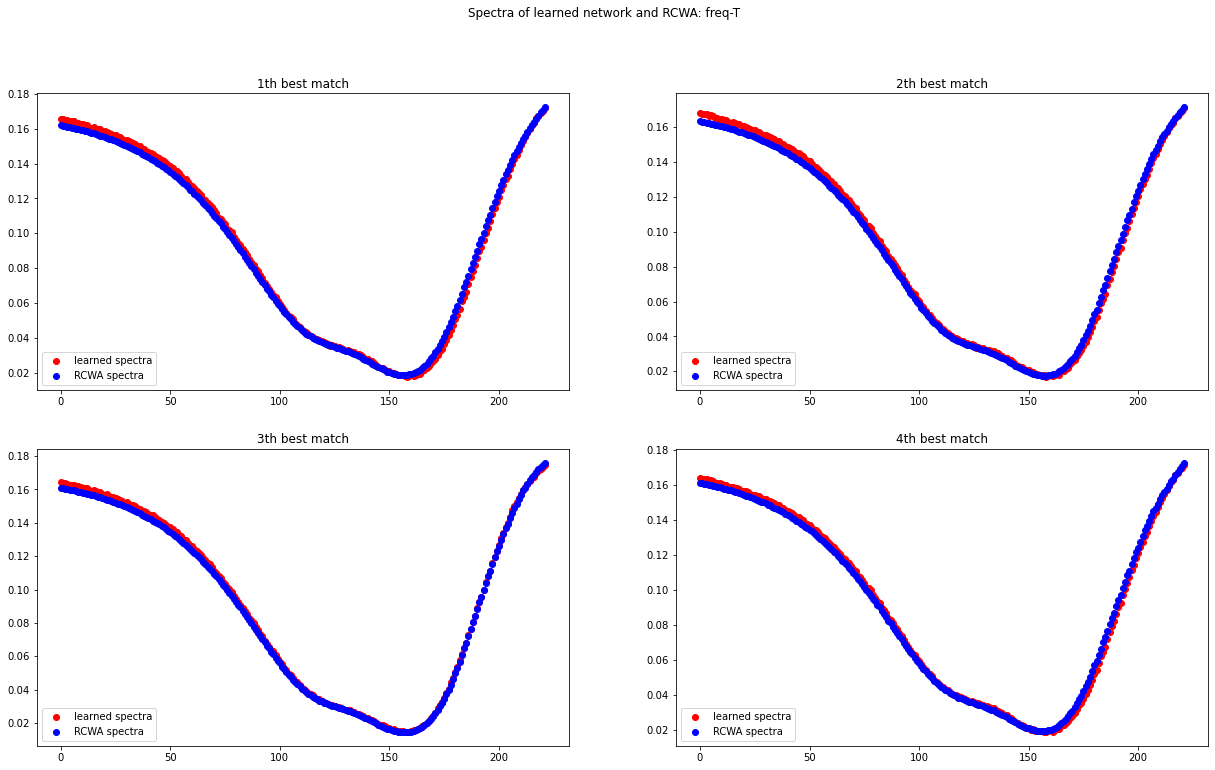

** Model saved.
**************************** ROUND 2 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 410
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [117.  96.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [127.  58.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [117. 115.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 72. 132.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [133. 123.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [95. 52.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [146. 101.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 83. 138.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [133. 147.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 50. 109.]
Calculation 

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [102. 109.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [131. 130.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [128. 139.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [96. 77.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [139. 106.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [102. 105.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [77. 94.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 91. 116.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [73. 92.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [119. 139.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [146. 112.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [70. 51.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00036798748393577135
### TEST LOSS  0.0005524262212150331
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.00016570676665118874
### TEST LOSS  0.00012222118363882015
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 9.907767488496065e-05
### TEST LOSS  0.00021223527645426138
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 0.00010801078662397474
### TEST LOSS  5.2527560390964414e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 8.712624836090715e-05
### TEST LOSS  8.064218958939559e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 6.862206687179512e-05
### TEST LOSS  6.783592717900839e-05
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 5.12563085896168e-06
### TEST LOSS  7.520877456304983e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 4.340873576879636e-06
### TEST LOSS  3.7310207322402026e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 2.79746604863293e-06
### TEST LOSS  1.9528528127921163e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 2.5447605509043568e-06
### TEST LOSS  2.3594790101404735e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.3304667181269996e-06
### TEST LOSS  2.4156035384034373e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.1326080780180769e-05
### TEST LOSS  3.338729285522797e-05
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.2093544970521567e-06
### TEST LOSS  1.0636809000581188e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.2460347160400743e-06
### TEST LOSS  1.1008507223258285e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.137715028918836e-06
### TEST LOSS  8.340351281991129e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.5961639785986357e-06
### TEST LOSS  1.2211925114310622e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.6050861604775846e-06
### TEST LOSS  1.1228280121550988e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 3.2023748401889504e-06
### TEST LOSS  1.6510909160518037e-06
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 7.499756534218982e-07
### TEST LOSS  1.3665770016554494e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 7.713200670774013e-07
### TEST LOSS  1.066542121666966e-06
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.969910180141906e-07
### TEST LOSS  1.3997843097968143e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 8.851254145408747e-07
### TEST LOSS  7.260827601385245e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.1042764519513141e-06
### TEST LOSS  7.627964220903647e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.635504327409519e-07
### TEST LOSS  7.353080247542363e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 1.264316473563623e-06
### TEST LOSS  1.077307550596223e-06
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 6.90381573845088e-07
### TEST LOSS  7.309295629706217e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.101975396727706e-07
### TEST LOSS  5.356614118617082e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.505840233975361e-07
### TEST LOSS  6.475392118383232e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.856124373274082e-07
### TEST LOSS  1.1416565257604816e-06
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 8.18739724212769e-07
### TEST LOSS  8.741974478912848e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.7442996829988993e-07
### TEST LOSS  3.352302237707201e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 7.912985201719826e-07
### TEST LOSS  4.4639795809026897e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.167941215476519e-07
### TEST LOSS  3.7386072295118667e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.763461302876749e-07
### TEST LOSS  5.34995036462403e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.532261060111379e-07
### TEST LOSS  3.3690072801359096e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 6.923825247687402e-07
### TEST LOSS  4.160602112993469e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.8768461552802075e-07
### TEST LOSS  3.073707302649252e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.4314818242280747e-07
### TEST LOSS  5.71189397240752e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.5554001487619466e-07
### TEST LOSS  7.227847049762204e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.145430899437165e-07
### TEST LOSS  6.784621819276384e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.480975028386416e-07
### TEST LOSS  4.5030204124226915e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.6263775381478854e-07
### TEST LOSS  1.1011963790354327e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.840043593749742e-07
### TEST LOSS  4.261447616370008e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 9.735128351971204e-07
### TEST LOSS  1.9991958067423965e-06
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.766013564584959e-07
### TEST LOSS  4.1849524937528517e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.669810198121512e-07
### TEST LOSS  2.9715142042212914e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.22369745500535e-07
### TEST LOSS  7.914392199381837e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.9654441482223484e-07
### TEST LOSS  4.155894097428765e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.857156584374257e-07
### TEST LOSS  2.868763207938433e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.0906585753321106e-07
### TEST LOSS  2.5436868814462545e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.8696310813002016e-07
### TEST LOSS  4.349846603547901e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 5.809537787769852e-07
### TEST LOSS  5.142184055070434e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.615307227994219e-07
### TEST LOSS  2.93414700536232e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.822563835632863e-07
### TEST LOSS  3.931146303719808e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.779042854949089e-07
### TEST LOSS  2.575170157115281e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.10104331653896e-07
### TEST LOSS  2.9390279061252453e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.4463524728105147e-07
### TEST LOSS  2.145843142540928e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 5.354047251554392e-07
### TEST LOSS  5.827824744691108e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.0119553852738445e-07
### TEST LOSS  1.8713269460996734e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 5.33703343087146e-07
### TEST LOSS  3.5339028110164303e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.97389906943975e-07
### TEST LOSS  7.748279894518159e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 6.381783219298108e-07
### TEST LOSS  2.931585762715778e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.4842538902415617e-07
### TEST LOSS  2.8759355684217424e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.947325958693721e-07
### TEST LOSS  2.6344337657389717e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.1451730701788987e-07
### TEST LOSS  4.172139702924531e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.6762203619132047e-07
### TEST LOSS  5.294535217866983e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.124262172505263e-07
### TEST LOSS  1.5165157459965225e-06
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.869447507558628e-07
### TEST LOSS  2.252724503445539e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 2.9203784088229986e-07
### TEST LOSS  2.774422499994346e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.0284919459376864e-07
### TEST LOSS  3.6491343889468097e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.720458121396926e-07
### TEST LOSS  2.1227935625185118e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 5.05335080412706e-07
### TEST LOSS  2.4096738115986227e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.9686407764419274e-07
### TEST LOSS  3.8800713956074364e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 2.4447900351103225e-07
### TEST LOSS  2.038189482586209e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.6828812310279607e-07
### TEST LOSS  2.1147288415639715e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 2.920734171505185e-07
### TEST LOSS  2.029190296428039e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.5756746373333667e-07
### TEST LOSS  2.2491150275527616e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.4889593694033795e-07
### TEST LOSS  2.0779095523591552e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.3094164465535136e-07
### TEST LOSS  1.7527183412572152e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.871908732463758e-07
### TEST LOSS  2.502733674906007e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.1359028780321395e-07
### TEST LOSS  2.542338393141108e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 2.634835639599526e-07
### TEST LOSS  1.7183849974701714e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.372825075188519e-07
### TEST LOSS  3.201793187404941e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.383313310119475e-07
### TEST LOSS  2.433322663364379e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.6934249558805177e-07
### TEST LOSS  5.481012814405923e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 2.700870577594221e-07
### TEST LOSS  3.902815949784001e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.1532148618569454e-07
### TEST LOSS  2.595010032889279e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 2.8308146156930654e-07
### TEST LOSS  1.5642680040173218e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.53750842940488e-07
### TEST LOSS  3.9682690758776775e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.943958242756655e-07
### TEST LOSS  2.4314708874888833e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 2.8518086978297607e-07
### TEST LOSS  5.275331196636606e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.8846910816364304e-07
### TEST LOSS  2.994119573226531e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 2.865955851522186e-07
### TEST LOSS  1.941547042503901e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 2.770280735085762e-07
### TEST LOSS  3.194938074102538e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.448001494511223e-07
### TEST LOSS  1.864775498461313e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.5341163921413417e-07
### TEST LOSS  2.8455472188073016e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.479323637104596e-07
### TEST LOSS  3.6209135600984155e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 2.2663801232256697e-07
### TEST LOSS  1.6992093167443401e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.3086542878823273e-07
### TEST LOSS  2.6635133565378055e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 2.615906943503887e-07
### TEST LOSS  2.999899412056298e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.0757571845235095e-07
### TEST LOSS  2.9825660468369666e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.6834188298281257e-07
### TEST LOSS  3.5219564763013166e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 4.975344189539217e-07
### TEST LOSS  2.2216506628020787e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.3660941412979964e-07
### TEST LOSS  1.719821410363563e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.52051344608825e-07
### TEST LOSS  2.0800095918665257e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 2.1240449318743065e-07
### TEST LOSS  1.7888075782528696e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.2359561765899632e-07
### TEST LOSS  3.012888458085529e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.8403483012738897e-07
### TEST LOSS  2.5991932415893514e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.431607683119842e-07
### TEST LOSS  1.5156650233296075e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 1.8611044864357841e-07
### TEST LOSS  1.737333619189485e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.022740638790033e-07
### TEST LOSS  2.444296488387668e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.110365727534913e-07
### TEST LOSS  1.860622508128732e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.2781859940648673e-07
### TEST LOSS  1.5602057195402657e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.5824210947000555e-07
### TEST LOSS  1.9301010313808676e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.0219969886621063e-07
### TEST LOSS  1.4510046396156084e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 1.9661168482555905e-07
### TEST LOSS  2.2159484355402777e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.535654680002608e-07
### TEST LOSS  1.8436719731848177e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.1094269386725467e-07
### TEST LOSS  1.7535143521334768e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.4004868686632347e-07
### TEST LOSS  3.150590726720891e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.1604486191367925e-07
### TEST LOSS  2.177347064551733e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.288872405647065e-07
### TEST LOSS  2.7849881080653306e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.688970152883515e-07
### TEST LOSS  3.3516287040973633e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.5427448088551986e-07
### TEST LOSS  2.1455669038264853e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.5842125527388795e-07
### TEST LOSS  1.547931509955041e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.7220311182743416e-07
### TEST LOSS  3.6507047898989444e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.667411533711815e-07
### TEST LOSS  3.6919727465699127e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.2069835118023414e-07
### TEST LOSS  3.185572390001263e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.3697285834219467e-07
### TEST LOSS  1.9252148929029188e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.129499446101097e-07
### TEST LOSS  6.390257648750516e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 4.5729212212247547e-07
### TEST LOSS  2.5902249132871346e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.500655132980516e-07
### TEST LOSS  1.5173809129821946e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.6597024446265626e-07
### TEST LOSS  1.7224555546947939e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.533209826620533e-07
### TEST LOSS  2.2028798493270836e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.60434552635775e-07
### TEST LOSS  1.1860948591545042e-06
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 5.449954833918083e-07
### TEST LOSS  2.2763747356943247e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.742234694192287e-07
### TEST LOSS  2.0386587453101258e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 1.9232792239893392e-07
### TEST LOSS  1.7377016904772192e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.3896518306788473e-07
### TEST LOSS  2.3067005981504606e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.650775413674709e-07
### TEST LOSS  1.542211021744931e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.162988597207481e-07
### TEST LOSS  1.3269003825858556e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 1.942429052855609e-07
### TEST LOSS  1.7503350388129286e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.02506074998263e-07
### TEST LOSS  1.8888309227804712e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.2059060137765787e-07
### TEST LOSS  3.23139525042799e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.4207168318854457e-07
### TEST LOSS  1.326121059313274e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.1574772577467938e-07
### TEST LOSS  1.6909079140045184e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.997946830752531e-07
### TEST LOSS  2.6445688255145275e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.2339429994960993e-07
### TEST LOSS  2.162853677743572e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 1.676962636483312e-07
### TEST LOSS  1.3043383465368867e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.0217098155367185e-07
### TEST LOSS  3.342306017982212e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.5099202614823266e-07
### TEST LOSS  1.3595678893807417e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 1.8430952174328718e-07
### TEST LOSS  1.6668053604007582e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 1.7394519722921724e-07
### TEST LOSS  1.3974633158600876e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.387584125290856e-07
### TEST LOSS  2.3585725322001444e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.1449132844704015e-07
### TEST LOSS  1.6206240717662824e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.0757588899560528e-07
### TEST LOSS  3.667543759482734e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 1.7955823151157385e-07
### TEST LOSS  1.692036306621958e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 1.711446418080455e-07
### TEST LOSS  1.6650690781716548e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.0084636461504256e-07
### TEST LOSS  2.3098318178784082e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 1.9232022755471412e-07
### TEST LOSS  1.928964609630514e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.2611885162547888e-07
### TEST LOSS  1.3204563081054793e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.0412094473213268e-07
### TEST LOSS  1.7617415437598538e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 1.851554856362621e-07
### TEST LOSS  3.9127090799086416e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.3454601715348268e-07
### TEST LOSS  2.2878341659244533e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.446657216381709e-07
### TEST LOSS  1.769812822008784e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.3760493849518232e-07
### TEST LOSS  1.771070848073058e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.0581436672013457e-07
### TEST LOSS  1.862340346698537e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.4214573952250946e-07
### TEST LOSS  2.576182782019844e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.086737716324402e-07
### TEST LOSS  2.1453562786583851e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.1242543752204416e-07
### TEST LOSS  1.6826044811425943e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 1.9073868699766126e-07
### TEST LOSS  1.2422769352886981e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 1.8152765532909697e-07
### TEST LOSS  1.2497410141674793e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.470149134212783e-07
### TEST LOSS  2.1490426758776137e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.2405502698475396e-07
### TEST LOSS  2.7921891135715017e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 1.9308704657058714e-07
### TEST LOSS  1.2281626534818964e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.2391729818836454e-07
### TEST LOSS  2.2653557810567042e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.0417716080241389e-07
### TEST LOSS  1.776224993120325e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 1.9478774110213203e-07
### TEST LOSS  1.2587322422470087e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.007215752134662e-07
### TEST LOSS  6.115617127631725e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.340848073340955e-07
### TEST LOSS  1.1824841448872445e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.47735094556602e-07
### TEST LOSS  1.367183455970787e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 1.6879347141037593e-07
### TEST LOSS  1.6827440520371185e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 1.9844314606946755e-07
### TEST LOSS  1.7157246442626013e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 1.6814349872548775e-07
### TEST LOSS  2.1287521942018168e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 1.778434966685681e-07
### TEST LOSS  2.1919965677495513e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.2235531329246714e-07
### TEST LOSS  5.958206697544353e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.006043568775123e-07
### TEST LOSS  1.3494431223242437e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 1.662503569347303e-07
### TEST LOSS  1.240034239101208e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 1.8681542414702652e-07
### TEST LOSS  1.0768461322641087e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.0683082042507948e-07
### TEST LOSS  2.1917524455667653e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 1.5778442424272183e-07
### TEST LOSS  1.468410084320177e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 1.5620675550668992e-07
### TEST LOSS  1.4008442000041604e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 1.957513990902271e-07
### TEST LOSS  4.729570832751051e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 1.5477480418602788e-07
### TEST LOSS  1.6661958974444652e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 1.4426403953497657e-07
### TEST LOSS  1.4264806225128268e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 1.809042261335665e-07
### TEST LOSS  1.2312425415724908e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 1.5015843652715774e-07
### TEST LOSS  1.547989236477016e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 1.597673766033004e-07
### TEST LOSS  2.458887767683596e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.1347712395212755e-07
### TEST LOSS  1.6122293443134238e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.4448097017634527e-07
### TEST LOSS  1.7449285394377512e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.1334269958672172e-07
### TEST LOSS  1.2684881462681525e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 1.446761786404758e-07
### TEST LOSS  1.1111952348739709e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.0204452604635974e-07
### TEST LOSS  2.1464242446914534e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.1285375199861307e-07
### TEST LOSS  1.1582149588613383e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 1.9709383810437908e-07
### TEST LOSS  1.9116583262400256e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.816458494068251e-07
### TEST LOSS  2.2620166971267152e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.7927891908029226e-07
### TEST LOSS  1.133816362702029e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 1.7192815970901165e-07
### TEST LOSS  1.2638755464422502e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 1.495764217525714e-07
### TEST LOSS  1.3951982578776422e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 1.5190957816752355e-07
### TEST LOSS  1.5452008231672414e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 1.5891498875410756e-07
### TEST LOSS  1.6521354646264236e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 1.8906234773080485e-07
### TEST LOSS  2.091830383830841e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.0170469987590424e-07
### TEST LOSS  1.0580576871786564e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 1.8026413121882485e-07
### TEST LOSS  6.457755554427942e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 1.8649392692468636e-07
### TEST LOSS  1.7081779495648724e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 1.5978012025658749e-07
### TEST LOSS  1.017509347889245e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 1.7241336482087267e-07
### TEST LOSS  2.587638679837515e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 1.725024126837231e-07
### TEST LOSS  2.057161064986498e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.173892696251231e-07
### TEST LOSS  2.568449234883831e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.571536877421916e-07
### TEST LOSS  9.42496752389031e-08
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 1.5241304756377842e-07
### TEST LOSS  1.4322760019272858e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 1.9648883558691817e-07
### TEST LOSS  1.1031686142359831e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.8479153494435275e-07
### TEST LOSS  1.561462283916626e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 1.661232760804895e-07
### TEST LOSS  2.3708941349858443e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.1249580280745827e-07
### TEST LOSS  1.3570430366728813e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 1.9178292026770428e-07
### TEST LOSS  1.8298221553842658e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 1.3551965361934556e-07
### TEST LOSS  1.2476646560344307e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 1.4551466470804576e-07
### TEST LOSS  9.027170883817754e-08
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 1.382835564386965e-07
### TEST LOSS  1.151950154313194e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 1.8603286701681872e-07
### TEST LOSS  1.3586457571688827e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 1.677775882019266e-07
### TEST LOSS  1.9644032939985274e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 1.6376244320278972e-07
### TEST LOSS  1.4814160514171298e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 1.907993070941377e-07
### TEST LOSS  2.1894564992765352e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 1.730570820521532e-07
### TEST LOSS  1.2226636921955754e-07
** loss_train 1.730570820521532e-07
** loss_test 1.2226636921955754e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


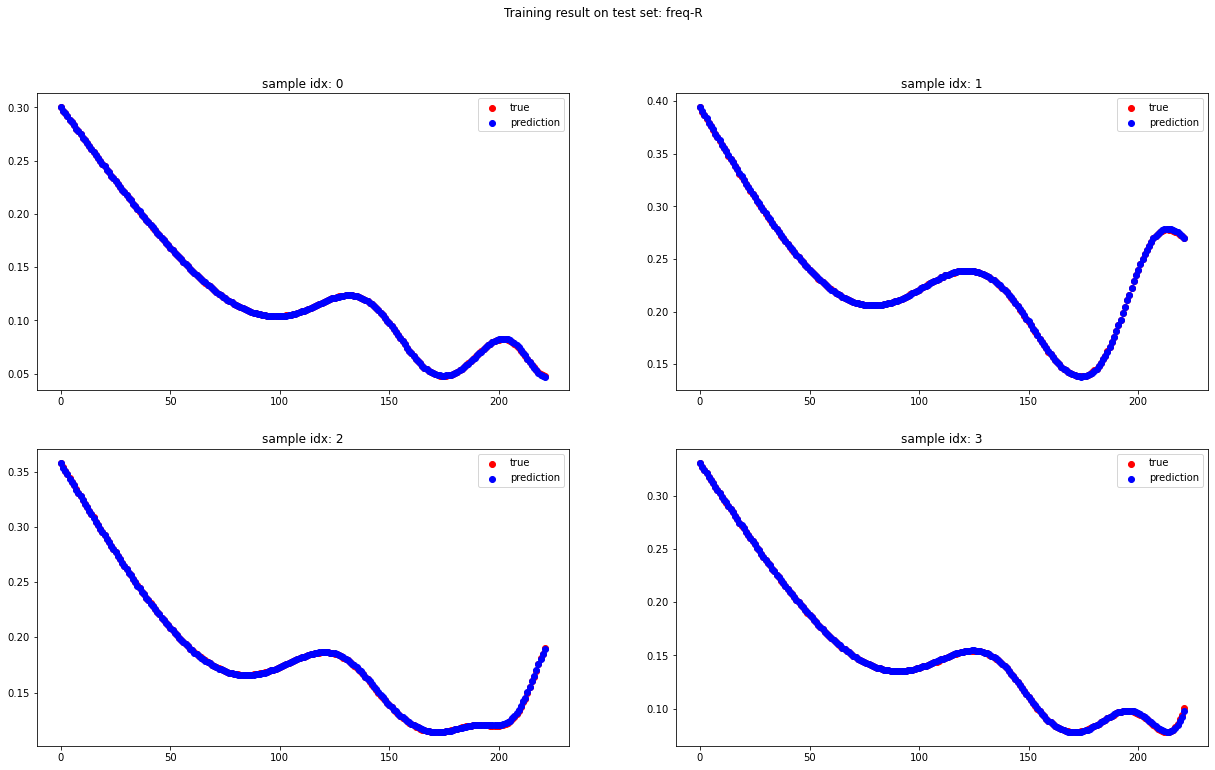

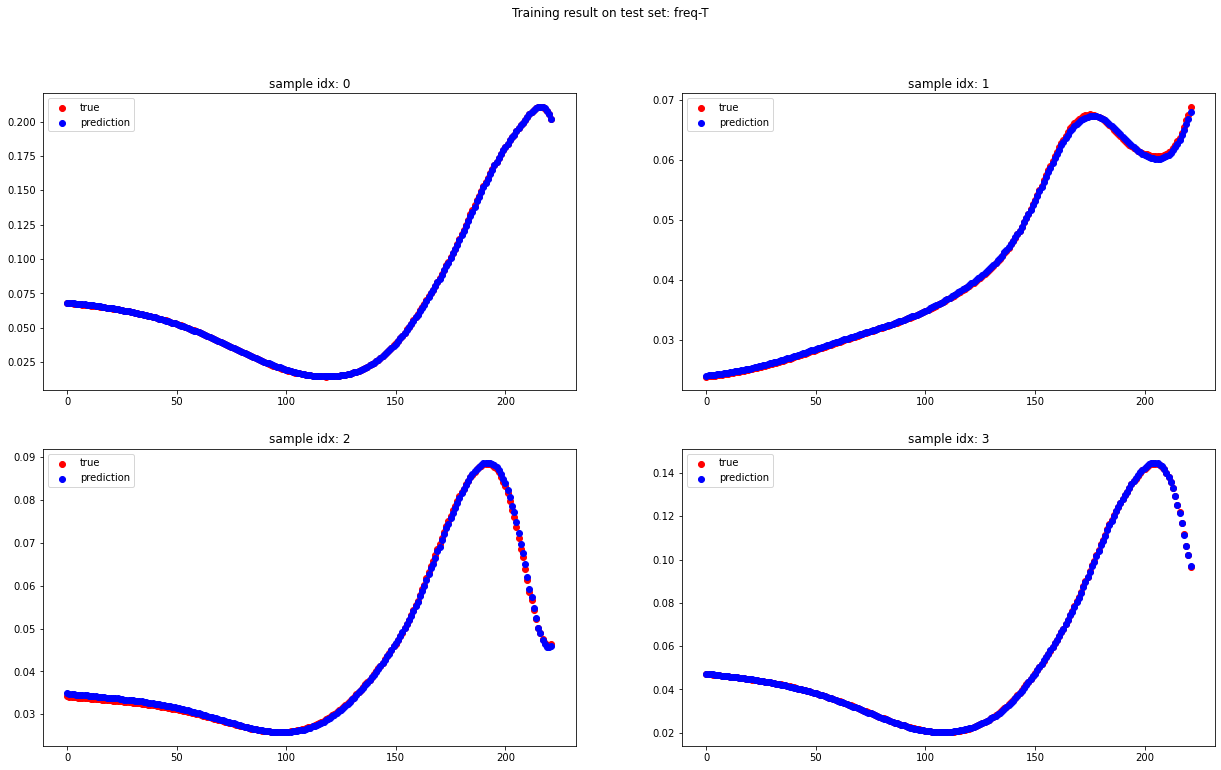

params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [146. 122. 160.  75.]
 [149. 122. 160.  75.]
 [146. 120. 160.  75.]
 [145. 121. 160.  75.]
 [148. 122. 160.  75.]
 [145. 122. 160.  75.]
 [148. 123. 160.  75.]
 [147. 121. 160.  75.]
 [145. 120. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


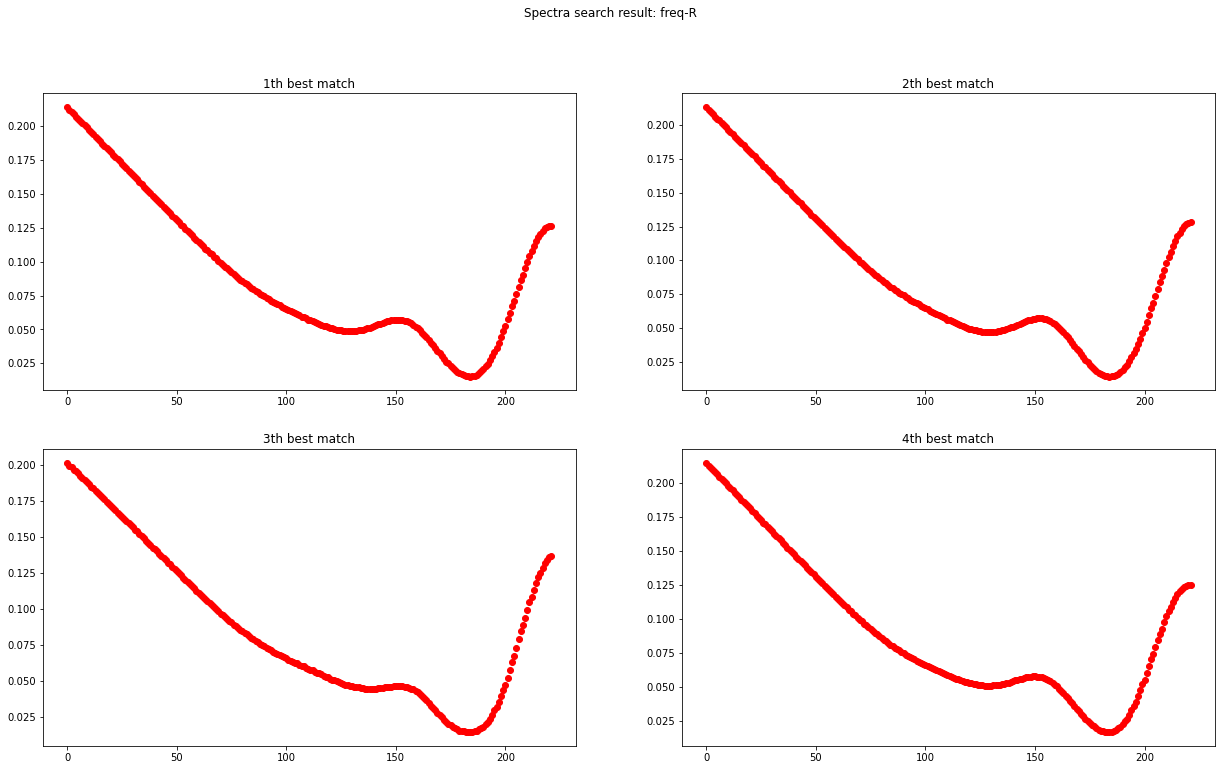

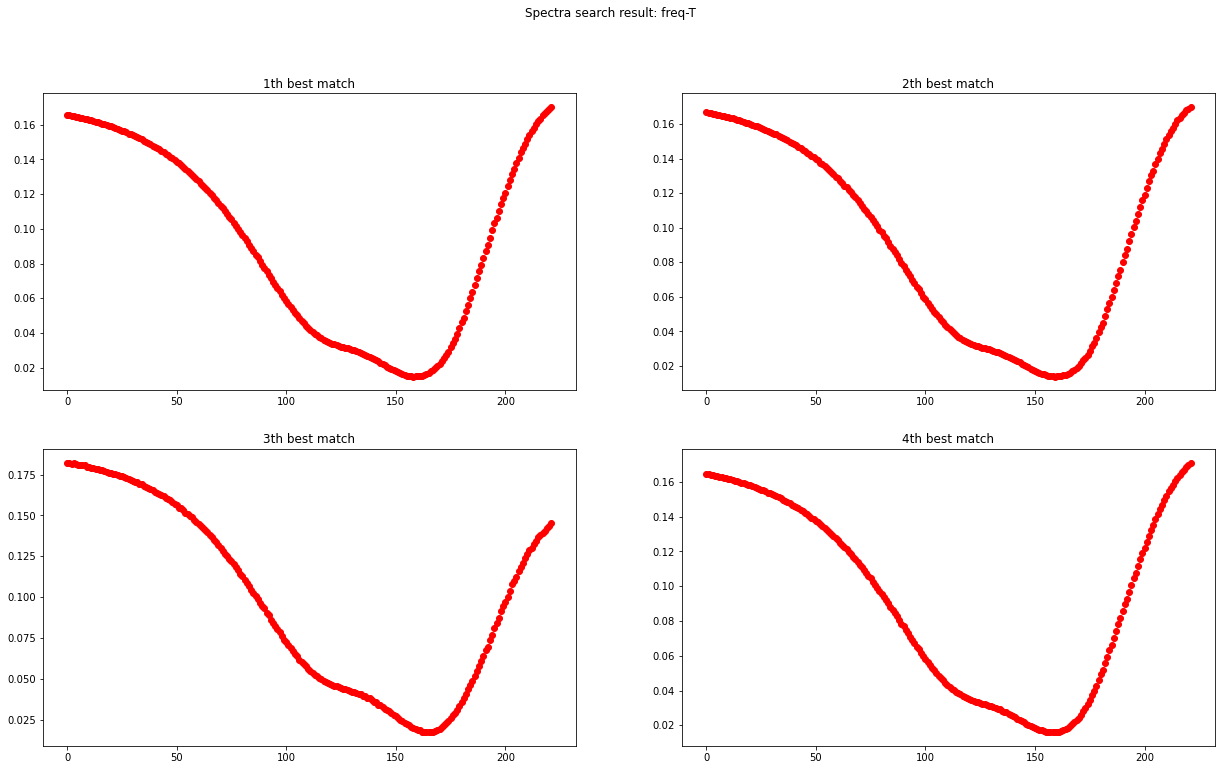

*** Reruning RCWA on picked params
params_dict.shape: (410, 4)
R_dict.shape: (410, 222)
T_dict.shape: (410, 222)
--------------------
1 th match
Not in the dict, calling RCWA...
# params_pick: [146. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
2 th match
Not in the dict, calling RCWA...
# params_pick: [146. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [149. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
6 th match
Not in the dict, calling RCWA...
# params_pick: [148. 122. 160.  75.]
Freq truncate.
f

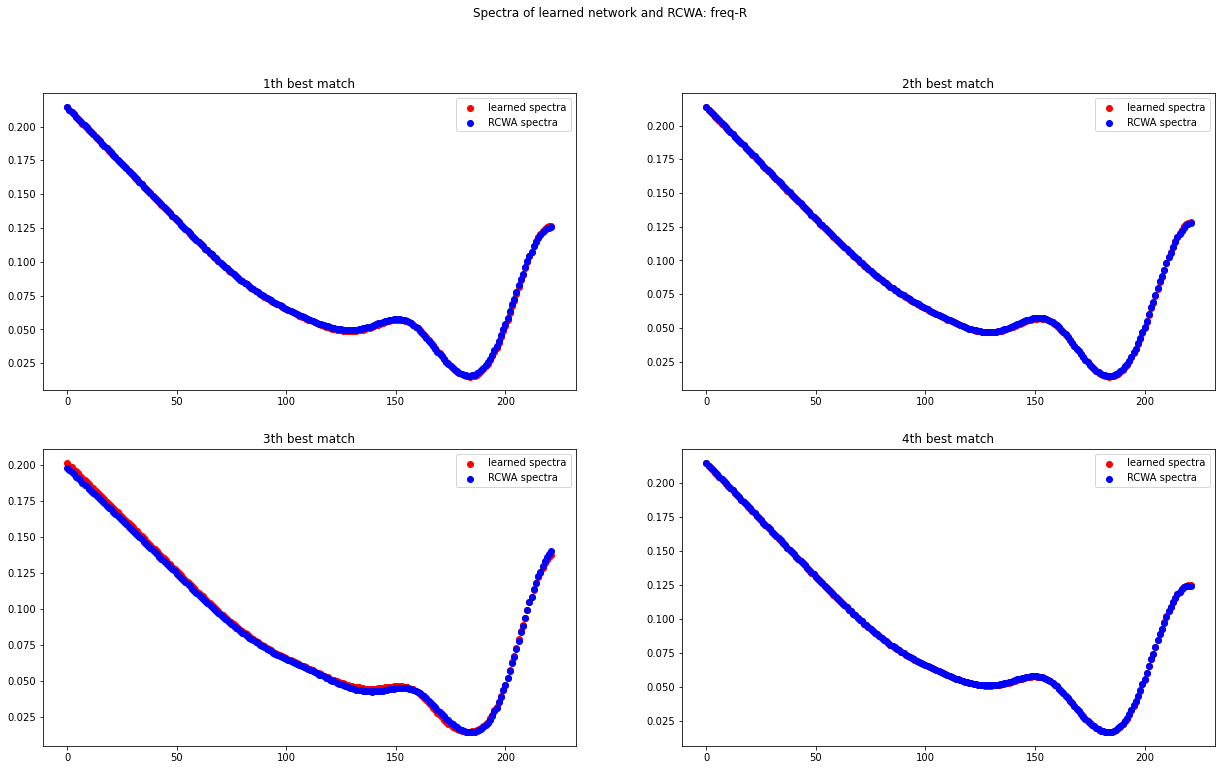

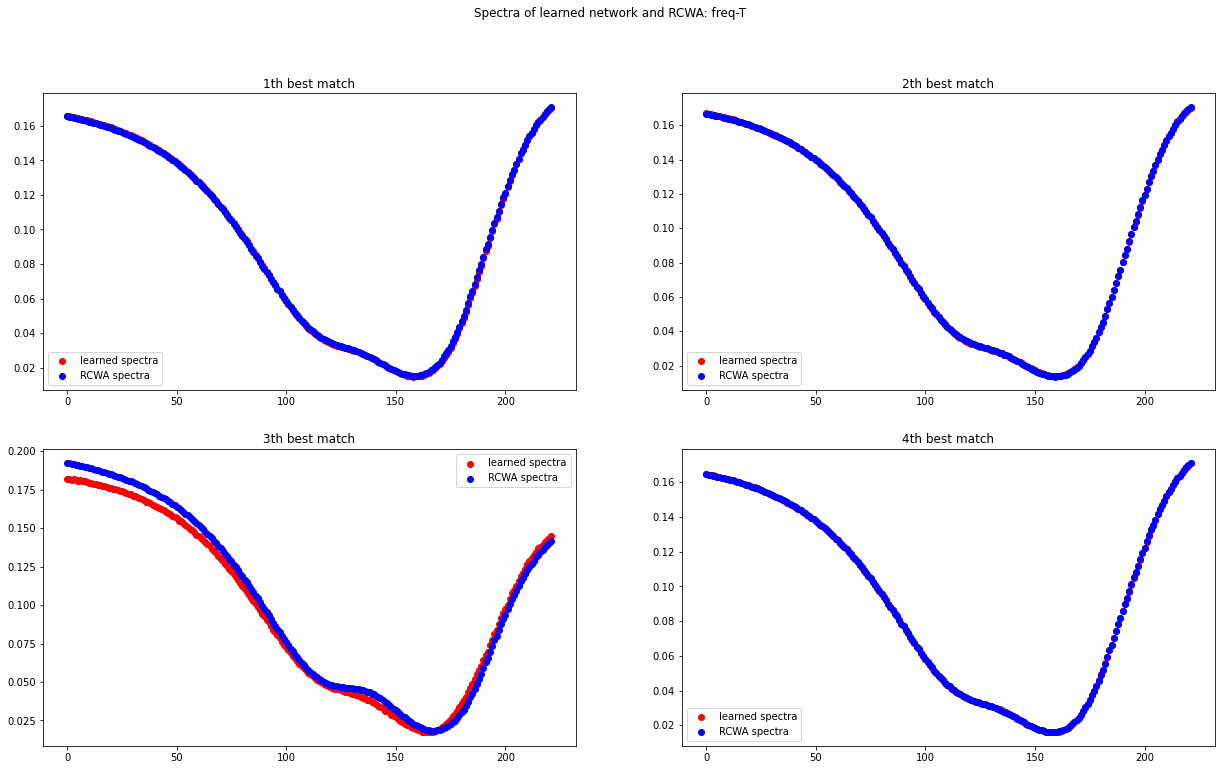

** Model saved.
**************************** ROUND 3 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 616
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [66. 69.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 63. 148.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [132. 119.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [135. 112.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 64. 138.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 57. 129.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [80. 84.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [118.  72.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [149. 123.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [68. 73.]
Calculation Prog

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [113. 124.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [142.  74.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 68. 131.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 89. 126.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [127. 145.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [147. 105.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 84. 146.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [149. 135.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [ 58. 141.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [131. 110.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 66. 149.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [80. 68.]
Calculation Progress: 100%
---

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00015982772027779322
### TEST LOSS  0.0002505369484424591
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 5.81942016317321e-05
### TEST LOSS  2.7755655355576892e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 3.191744869542316e-05
### TEST LOSS  1.9407608124311083e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 2.3413670846607246e-05
### TEST LOSS  2.457034388498869e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 3.4773952500195085e-05
### TEST LOSS  4.022769244329538e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 2.545446390616075e-05
### TEST LOSS  3.0028788751224055e-05
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 4.317926588772234e-06
### TEST LOSS  4.5788734496454705e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 4.033244208684267e-06
### TEST LOSS  2.6793554297910306e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 2.840244114104457e-06
### TEST LOSS  3.010983402873535e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 2.9929653240050762e-06
### TEST LOSS  2.1874538902011407e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.4583188159061304e-06
### TEST LOSS  2.6106529730896e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 2.6531690693101472e-06
### TEST LOSS  3.4130801395804154e-06
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 2.221354105610577e-06
### TEST LOSS  2.1910319333073857e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.92907324474008e-06
### TEST LOSS  1.03203455523726e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.7953771825766205e-06
### TEST LOSS  1.967883997622266e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.9837007084585627e-06
### TEST LOSS  1.008699797466761e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.5598789133679542e-06
### TEST LOSS  2.1482890701918222e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.3681443047566042e-06
### TEST LOSS  9.77026184045826e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 8.163296661444753e-07
### TEST LOSS  9.37926250799137e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 1.0151626948240168e-06
### TEST LOSS  6.827015511134959e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 9.116018111920543e-07
### TEST LOSS  1.2696836563463877e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 8.263112442251453e-07
### TEST LOSS  1.3383065834204898e-06
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 8.650822077499526e-07
### TEST LOSS  9.699211489078153e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.470814305196907e-07
### TEST LOSS  5.89951667961941e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 6.009162429645673e-07
### TEST LOSS  5.803066471798957e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.747521646897785e-07
### TEST LOSS  5.681729419393377e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.446020487426109e-07
### TEST LOSS  5.114941558304053e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.78651916781729e-07
### TEST LOSS  7.633848497334839e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.63558283693046e-07
### TEST LOSS  5.312461183848427e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 6.297727444068892e-07
### TEST LOSS  5.399882979872927e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 6.516360882002914e-07
### TEST LOSS  5.146200436456639e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 6.418703698768186e-07
### TEST LOSS  7.375440645773779e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.859610374461485e-07
### TEST LOSS  1.1733034853023127e-06
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 6.124259715345038e-07
### TEST LOSS  4.974141717184466e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 6.634779953377087e-07
### TEST LOSS  4.860992703470402e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.504726412302215e-07
### TEST LOSS  5.06622879470342e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.790933068390056e-07
### TEST LOSS  4.274146107263732e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.3991335767230834e-07
### TEST LOSS  4.051288044593093e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 5.047106515174473e-07
### TEST LOSS  3.585011455697895e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.0305176693436437e-07
### TEST LOSS  3.796697370717084e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.751761375141674e-07
### TEST LOSS  4.2492564205076634e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.2793439061303754e-07
### TEST LOSS  2.760190824346864e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 6.277423974398577e-07
### TEST LOSS  2.748852665490631e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.712919063645964e-07
### TEST LOSS  4.21391231952839e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.239782218560804e-07
### TEST LOSS  8.173215633178188e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 5.093276366204838e-07
### TEST LOSS  3.153229414465386e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.657943823607555e-07
### TEST LOSS  3.9408815837305157e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 9.230033207640144e-07
### TEST LOSS  6.952374405955198e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.295683791304002e-07
### TEST LOSS  3.728543447323318e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.503396104764367e-07
### TEST LOSS  3.583199031709228e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.6805229106059214e-07
### TEST LOSS  4.789758435208569e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 4.4750344673173446e-07
### TEST LOSS  4.279847303223505e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.4603391088518916e-07
### TEST LOSS  8.620515473012346e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 6.328372428223792e-07
### TEST LOSS  4.5044334058275125e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.8647788089587693e-07
### TEST LOSS  3.594833742681658e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.811584981412464e-07
### TEST LOSS  5.046192342206268e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.2839446009626923e-07
### TEST LOSS  5.462569987457755e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.84110604339278e-07
### TEST LOSS  8.924788403419371e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.346042725584924e-07
### TEST LOSS  3.524281595446155e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.8515882611417e-07
### TEST LOSS  6.990935844441992e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.0715980780288124e-07
### TEST LOSS  4.417427049929756e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.743547533550741e-07
### TEST LOSS  2.747112162637677e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.542938755332445e-07
### TEST LOSS  3.126952293541763e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.6948188515089395e-07
### TEST LOSS  5.603633525197438e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.666282378007273e-07
### TEST LOSS  2.8796335840297613e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.7012419704576335e-07
### TEST LOSS  6.008895297782147e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 8.039838061218635e-07
### TEST LOSS  8.347625453097862e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 5.903550100662457e-07
### TEST LOSS  5.008107621051749e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 8.322170798263701e-07
### TEST LOSS  9.74583429069753e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 1.2779262360699102e-06
### TEST LOSS  9.261747663913412e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 8.368837699775648e-07
### TEST LOSS  5.495998721016803e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.348979627907992e-07
### TEST LOSS  4.448331424100616e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.532893884509876e-07
### TEST LOSS  3.1640257702747476e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.7022228332944734e-07
### TEST LOSS  2.678263840039108e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.5500521190544544e-07
### TEST LOSS  3.393669203433092e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.7654314695416434e-07
### TEST LOSS  2.89696347977042e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.879144831536576e-07
### TEST LOSS  4.149481867443683e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.342684237919544e-07
### TEST LOSS  3.2406685193109295e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.3861778266572416e-07
### TEST LOSS  6.233863359739189e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.072275336970381e-07
### TEST LOSS  4.397815672518846e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.377752757494079e-07
### TEST LOSS  2.4584547730910344e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 4.443632207304263e-07
### TEST LOSS  7.07711078007378e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.0575516546104717e-07
### TEST LOSS  3.4561619486339625e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.061768799995256e-07
### TEST LOSS  2.3413167866692674e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.204359125631627e-07
### TEST LOSS  2.636698340552357e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.238540280565521e-07
### TEST LOSS  4.071926611004528e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.3533318445831485e-07
### TEST LOSS  4.164813475426854e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.218475687461641e-07
### TEST LOSS  3.8520642817729824e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.5895371395601934e-07
### TEST LOSS  4.842407662408732e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.152339523326254e-07
### TEST LOSS  2.618826258071749e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.1994248093571496e-07
### TEST LOSS  2.5925956350647537e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.1328708385955255e-07
### TEST LOSS  3.800303574053032e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 2.980292448211581e-07
### TEST LOSS  4.190181073226995e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.4460564314374677e-07
### TEST LOSS  5.436822192450563e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.544322038229042e-07
### TEST LOSS  4.4340401927911444e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.433173478781861e-07
### TEST LOSS  2.219232285938233e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.714599603458857e-07
### TEST LOSS  2.606715014508154e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 4.3498050458526644e-07
### TEST LOSS  4.7028401581883374e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.353236192640793e-07
### TEST LOSS  2.2989737828993385e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.688502608165292e-07
### TEST LOSS  2.923547896216405e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.230977440773872e-07
### TEST LOSS  2.8921198662601456e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.8789230291838383e-07
### TEST LOSS  2.3393151167283576e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.595117587756087e-07
### TEST LOSS  8.222282019687555e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.824969745496061e-07
### TEST LOSS  2.660948581478806e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.1766002766171304e-07
### TEST LOSS  2.697465163237212e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 2.8006411959532477e-07
### TEST LOSS  1.998031535777045e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.824462980382864e-07
### TEST LOSS  2.259975701690564e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.279512837168446e-07
### TEST LOSS  1.7882612723951752e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.27496696396677e-07
### TEST LOSS  3.733602966349281e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.5864824680372504e-07
### TEST LOSS  2.3750066873162724e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.3772646043109796e-07
### TEST LOSS  2.823868527457307e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.9523938018747366e-07
### TEST LOSS  3.096949299674634e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.2183272860550374e-07
### TEST LOSS  5.552405298203666e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.7626570261826056e-07
### TEST LOSS  2.3423797017585458e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.9287219702802623e-07
### TEST LOSS  4.238043260329505e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.09783222646836e-07
### TEST LOSS  2.901820124634469e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.608398830434671e-07
### TEST LOSS  2.9639494982802714e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 4.0914923866246973e-07
### TEST LOSS  2.1662401792355012e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.4726922685449135e-07
### TEST LOSS  2.6710645926186773e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.007703716012627e-07
### TEST LOSS  1.9556939889753266e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.746570122562515e-07
### TEST LOSS  2.1782535526426726e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.8845777340772847e-07
### TEST LOSS  6.256685850303257e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.8124245909345057e-07
### TEST LOSS  1.9997999061160955e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.8581565166555794e-07
### TEST LOSS  2.4387375674450595e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.425546117499609e-07
### TEST LOSS  2.3371704997998678e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.839522330571083e-07
### TEST LOSS  4.338224528055434e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.508394830353667e-07
### TEST LOSS  3.114380859869925e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.5629902988966026e-07
### TEST LOSS  3.016089721086246e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.033246406688032e-07
### TEST LOSS  1.8505322856299246e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.6596782923235565e-07
### TEST LOSS  1.7408785453199015e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.473690579070069e-07
### TEST LOSS  2.1830037582049045e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.5145129866311657e-07
### TEST LOSS  4.1255988492139295e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.6188449447401235e-07
### TEST LOSS  3.9592101188645754e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.698494015253781e-07
### TEST LOSS  1.8540785475806843e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.5121480259075173e-07
### TEST LOSS  2.547311879652625e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.906713663184315e-07
### TEST LOSS  2.3441062211304597e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.6048007201689477e-07
### TEST LOSS  2.0611428652728137e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.741906053777648e-07
### TEST LOSS  2.2031396440524986e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.690992401349407e-07
### TEST LOSS  3.0667036838849525e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.0884483407075697e-07
### TEST LOSS  1.9618290139078454e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.3060557698038975e-07
### TEST LOSS  2.486272791202282e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.732502162086323e-07
### TEST LOSS  2.303396954062009e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.8838185578633276e-07
### TEST LOSS  3.024605319978946e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.6379847679440965e-07
### TEST LOSS  2.6424856969242683e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.931321419853604e-07
### TEST LOSS  2.370880039848089e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.8906238713189446e-07
### TEST LOSS  1.9319233786063704e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.3556773614591914e-07
### TEST LOSS  1.628821195254204e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.3251787424753575e-07
### TEST LOSS  2.3147785412902522e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.3641471987870796e-07
### TEST LOSS  1.9657987593291182e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.966368406032582e-07
### TEST LOSS  4.934873089723624e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.9630102914957765e-07
### TEST LOSS  8.570494344439794e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.6996343292442e-07
### TEST LOSS  2.6126018610739265e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.500836219033929e-07
### TEST LOSS  1.7028181815703646e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.451921529419147e-07
### TEST LOSS  2.2872595479839218e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.5354190478711966e-07
### TEST LOSS  2.9308576756648106e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.658468394773444e-07
### TEST LOSS  2.296224124620494e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.924132545163265e-07
### TEST LOSS  1.8974853190911745e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.3945649968509714e-07
### TEST LOSS  1.5145316041298428e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.152090987156254e-07
### TEST LOSS  2.3042283743279767e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.500694546559312e-07
### TEST LOSS  1.7374800052039063e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.909540095432737e-07
### TEST LOSS  1.98252821803635e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.649928904561806e-07
### TEST LOSS  2.446686309554025e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.2111622097305737e-07
### TEST LOSS  1.7406758985316627e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.939801459871556e-07
### TEST LOSS  2.4212531002376636e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 5.907333319249347e-07
### TEST LOSS  3.6684978965695336e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.192137662944161e-07
### TEST LOSS  3.015592824340274e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.793298689638892e-07
### TEST LOSS  2.8704507428756185e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.841566764111292e-07
### TEST LOSS  2.941502643238891e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.520746581339402e-07
### TEST LOSS  1.6976428014459087e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.49429353924493e-07
### TEST LOSS  2.0349678493403188e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.6117174900674857e-07
### TEST LOSS  2.6181787688983603e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.359665264396359e-07
### TEST LOSS  2.8519215788946894e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.9394767086499706e-07
### TEST LOSS  3.7667352614789706e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.7281810060703433e-07
### TEST LOSS  4.4443980584674136e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.4693829612001623e-07
### TEST LOSS  1.691785271873414e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.3446839959627665e-07
### TEST LOSS  2.5554968345886665e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.530195992866824e-07
### TEST LOSS  2.8619393219742053e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.218163576511362e-07
### TEST LOSS  2.2762260414310732e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.3887698504968367e-07
### TEST LOSS  1.903201706454638e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.2962293460022625e-07
### TEST LOSS  2.479310282410552e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.465160792005808e-07
### TEST LOSS  2.3670524882390964e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.3390148442417475e-07
### TEST LOSS  1.6036990899692682e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.2436477686993271e-07
### TEST LOSS  2.270740367293911e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.2856918080604715e-07
### TEST LOSS  2.351118382648565e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.7645982053121026e-07
### TEST LOSS  1.8972597928268443e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.098876086589357e-07
### TEST LOSS  2.0511509433163155e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.71877236411246e-06
### TEST LOSS  8.499065472733491e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 6.104417439586067e-07
### TEST LOSS  5.92101821439428e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.58088543775212e-07
### TEST LOSS  2.179235977450844e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.3641729978036822e-07
### TEST LOSS  2.620828027488642e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.9889494229157715e-07
### TEST LOSS  2.7330609100317813e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.428010354445502e-07
### TEST LOSS  2.038323728470459e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.450333823175613e-07
### TEST LOSS  2.0879772222315296e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.3227326957047418e-07
### TEST LOSS  2.7507070399224176e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.659190226574125e-07
### TEST LOSS  2.6331615430308377e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.502863488526178e-07
### TEST LOSS  1.6901920076861643e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.1456202011641685e-07
### TEST LOSS  2.2006070992119932e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.556034399288491e-07
### TEST LOSS  2.9901132307941226e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 3.154517625873062e-07
### TEST LOSS  2.1141201784757867e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.0731798536773885e-07
### TEST LOSS  2.54355553863661e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.485235601785678e-07
### TEST LOSS  1.631940975244106e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 1.899386462887677e-07
### TEST LOSS  1.911948785959794e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.151742458439626e-07
### TEST LOSS  2.884124327806603e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.921914633306207e-07
### TEST LOSS  2.426296063617883e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.4944428344243243e-07
### TEST LOSS  1.8004019466388855e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.2290649074892525e-07
### TEST LOSS  2.0890080634217157e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.137132405560721e-07
### TEST LOSS  2.991130088503269e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.0088851929708232e-07
### TEST LOSS  2.367687315540934e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.604880504717324e-07
### TEST LOSS  2.404416136414511e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.1674146520258073e-07
### TEST LOSS  1.594190138121121e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.3517304556267246e-07
### TEST LOSS  3.030156094041558e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.3687830661480667e-07
### TEST LOSS  2.069385558911563e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.578556843400228e-07
### TEST LOSS  2.2734557916237464e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 1.9272318836620357e-07
### TEST LOSS  1.5962336732400218e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.1465519456581377e-07
### TEST LOSS  3.079688681850712e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.57671715168236e-07
### TEST LOSS  1.6597329306478058e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 1.9854200043042263e-07
### TEST LOSS  1.7294913732257555e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.240034541579227e-07
### TEST LOSS  4.1547582441125996e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.1781712073836342e-07
### TEST LOSS  2.5732037300940647e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.1240150905054978e-07
### TEST LOSS  2.6415368665766436e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 1.926387918965927e-07
### TEST LOSS  1.7871594479856867e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.0865125642839349e-07
### TEST LOSS  2.6813563920313753e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.2511596211092713e-07
### TEST LOSS  1.930249624138014e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.207723711954103e-07
### TEST LOSS  2.4049670486192556e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.1993416388232788e-07
### TEST LOSS  2.6769076271193627e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.254488576489025e-07
### TEST LOSS  2.4760897474607193e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.0850950720131876e-07
### TEST LOSS  2.5577219275874086e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.0275000949716108e-07
### TEST LOSS  2.824230847409126e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.0041511164633933e-07
### TEST LOSS  1.7368967917263944e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.168665747501222e-07
### TEST LOSS  3.3558330585492514e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.629322388818407e-07
### TEST LOSS  5.026637950322765e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.303214578019891e-07
### TEST LOSS  3.8405580937705963e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.164766151883583e-07
### TEST LOSS  3.026440623443705e-07
** loss_train 3.164766151883583e-07
** loss_test 3.026440623443705e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


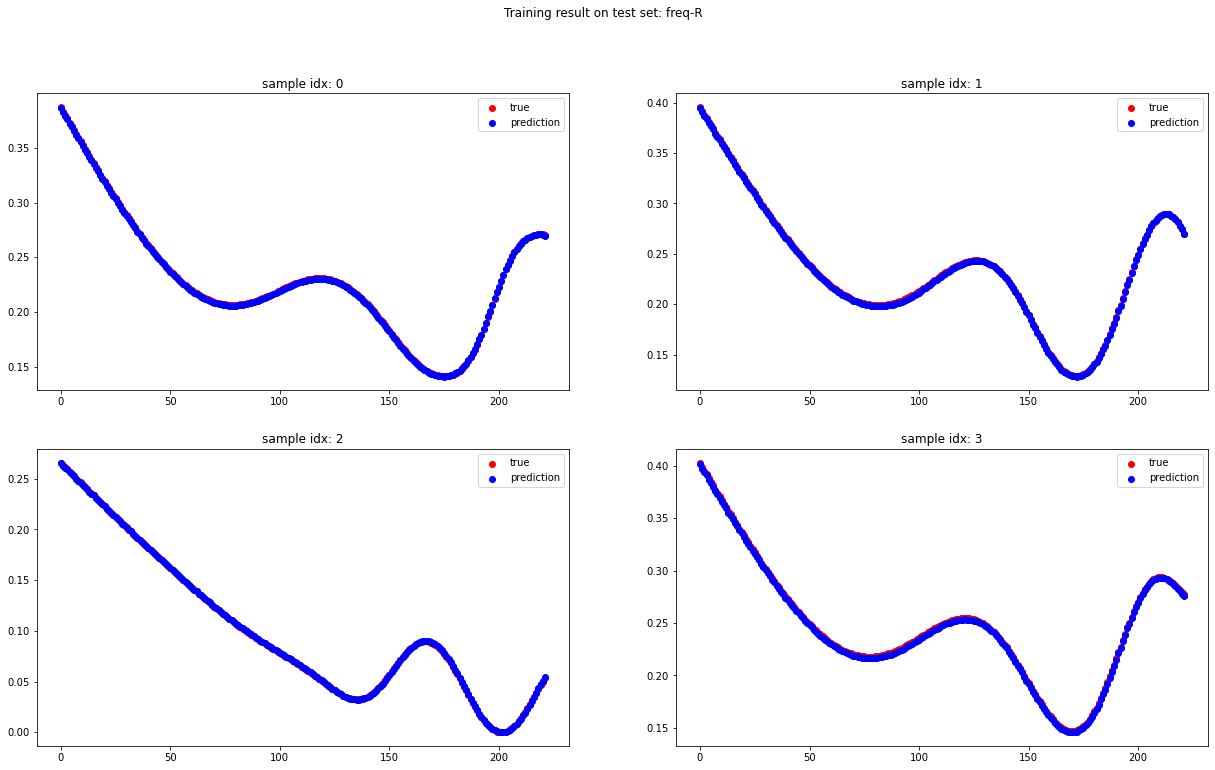

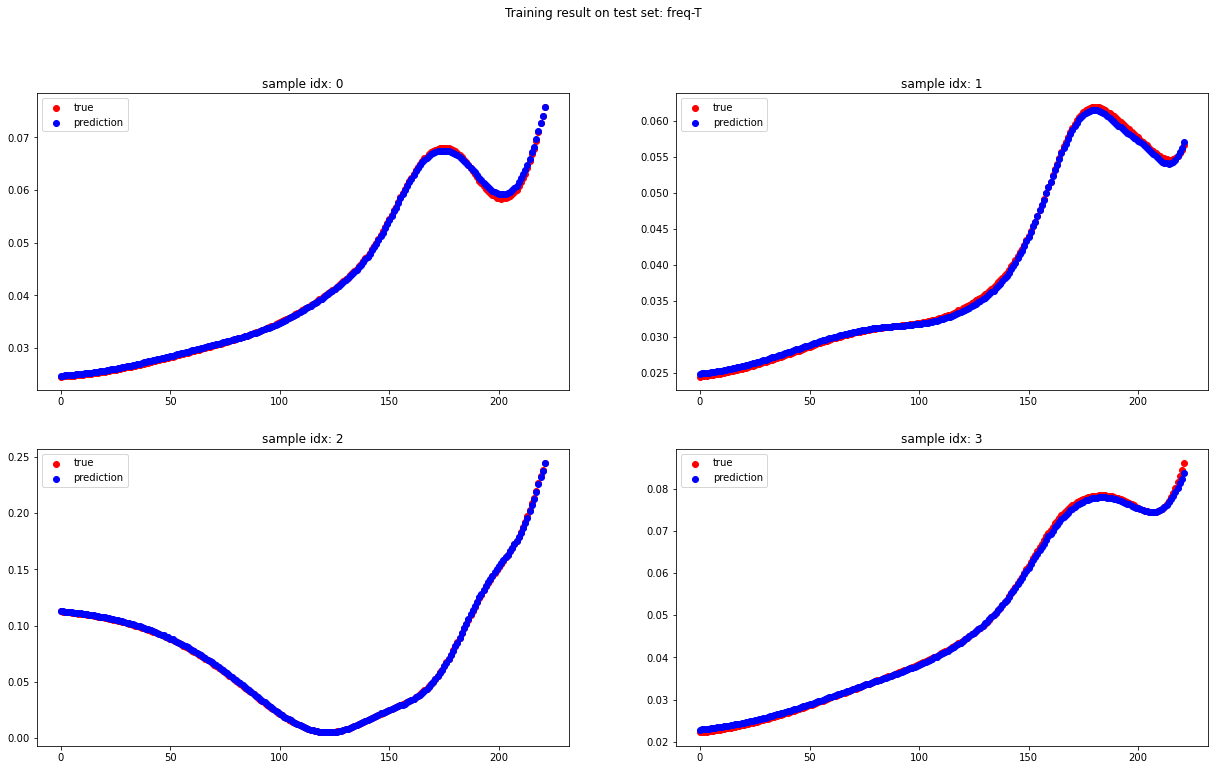

params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [146. 120. 160.  75.]
 [147. 119. 160.  75.]
 [146. 119. 160.  75.]
 [146. 122. 160.  75.]
 [145. 121. 160.  75.]
 [145. 122. 160.  75.]
 [145. 120. 160.  75.]
 [146. 123. 160.  75.]
 [147. 120. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


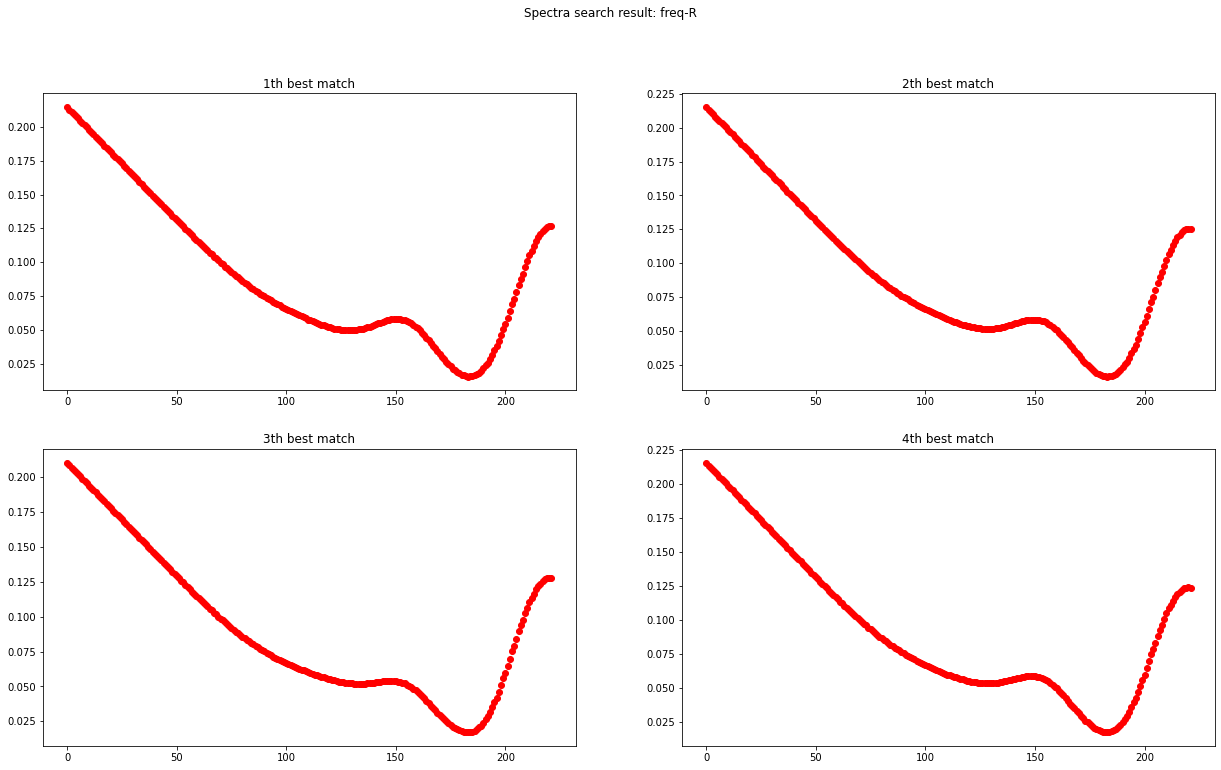

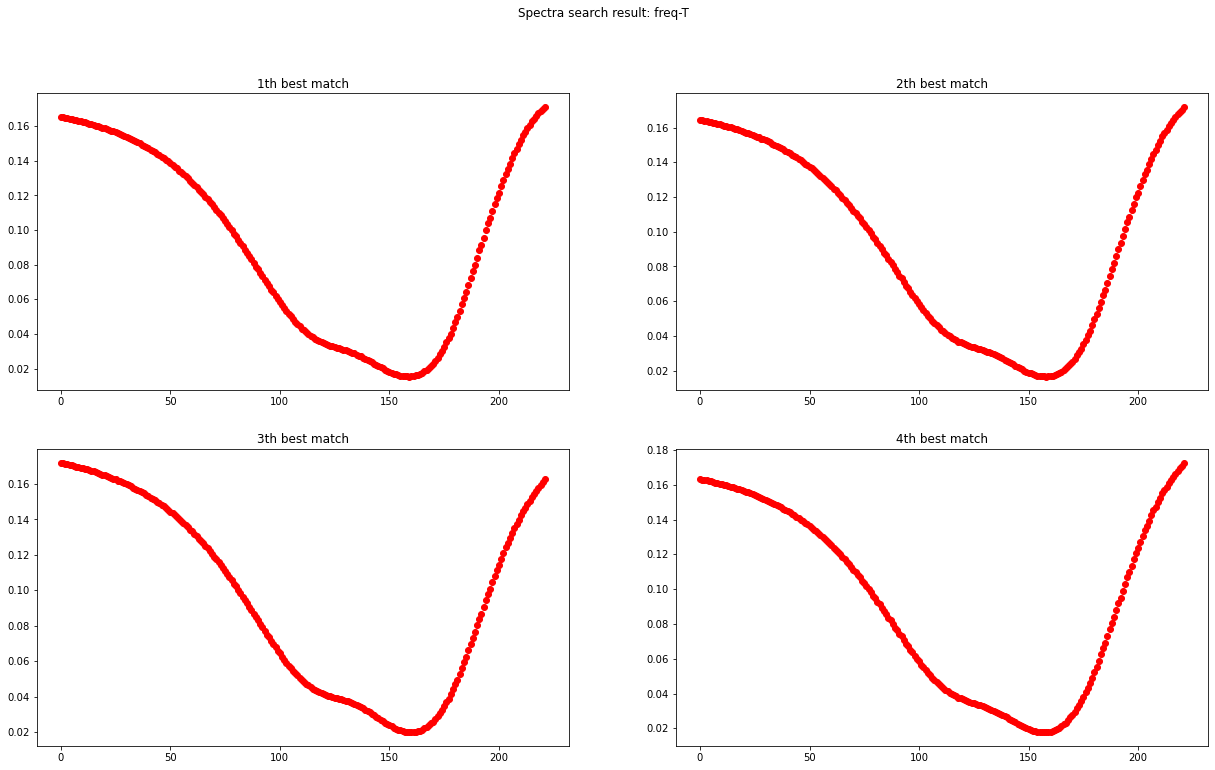

*** Reruning RCWA on picked params
params_dict.shape: (616, 4)
R_dict.shape: (616, 222)
T_dict.shape: (616, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [147. 119. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Already in the dict.
# params_dict: [146. 119. 160.  75.] params_pick: [146. 119. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.]

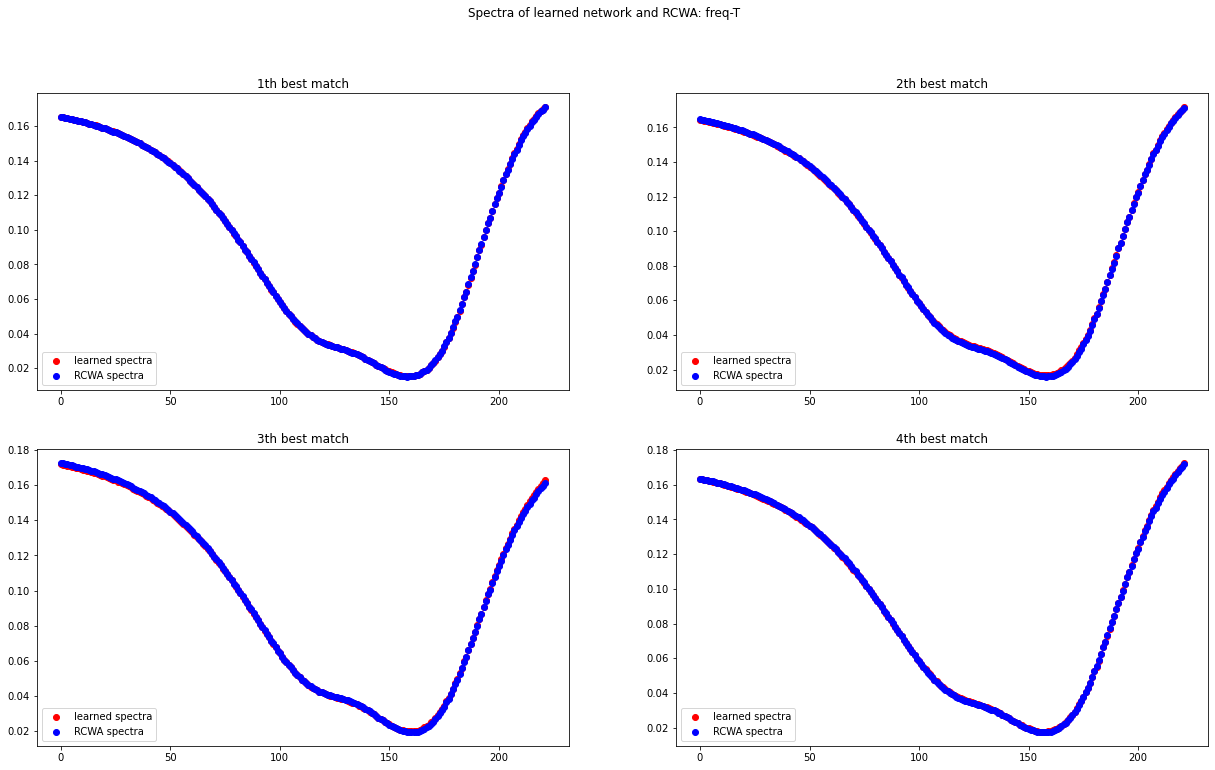

** Model saved.
**************************** ROUND 4 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 819
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [ 95. 114.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 75. 107.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [71. 51.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [81. 60.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [141. 124.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 51. 134.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [136. 143.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [121.  88.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [125.  98.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [72. 87.]
Calculation Prog

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [122.  93.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [117.  84.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [80. 91.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [117.  72.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [121. 145.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [114. 107.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [107.  74.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 88. 144.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [53. 98.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [135.  89.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [129. 110.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [134. 109.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 8.318069430204113e-05
### TEST LOSS  0.00019306357157452463
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 3.6073661153883694e-05
### TEST LOSS  6.252574698569682e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 2.9562157750615314e-05
### TEST LOSS  2.6923425348986013e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 2.013684205780003e-05
### TEST LOSS  1.743290256574535e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 1.569955306761877e-05
### TEST LOSS  2.6926176710381136e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 2.0314154461765022e-05
### TEST LOSS  1.653281091981066e-05
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 2.594030052799257e-06
### TEST LOSS  2.1118481929359123e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 2.4628828880868653e-06
### TEST LOSS  3.1025370634989276e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.4663788860103708e-06
### TEST LOSS  1.9380945297178605e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 2.8416871504376234e-06
### TEST LOSS  1.375140903711816e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.8281652086003256e-06
### TEST LOSS  1.7875453382797646e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 2.2134539993884092e-06
### TEST LOSS  2.8277353556824473e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 2.15328628035452e-06
### TEST LOSS  5.786588321125936e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 3.3793065712023577e-06
### TEST LOSS  1.5308923523732049e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.2663298669822958e-06
### TEST LOSS  1.7236381714050926e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.3070948025321026e-06
### TEST LOSS  1.0812124479833494e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.2150999587437731e-06
### TEST LOSS  1.0152129535666832e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.2443964958255503e-06
### TEST LOSS  3.44456821739396e-06
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 1.2487327817791136e-06
### TEST LOSS  1.1147078129607298e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 7.845962948208503e-07
### TEST LOSS  5.617280272382721e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 1.2634180837857007e-06
### TEST LOSS  5.995193204783461e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 1.0040947279189828e-06
### TEST LOSS  9.636419804337493e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.207270809349321e-06
### TEST LOSS  1.149502990161776e-06
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 1.8827101889965996e-06
### TEST LOSS  1.1552206379187387e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 1.0555303788038685e-06
### TEST LOSS  5.968202397245757e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 9.400720853653665e-07
### TEST LOSS  6.277865797808493e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 1.0245554845895347e-06
### TEST LOSS  6.724833383486839e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 4.0606566114851044e-06
### TEST LOSS  7.985233353862825e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 2.389058262581446e-06
### TEST LOSS  1.3093441653976556e-06
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 9.359478674588224e-07
### TEST LOSS  6.676469078788964e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 1.019604578540548e-06
### TEST LOSS  7.49073579369836e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 1.4028888637972061e-06
### TEST LOSS  4.507066758098797e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 1.207495948606443e-06
### TEST LOSS  7.1073794480560955e-06
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 3.117764967396758e-06
### TEST LOSS  7.347567619630214e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 1.2896292400386155e-06
### TEST LOSS  9.39017955768297e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 8.985144735536626e-07
### TEST LOSS  4.841570295446637e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 8.580465702526055e-07
### TEST LOSS  1.35072871479189e-06
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 1.2365567172323153e-06
### TEST LOSS  6.255659806916251e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 7.128122971346426e-07
### TEST LOSS  9.965632181354942e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 7.610897656543296e-07
### TEST LOSS  4.0940119779756617e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 1.3530107285840398e-06
### TEST LOSS  4.2752688063256545e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 6.739825841501285e-07
### TEST LOSS  1.9669611744505414e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 7.110359401304034e-07
### TEST LOSS  5.172940055112681e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.642861220590343e-07
### TEST LOSS  5.491107952611156e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 6.205057196820611e-07
### TEST LOSS  1.3756036441219085e-06
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 1.0393422010290715e-06
### TEST LOSS  5.492061500962546e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 7.604832966032553e-07
### TEST LOSS  6.198180813044019e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 6.451140358613124e-07
### TEST LOSS  7.313014975807164e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 1.0378635356294785e-06
### TEST LOSS  9.269796718259526e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 7.390374104943615e-07
### TEST LOSS  4.745201898423637e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.635019500653807e-07
### TEST LOSS  6.32065708626984e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 2.84512336572443e-06
### TEST LOSS  1.536842257967062e-06
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 9.299554455209722e-07
### TEST LOSS  8.258304634322345e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 1.2856609123800075e-06
### TEST LOSS  5.339208017246094e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 5.175669242863526e-07
### TEST LOSS  8.256712450160054e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 6.223109484148058e-07
### TEST LOSS  6.691171322997363e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.104123821370173e-07
### TEST LOSS  3.7557263637539177e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.521485970903972e-07
### TEST LOSS  3.958115760619526e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 5.010599039236247e-07
### TEST LOSS  9.395185910622016e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 5.364193357169818e-07
### TEST LOSS  7.00300465548655e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.6870881746867526e-07
### TEST LOSS  3.0525090831081167e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 1.1388558575101903e-06
### TEST LOSS  6.248332143653757e-06
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 1.5263350506615113e-06
### TEST LOSS  6.498147119880462e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 6.025774090006847e-07
### TEST LOSS  5.774269442764097e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.653761645794357e-07
### TEST LOSS  3.7916986719630165e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 6.445039717806596e-07
### TEST LOSS  3.2071133222626276e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.774373800783118e-07
### TEST LOSS  6.733548791369406e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.7270399478476906e-07
### TEST LOSS  4.1890691940912245e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.477333553916224e-07
### TEST LOSS  5.049045888391937e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.721579756644701e-07
### TEST LOSS  3.295506849973698e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.892992740552088e-07
### TEST LOSS  4.630290172476984e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.869539982817708e-07
### TEST LOSS  3.001450411287666e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.409253244727951e-07
### TEST LOSS  4.087934695025279e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.466022069615107e-07
### TEST LOSS  4.698029578356419e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 5.033700579453052e-07
### TEST LOSS  4.5077125867884695e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 5.169405377810777e-07
### TEST LOSS  6.214557751823472e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.145799689156536e-07
### TEST LOSS  3.262517728112121e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.3649534991548384e-07
### TEST LOSS  4.282925767886179e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.822703010552114e-07
### TEST LOSS  3.0959824598015143e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.239173212748751e-07
### TEST LOSS  3.549292994893431e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.604029696186241e-07
### TEST LOSS  3.15310822648266e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 4.074826416367936e-07
### TEST LOSS  4.1240320806187253e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.627264341506044e-07
### TEST LOSS  2.971573739894386e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 4.030504544003853e-07
### TEST LOSS  6.273647644460513e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.3405352827763637e-07
### TEST LOSS  4.5570691370882673e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 4.3735490429892643e-07
### TEST LOSS  2.62822226204662e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 4.277769133770403e-07
### TEST LOSS  2.6255499873374134e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 4.2868905799545803e-07
### TEST LOSS  3.616906645640064e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.462938089726777e-07
### TEST LOSS  3.360185849907374e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 4.086523141974738e-07
### TEST LOSS  3.81378406735586e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.96841748817085e-07
### TEST LOSS  3.664598252201428e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.6121833055598595e-07
### TEST LOSS  4.044054089892877e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.3488865883466627e-07
### TEST LOSS  2.87352312747876e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.5084296127973626e-07
### TEST LOSS  5.336295360463666e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.68922218607519e-07
### TEST LOSS  4.709871527316304e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.890882367705984e-07
### TEST LOSS  6.26745829252356e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 4.172122697658797e-07
### TEST LOSS  4.28245451408097e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.992238730834799e-07
### TEST LOSS  2.9550320863773567e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.91175689599017e-07
### TEST LOSS  4.176508919219766e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 4.080997784286056e-07
### TEST LOSS  5.462956489911728e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.737066221300856e-07
### TEST LOSS  3.549942103011115e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 5.626784520646175e-07
### TEST LOSS  8.587725298744212e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 4.102139934630964e-07
### TEST LOSS  4.039791052106851e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.611755318645195e-07
### TEST LOSS  2.5607656849702977e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.743598854565741e-07
### TEST LOSS  3.6141376496673797e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 4.0112499101160105e-07
### TEST LOSS  3.9406704497825837e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 4.055669108854431e-07
### TEST LOSS  2.889713149793002e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.896737326953031e-07
### TEST LOSS  2.6445176961085684e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.4809452285267893e-07
### TEST LOSS  2.9358631737662876e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.9635794321371815e-07
### TEST LOSS  3.4553706794982787e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.4845784139900285e-07
### TEST LOSS  4.810331295000371e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 4.3105041139724246e-07
### TEST LOSS  2.6475314904508616e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.868932458758158e-07
### TEST LOSS  4.7417783723456245e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.3040579290587806e-07
### TEST LOSS  4.297732363493896e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.55314629630222e-07
### TEST LOSS  3.697787134954594e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.4455850678935703e-07
### TEST LOSS  2.60588012023478e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.7012993141657383e-07
### TEST LOSS  2.732293128159514e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.748261360302007e-07
### TEST LOSS  3.5173023058212914e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.297449514762737e-07
### TEST LOSS  3.220184663195351e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.4388235298811337e-07
### TEST LOSS  5.111327823215106e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.5285887052743574e-07
### TEST LOSS  3.7567300873538795e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.9672213471688393e-07
### TEST LOSS  2.800322337092299e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 4.063445257842486e-07
### TEST LOSS  3.639303171299756e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.357167939731101e-07
### TEST LOSS  4.268297791790806e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.3803350601360454e-07
### TEST LOSS  2.2598043668809763e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.423633360530848e-07
### TEST LOSS  2.1531310450812342e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.5036918651835197e-07
### TEST LOSS  4.903015145338521e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.3991248601111074e-07
### TEST LOSS  3.342859626032945e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.5023930775208354e-07
### TEST LOSS  4.2083854186085563e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.4050100963519283e-07
### TEST LOSS  3.3003834468777666e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 9.303447282618674e-07
### TEST LOSS  1.1358292401662486e-06
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 5.311361700768348e-07
### TEST LOSS  1.048464261325185e-06
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.208963816905508e-07
### TEST LOSS  1.8481598501169245e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.1348572914255544e-07
### TEST LOSS  2.535708078382343e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.5872806006718373e-07
### TEST LOSS  3.0800030642170054e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.4327890497128266e-07
### TEST LOSS  2.502226747170565e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.8300644433775233e-07
### TEST LOSS  2.7821276441605175e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.4857324497390966e-07
### TEST LOSS  3.9216436675815203e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.789415660027618e-07
### TEST LOSS  2.0694145392168977e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.957298878812839e-07
### TEST LOSS  5.706054366783064e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.3523775671663274e-07
### TEST LOSS  2.2629958297014897e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.136176424663958e-07
### TEST LOSS  3.263324445540023e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.112651120837142e-07
### TEST LOSS  3.355867980085e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.1116601760316184e-07
### TEST LOSS  2.9257996039597435e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.258667952348716e-07
### TEST LOSS  3.8244028224618467e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.966868886201477e-07
### TEST LOSS  3.5361834814186574e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.937192939400483e-07
### TEST LOSS  2.0220060456757403e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.843434850385756e-07
### TEST LOSS  3.527875378495082e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.6559659911840345e-07
### TEST LOSS  2.0959717735772406e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.803125830001561e-07
### TEST LOSS  2.7461357905604717e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.353738461946724e-07
### TEST LOSS  2.400370752079303e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 4.147673198643009e-06
### TEST LOSS  1.1096221240992377e-06
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 7.408713656500559e-07
### TEST LOSS  6.66050982982387e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 4.492233376808468e-07
### TEST LOSS  3.431502827529934e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.6641690106886563e-07
### TEST LOSS  3.188864485974381e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.7861704532336665e-07
### TEST LOSS  2.682040496018509e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.686947941560562e-07
### TEST LOSS  2.3977279922221965e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.820823990637667e-07
### TEST LOSS  2.1833440546113428e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.618367382328756e-07
### TEST LOSS  2.7826861416822516e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.1526214394020654e-07
### TEST LOSS  1.956903452957284e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.926249821362107e-07
### TEST LOSS  1.9475694684318185e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.925901716602753e-07
### TEST LOSS  2.2461646245539248e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.1427153077117894e-07
### TEST LOSS  2.4500043484574866e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.1101151552495695e-07
### TEST LOSS  3.031070358124802e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.2062197600285184e-07
### TEST LOSS  1.9514105203527904e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.0607308727877973e-07
### TEST LOSS  1.373594159304048e-06
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.101349383291049e-07
### TEST LOSS  1.903702800868464e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.7178448465868673e-07
### TEST LOSS  3.6021509248922274e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.8622260728344074e-07
### TEST LOSS  2.586924414170146e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.9331917685826694e-07
### TEST LOSS  5.357546425644754e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.123564993057974e-07
### TEST LOSS  2.503827381325699e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.952804118855854e-07
### TEST LOSS  1.92148105016853e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.8162832326469183e-07
### TEST LOSS  2.895812918688115e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.469386466894786e-07
### TEST LOSS  2.535126723247371e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 3.193910357105428e-07
### TEST LOSS  4.2340899907545605e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.242623983612064e-07
### TEST LOSS  7.029628320126974e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.0791927116125593e-07
### TEST LOSS  1.985061627552708e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.831405535123775e-07
### TEST LOSS  2.668588675847926e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.087253923362234e-07
### TEST LOSS  2.588500376095208e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.840969281928176e-07
### TEST LOSS  2.3968978706097215e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 4.736872366390049e-07
### TEST LOSS  6.583883458251177e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 5.892539467919951e-07
### TEST LOSS  6.980251481099214e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 5.426126155172598e-07
### TEST LOSS  3.2552067243439245e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.778546843803045e-07
### TEST LOSS  4.4458725876840896e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 4.0936848043652495e-07
### TEST LOSS  3.866161561151015e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.562345827228977e-07
### TEST LOSS  2.1571035255454683e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.819906263009954e-07
### TEST LOSS  2.2643672864957736e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.8958612652434724e-07
### TEST LOSS  2.423903971213384e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 4.44035116565605e-07
### TEST LOSS  3.5392262877674233e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.6492796997774513e-07
### TEST LOSS  2.914405143883414e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.163690080237049e-07
### TEST LOSS  2.0717177580291508e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.778711714660481e-07
### TEST LOSS  2.4119094960566986e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.74798396383681e-07
### TEST LOSS  2.397941909311367e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.208234139054332e-07
### TEST LOSS  3.8776348368138804e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.909669120593687e-07
### TEST LOSS  2.2300769750507663e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.637383989453735e-07
### TEST LOSS  2.630099330120244e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.907083382463495e-07
### TEST LOSS  2.845363411552171e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 5.788700751453193e-07
### TEST LOSS  3.652035867564616e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.523685367263724e-07
### TEST LOSS  3.50769445626261e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.828606844776334e-07
### TEST LOSS  1.7857672455298038e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.3980987816829243e-07
### TEST LOSS  2.1367376872988714e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.433389110171735e-07
### TEST LOSS  1.9417786981753474e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.6098758338414625e-07
### TEST LOSS  5.005797250900147e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.975353294341578e-07
### TEST LOSS  2.061318500505667e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.626005719102315e-07
### TEST LOSS  2.1363275620317907e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.654201891250205e-07
### TEST LOSS  2.9941255027447017e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.666179131559506e-07
### TEST LOSS  2.037086036265324e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.6561414401271577e-07
### TEST LOSS  1.8652789453181657e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.385603562659843e-07
### TEST LOSS  2.5668355345505216e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.649770766923698e-07
### TEST LOSS  2.1945029970993346e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.6929298909747363e-07
### TEST LOSS  2.0921052842263285e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.7083021555322023e-07
### TEST LOSS  5.851967509547999e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.0680302474700215e-07
### TEST LOSS  2.5517622121312274e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.4479003361139465e-07
### TEST LOSS  2.1240629603898225e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.572113159518962e-07
### TEST LOSS  2.7171243853165203e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.94330881753137e-07
### TEST LOSS  2.2294670560978165e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.7435357419130537e-07
### TEST LOSS  2.34078158839041e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.394189842934332e-07
### TEST LOSS  2.1117718063123903e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.478353944849246e-07
### TEST LOSS  2.0116471633767875e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.3922950820863154e-07
### TEST LOSS  1.9824005684872995e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.6578850891184604e-07
### TEST LOSS  2.991737860524014e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.579854417648669e-07
### TEST LOSS  1.9982446111463594e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.103371441366617e-07
### TEST LOSS  1.8243274159711012e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 3.479048851541078e-07
### TEST LOSS  1.9009414568944732e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.8802940854529545e-07
### TEST LOSS  1.9776766617514323e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.87898881233097e-07
### TEST LOSS  2.850494481138482e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.667803080322244e-07
### TEST LOSS  1.7738138616060985e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.4857681832977774e-07
### TEST LOSS  2.1143136363067382e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.534640342950324e-07
### TEST LOSS  3.15980044591085e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.458540552516925e-07
### TEST LOSS  2.2596214403865116e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.57297435939445e-07
### TEST LOSS  3.8311173092062325e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.769808811233505e-07
### TEST LOSS  2.3728540663971495e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.349248366091278e-07
### TEST LOSS  1.7263194907767544e-07
** loss_train 2.349248366091278e-07
** loss_test 1.7263194907767544e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


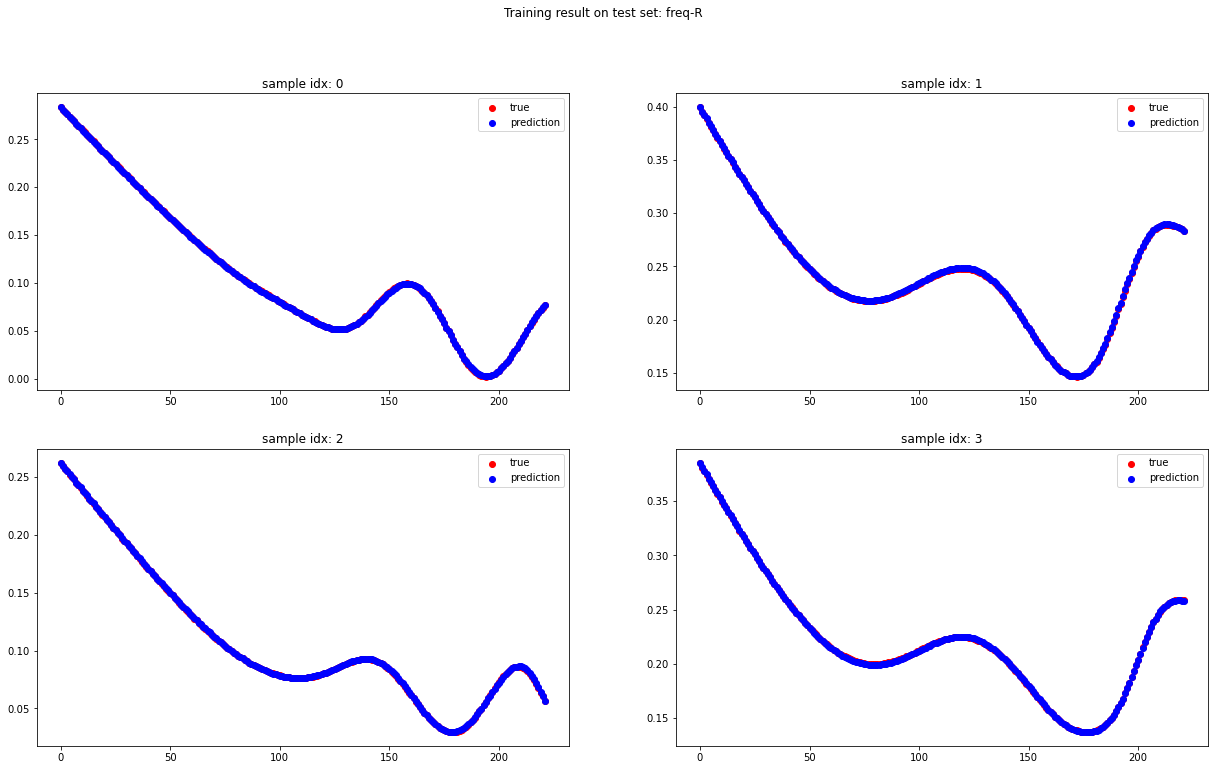

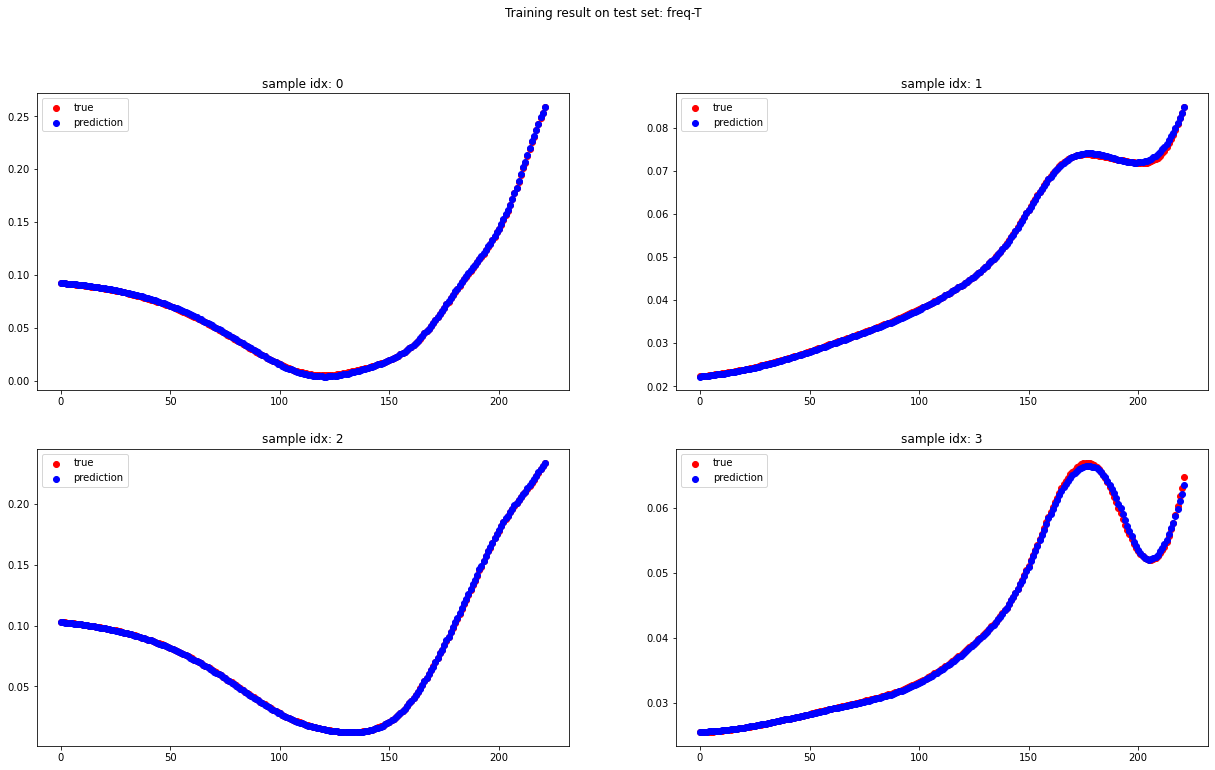

params_pick.shape: (10, 4)
params_pick: [[146. 122. 160.  75.]
 [146. 123. 160.  75.]
 [146. 121. 160.  75.]
 [145. 122. 160.  75.]
 [146. 120. 160.  75.]
 [145. 121. 160.  75.]
 [145. 123. 160.  75.]
 [147. 121. 160.  75.]
 [147. 122. 160.  75.]
 [147. 120. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


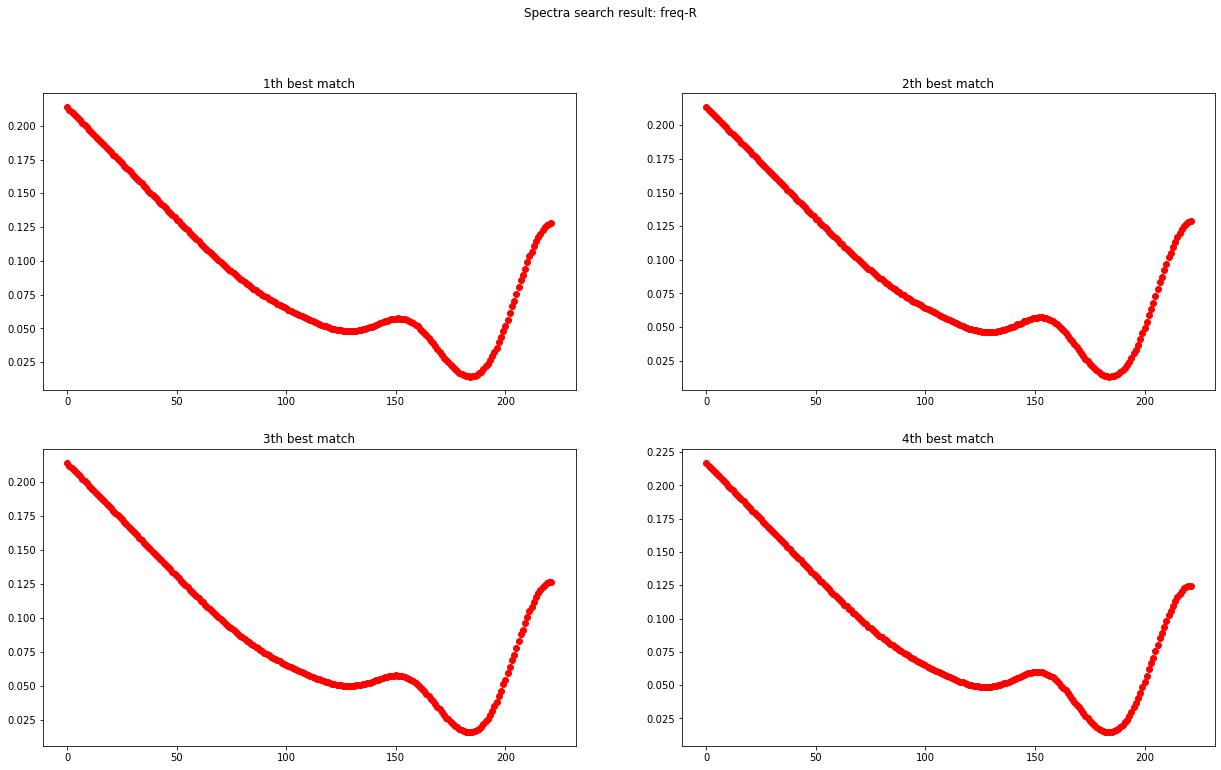

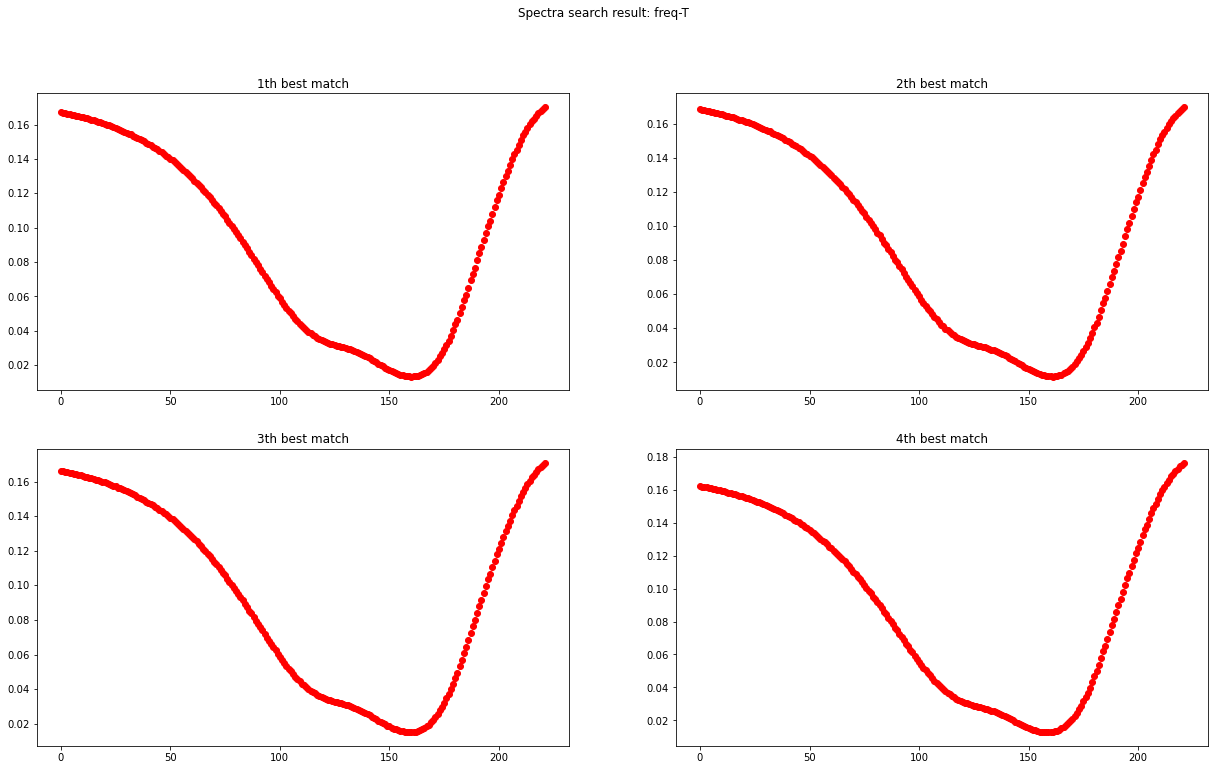

*** Reruning RCWA on picked params
params_dict.shape: (819, 4)
R_dict.shape: (819, 222)
T_dict.shape: (819, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
------------

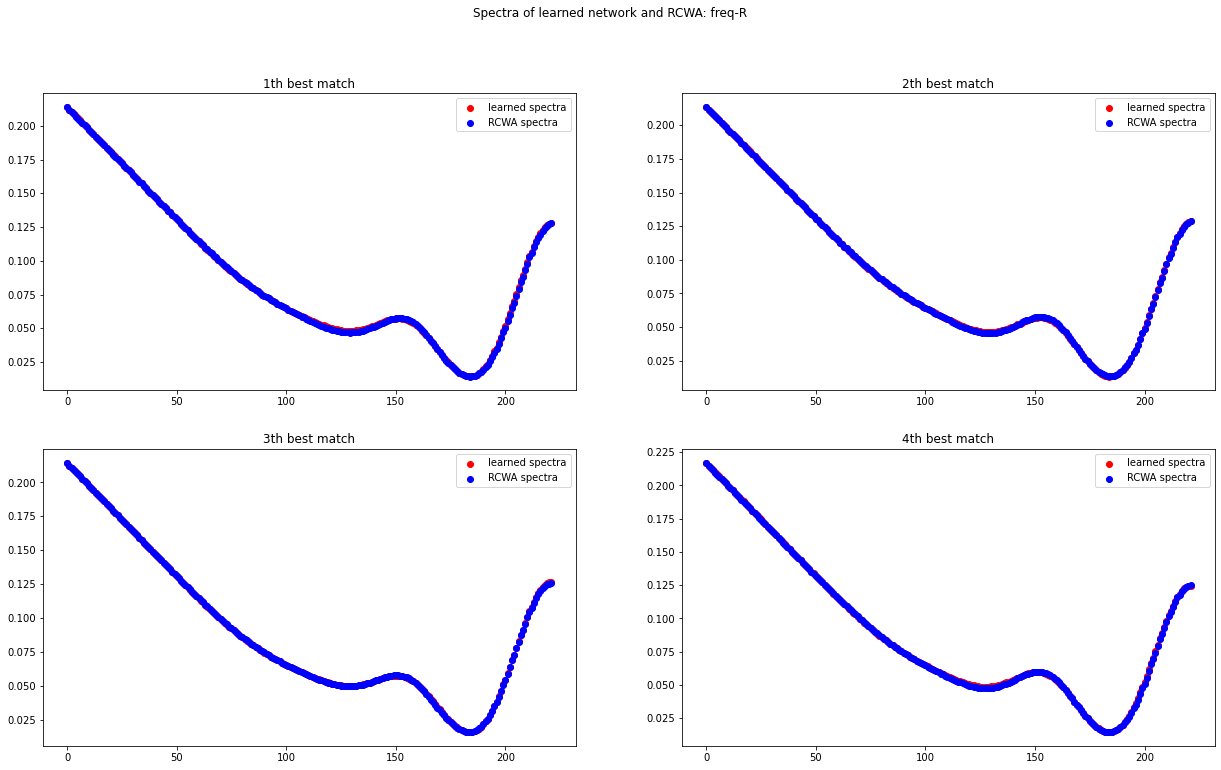

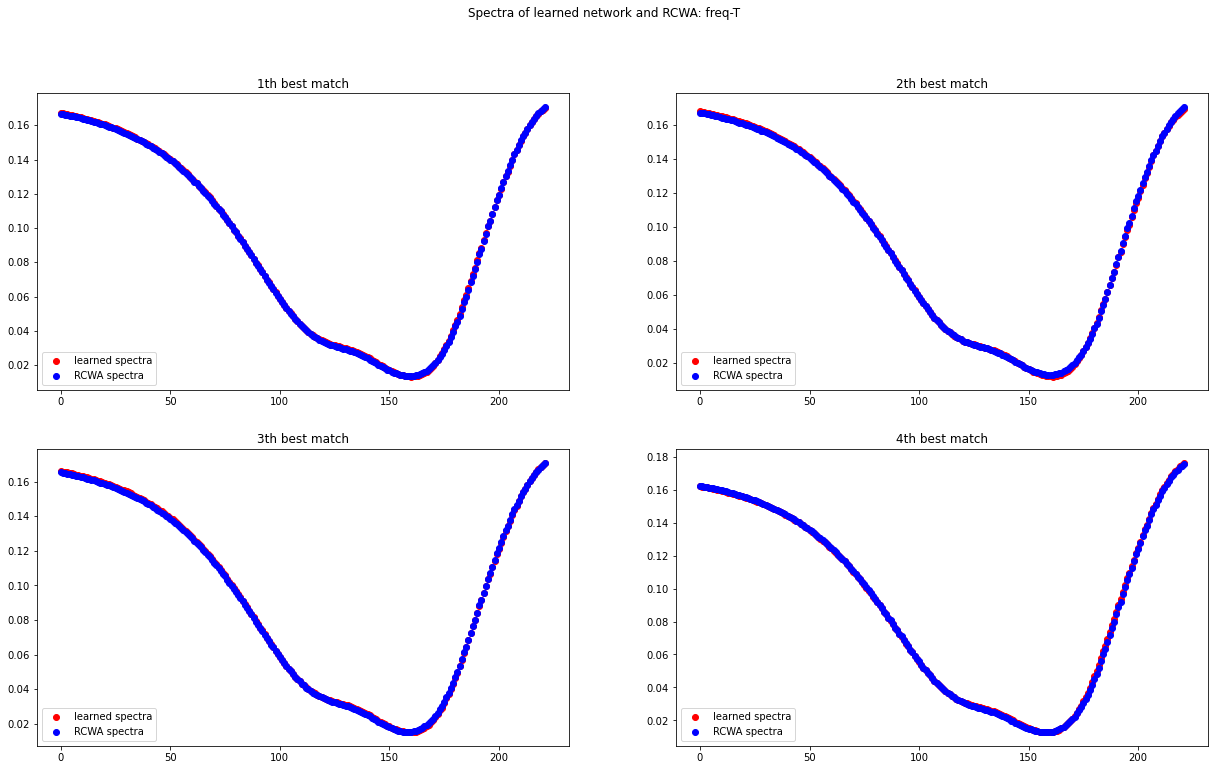

** Model saved.
**************************** ROUND 5 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1020
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [136.  57.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [123. 115.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [97. 72.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [139.  56.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 59. 102.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [113. 130.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [ 72. 133.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [115. 124.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [131. 108.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 97. 143.]
Calculation

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [96. 88.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [ 79. 111.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [127.  84.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [78. 69.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [115.  82.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [ 98. 122.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 68. 103.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [107. 131.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [129. 123.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [146.  77.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [90. 82.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 61. 135.]
Calculation Progress: 100%
-------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 5.7238380088062745e-05
### TEST LOSS  0.0001309488147853699
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.9871063846396425e-05
### TEST LOSS  7.6068455996392e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 9.376604192182498e-06
### TEST LOSS  0.00014736326860997906
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.3942983500214723e-05
### TEST LOSS  4.127608917769976e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 1.130707524492668e-05
### TEST LOSS  1.0179692679912478e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 9.442266838751342e-06
### TEST LOSS  3.98806344037439e-06
----------------------------------------------------------------------
***

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.3214604915473875e-06
### TEST LOSS  1.4200999700619832e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.2435452092063315e-06
### TEST LOSS  1.586545984366694e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.559647762963091e-06
### TEST LOSS  8.593266613843298e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.2152756786641546e-06
### TEST LOSS  2.5196398176774437e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.318690630522334e-06
### TEST LOSS  1.8856005858935987e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.341638527841949e-06
### TEST LOSS  1.8063604798612687e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 8.285790050277955e-07
### TEST LOSS  5.39413528954924e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 7.469511287838464e-07
### TEST LOSS  8.974746599221817e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 9.104003568480453e-07
### TEST LOSS  1.3653070283226043e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 7.767787423341699e-07
### TEST LOSS  6.362869626741485e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.0940616350059903e-06
### TEST LOSS  1.0657364128974223e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 7.114407968052372e-07
### TEST LOSS  8.289147750417669e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 7.360472074380505e-07
### TEST LOSS  1.2035607710458862e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 8.516426967911813e-07
### TEST LOSS  9.703888181888942e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 1.096862622637803e-06
### TEST LOSS  7.7794735631187e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 7.373179610528037e-07
### TEST LOSS  9.733082464435938e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 7.362399682675709e-07
### TEST LOSS  1.2010670822348857e-06
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.664409241683933e-07
### TEST LOSS  7.632189085171603e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 1.3739214872726995e-06
### TEST LOSS  1.0821677918215755e-06
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 1.4580828603416149e-06
### TEST LOSS  2.9513035428863077e-06
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 9.692585470128947e-07
### TEST LOSS  1.001761233965226e-06
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 1.0274914029776362e-06
### TEST LOSS  8.081205749022047e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 1.5068928593541275e-06
### TEST LOSS  1.2987853992285636e-06
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 1.5299173622614315e-06
### TEST LOSS  1.166951197006938e-06
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.830377332526121e-07
### TEST LOSS  6.918445443204746e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.348357027218037e-07
### TEST LOSS  6.874243503318667e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.465289849788755e-07
### TEST LOSS  4.7544066461568946e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 6.083156182038844e-07
### TEST LOSS  5.754418062053901e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 5.143582379330427e-07
### TEST LOSS  6.769185745270079e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 7.586033441298263e-07
### TEST LOSS  5.46957227953726e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 5.545440903373769e-07
### TEST LOSS  5.813124523967872e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 8.163306666946768e-07
### TEST LOSS  1.3174661077641758e-06
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 6.760524437259405e-07
### TEST LOSS  3.865114788226265e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.856145798876401e-07
### TEST LOSS  1.1903265324519907e-06
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 6.80814646638562e-07
### TEST LOSS  1.0817997342371655e-06
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 7.172795470745653e-07
### TEST LOSS  5.340167330558643e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 5.919052031500223e-07
### TEST LOSS  4.186078701451379e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.7665568494056407e-07
### TEST LOSS  5.767816286805783e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.735180116594562e-07
### TEST LOSS  3.562250086019958e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 1.0084178838893115e-06
### TEST LOSS  5.696528866394601e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 8.243746864090552e-07
### TEST LOSS  3.6483826271194175e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.853911600045646e-07
### TEST LOSS  6.2084201957191e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 5.000676022081554e-07
### TEST LOSS  6.224346034144901e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.599605252144166e-07
### TEST LOSS  2.5525289171213217e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.300961826547167e-07
### TEST LOSS  5.612852671532664e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 4.5455084974953343e-07
### TEST LOSS  3.1033059499918636e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.779792650949742e-07
### TEST LOSS  3.093038296597683e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 5.50832805438805e-07
### TEST LOSS  6.006163548732957e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.471444241799565e-07
### TEST LOSS  6.283230380432769e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.6801404711432577e-07
### TEST LOSS  3.4454575192910397e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.729289435519194e-07
### TEST LOSS  3.903032741447987e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.016755907791631e-07
### TEST LOSS  9.318681470915635e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.595974496700594e-07
### TEST LOSS  5.186742804141886e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.826505488782899e-07
### TEST LOSS  2.9023830450114474e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.8488305597769234e-07
### TEST LOSS  4.0264949952018014e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.266082389099946e-07
### TEST LOSS  6.409375075122625e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.0565963697712074e-07
### TEST LOSS  3.928802190245051e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.230059363352416e-07
### TEST LOSS  2.850320450775712e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.8019876541702216e-07
### TEST LOSS  4.511415578889455e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.4006655379431037e-07
### TEST LOSS  6.648414263565883e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.6529037620111764e-07
### TEST LOSS  4.162540587770991e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.363340103243646e-07
### TEST LOSS  3.6887410104213814e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.607075574091257e-07
### TEST LOSS  3.2737618127498536e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 6.129268543201435e-07
### TEST LOSS  4.859781839172683e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.344355672170717e-07
### TEST LOSS  2.777344976223617e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.2416956135554633e-07
### TEST LOSS  4.27584568640782e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.895565343837051e-07
### TEST LOSS  3.182517716027178e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.508779876182802e-07
### TEST LOSS  5.773776514672591e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.1133865212981167e-07
### TEST LOSS  6.764645803514213e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.99196593602564e-07
### TEST LOSS  2.488661596800057e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.694577747075291e-07
### TEST LOSS  2.749359380160854e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.8494094310372176e-07
### TEST LOSS  1.0364134226392707e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.688274517276615e-07
### TEST LOSS  3.581639624883337e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.9370384617268764e-07
### TEST LOSS  7.146166947080701e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.1893115070911226e-07
### TEST LOSS  4.782645106615746e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.8297159516670885e-07
### TEST LOSS  3.6369512557143935e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.6790836254642927e-07
### TEST LOSS  4.780242086610542e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.3899430703752165e-07
### TEST LOSS  2.8159777709646505e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.373367642390801e-07
### TEST LOSS  4.686824013333535e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.142219089543444e-07
### TEST LOSS  2.449186240482959e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.2959935483308626e-07
### TEST LOSS  6.218136938684893e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 4.343051311176775e-07
### TEST LOSS  5.108551537347239e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.3679670005050317e-07
### TEST LOSS  6.569251791432862e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.686391735659727e-07
### TEST LOSS  2.460618064858977e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.489896156409739e-07
### TEST LOSS  3.2719086373589334e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.669738850749907e-07
### TEST LOSS  2.5517534574248657e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.172334824251201e-07
### TEST LOSS  2.8802933815796905e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.8589868634442793e-07
### TEST LOSS  2.519105510856434e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.3205108647867593e-07
### TEST LOSS  2.6109274475771826e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 8.330527930049098e-07
### TEST LOSS  3.939049086909563e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.3536333279554957e-07
### TEST LOSS  3.4012339078515197e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.973457577606777e-07
### TEST LOSS  3.709627751646849e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.560824452935607e-07
### TEST LOSS  2.2430546930962691e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.4288336419052713e-07
### TEST LOSS  4.4793712206114833e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.151803684238697e-07
### TEST LOSS  2.6047559931186015e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.816845927840471e-07
### TEST LOSS  4.615512683159295e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.479995207939066e-07
### TEST LOSS  3.5571950185442347e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 4.5333119043742526e-07
### TEST LOSS  3.5598710290685176e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.557359232720261e-07
### TEST LOSS  4.787170286846276e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.5828898654741314e-07
### TEST LOSS  2.845604667456314e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.6587524215020757e-07
### TEST LOSS  2.454250997985241e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.0994901702996456e-07
### TEST LOSS  3.5992182567667896e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.907738258400108e-07
### TEST LOSS  3.1221213703247486e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.1356657567476316e-07
### TEST LOSS  2.2511395592061945e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.977255225588897e-07
### TEST LOSS  3.5827347577566115e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.8313655728649e-07
### TEST LOSS  1.3118506601017543e-06
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 1.2797047322370545e-06
### TEST LOSS  5.891432408589026e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 6.638336877563958e-07
### TEST LOSS  4.6336306525063264e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.9723446674762555e-07
### TEST LOSS  2.672901642242209e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.8931544397502035e-07
### TEST LOSS  2.0811662970743328e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.927438766587396e-07
### TEST LOSS  3.938846848683397e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.195443877675855e-07
### TEST LOSS  2.1443363440454277e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.112270565447057e-07
### TEST LOSS  2.292148462146315e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.3208219874525164e-07
### TEST LOSS  3.001486437170797e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.182997205416548e-07
### TEST LOSS  2.1047833786980163e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.122015913208942e-07
### TEST LOSS  5.134913525495222e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.595344172706702e-07
### TEST LOSS  2.670353111966506e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.933534037437992e-07
### TEST LOSS  3.5608528747843593e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.043721643387707e-07
### TEST LOSS  3.003955901803579e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.827567791898918e-07
### TEST LOSS  1.9243743931696145e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 6.141603676621575e-07
### TEST LOSS  4.557075143907241e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.4710013393175343e-07
### TEST LOSS  2.7518108591806367e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.4718752933856903e-07
### TEST LOSS  3.497485483450191e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.354912629848674e-07
### TEST LOSS  3.091123028653442e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.9537238995073145e-07
### TEST LOSS  2.820070736930802e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.132063096947518e-07
### TEST LOSS  2.789642516987101e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.8485315532749917e-07
### TEST LOSS  2.507325129741389e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.007949332365846e-07
### TEST LOSS  2.9437594140091505e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.948942348526448e-07
### TEST LOSS  2.3584819697219928e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.1488305647974246e-07
### TEST LOSS  3.585567416308777e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.051905027136124e-07
### TEST LOSS  3.5887890703634184e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.2430809598937413e-07
### TEST LOSS  3.3120701381506024e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.9619582302148013e-07
### TEST LOSS  2.5190260899421446e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.069600698347697e-07
### TEST LOSS  3.098969934001161e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.7355848697396823e-07
### TEST LOSS  3.328180042672102e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.1892031340502773e-07
### TEST LOSS  3.8972477423016016e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.594263319861112e-07
### TEST LOSS  2.0664764566191707e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.0279918650189846e-07
### TEST LOSS  2.5702155426188256e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.0564728905569697e-07
### TEST LOSS  2.724908521045677e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.832875938588001e-07
### TEST LOSS  1.9867664935446783e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.017071872857922e-07
### TEST LOSS  2.354942765236956e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.745486518025289e-07
### TEST LOSS  2.648291799189906e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.6679832655297693e-07
### TEST LOSS  2.7769986576942074e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.777152743449256e-07
### TEST LOSS  1.9260941908072482e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.5448033546744713e-07
### TEST LOSS  4.51753157548751e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.8018214799058737e-07
### TEST LOSS  3.684620146771067e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.125584511175092e-07
### TEST LOSS  3.3052714343284606e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.8561501301554666e-07
### TEST LOSS  2.227134210386339e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.7259378154121915e-07
### TEST LOSS  2.5203413933638785e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.777953711072637e-07
### TEST LOSS  1.9302192377779193e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.000418413540478e-07
### TEST LOSS  2.2534460164536085e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.9930102047315497e-07
### TEST LOSS  4.1276867790429606e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.8880937309657097e-07
### TEST LOSS  1.9544024887352407e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.814291857229237e-07
### TEST LOSS  2.0793109456462844e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.2356132127758894e-07
### TEST LOSS  2.0694023339373757e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.8605149599428335e-07
### TEST LOSS  2.1068567157556117e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.6623042022796045e-07
### TEST LOSS  2.294959866588897e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.8566201444400396e-07
### TEST LOSS  2.498039570753008e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.681861865062998e-07
### TEST LOSS  2.474738254321096e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.1382062954377286e-07
### TEST LOSS  4.527869279513652e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.128418141847245e-07
### TEST LOSS  5.561645401996884e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.0588773736880904e-07
### TEST LOSS  4.306416387933609e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.866659839162673e-07
### TEST LOSS  3.2134488847646026e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.884869898418388e-07
### TEST LOSS  2.962407945616974e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.834180497785053e-07
### TEST LOSS  1.9645010596036627e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.7167945905160353e-07
### TEST LOSS  2.9488784036857396e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.601487684949837e-07
### TEST LOSS  2.8044700162155323e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.863629489317978e-07
### TEST LOSS  2.9176689952947754e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.894305057408001e-07
### TEST LOSS  3.0790352845144753e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.917684493450911e-07
### TEST LOSS  2.2035887603522042e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.513155945989521e-07
### TEST LOSS  2.1110455605821699e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.5653378927879477e-07
### TEST LOSS  2.228442985696688e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.4676107767325727e-07
### TEST LOSS  3.2833960084133196e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.845448700957339e-07
### TEST LOSS  4.6518113272497885e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.520679831556382e-07
### TEST LOSS  2.3995219944339397e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.6448547517153884e-07
### TEST LOSS  4.064901784062158e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.5890277703334275e-07
### TEST LOSS  6.0924522315986e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.838770287962605e-07
### TEST LOSS  2.4274419896386235e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.613688490213536e-07
### TEST LOSS  4.523582877169474e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.721654543078426e-07
### TEST LOSS  3.145299682927316e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.6686412271974895e-07
### TEST LOSS  2.2439843494481693e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.782217790846008e-07
### TEST LOSS  1.688820452372397e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.833565708363067e-07
### TEST LOSS  2.2902468010954635e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.6174864027339594e-07
### TEST LOSS  1.6799044022519638e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.6582572698346746e-07
### TEST LOSS  1.7096216531342634e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.611898109907652e-07
### TEST LOSS  1.693654541057299e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.6364243950847393e-07
### TEST LOSS  2.3842240803872983e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.593462801499274e-07
### TEST LOSS  1.6915329137390245e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.7375015250012e-07
### TEST LOSS  2.01002362310021e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.474608084110973e-07
### TEST LOSS  7.061311535494497e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.515342766074014e-07
### TEST LOSS  2.573166515418279e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.661718669298027e-07
### TEST LOSS  1.8325511419448048e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.6111333932168096e-07
### TEST LOSS  2.458893257895056e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.7517702549896034e-07
### TEST LOSS  1.934994164898285e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.4874280855025945e-07
### TEST LOSS  1.9392943428897524e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.5090293016909154e-07
### TEST LOSS  2.3174354080168769e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.512108905661443e-07
### TEST LOSS  2.3926287262554524e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.5580735598619045e-07
### TEST LOSS  3.190361681504328e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.722012933728916e-07
### TEST LOSS  1.912733313957915e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.1729224113800246e-07
### TEST LOSS  1.586406828124609e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.2592736535454558e-07
### TEST LOSS  1.8068330653875364e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.688967283817459e-07
### TEST LOSS  2.914914194462881e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.325968262596652e-07
### TEST LOSS  2.183940921440808e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.384215574180666e-07
### TEST LOSS  3.642723722663277e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.6748497252094807e-07
### TEST LOSS  2.675212202873922e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.506175747905494e-07
### TEST LOSS  1.9294877517950226e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.7320673275083356e-07
### TEST LOSS  3.401450543449869e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.680028383374085e-07
### TEST LOSS  2.443426589948672e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.70828912910025e-07
### TEST LOSS  2.6258733054618233e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.500334174980767e-07
### TEST LOSS  1.8780504618121086e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.507412042788954e-07
### TEST LOSS  1.625210961364587e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.3865729326372537e-07
### TEST LOSS  1.878718860481854e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.3338792820962673e-07
### TEST LOSS  4.693451955972705e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.3309261653908458e-07
### TEST LOSS  3.231621876764734e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.643112143061063e-07
### TEST LOSS  2.602330573253653e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.4408927073895595e-07
### TEST LOSS  1.713784456569556e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.4149464033735726e-07
### TEST LOSS  2.733593591486283e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.3046724385382165e-07
### TEST LOSS  3.1125775201701344e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.507466555052938e-07
### TEST LOSS  3.4633820522600445e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.495305874224603e-07
### TEST LOSS  2.9097553255752473e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.4047146091730024e-07
### TEST LOSS  2.2237092789367807e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.3791594304068506e-07
### TEST LOSS  2.193688732887722e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.9217895308241173e-07
### TEST LOSS  3.040501965756448e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 3.0810089406984933e-07
### TEST LOSS  2.366768718786716e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.5495007797639e-07
### TEST LOSS  2.6487770909966457e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.460768417652373e-07
### TEST LOSS  1.9907409232189366e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.5589003887156543e-07
### TEST LOSS  2.4297063916378647e-07
** loss_train 2.5589003887156543e-07
** loss_test 2.4297063916378647e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


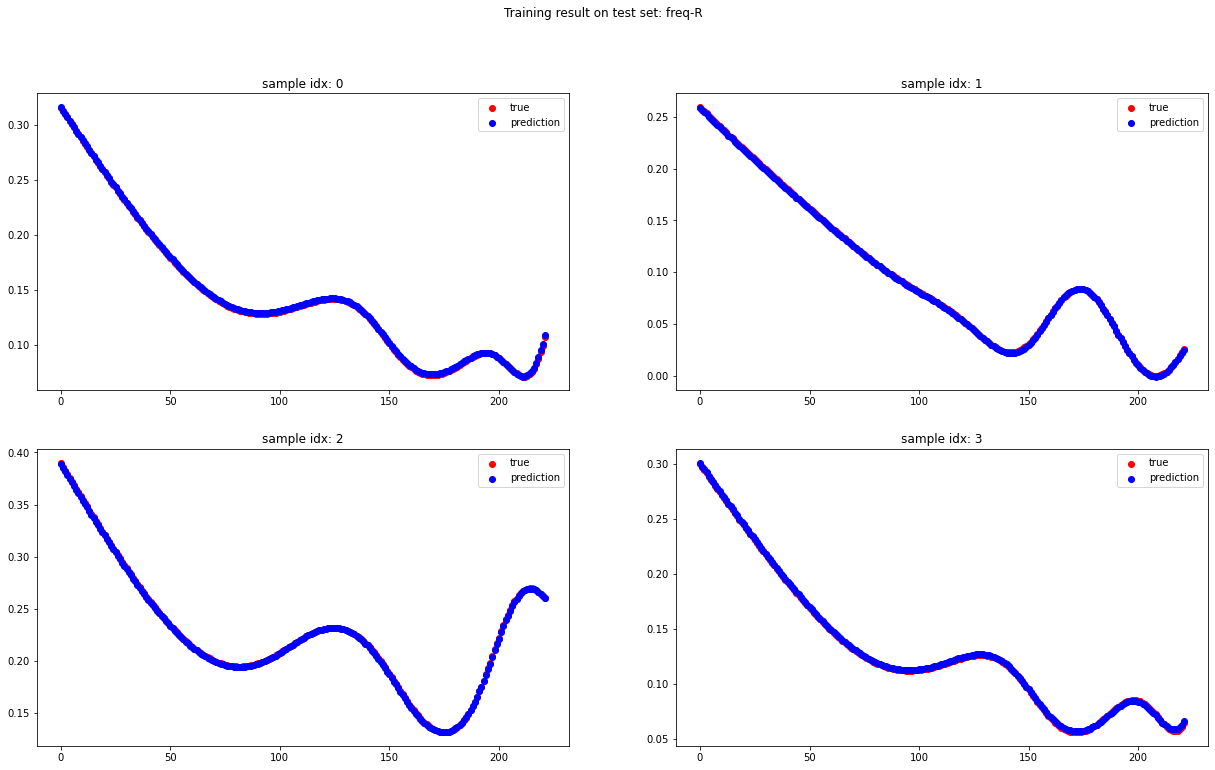

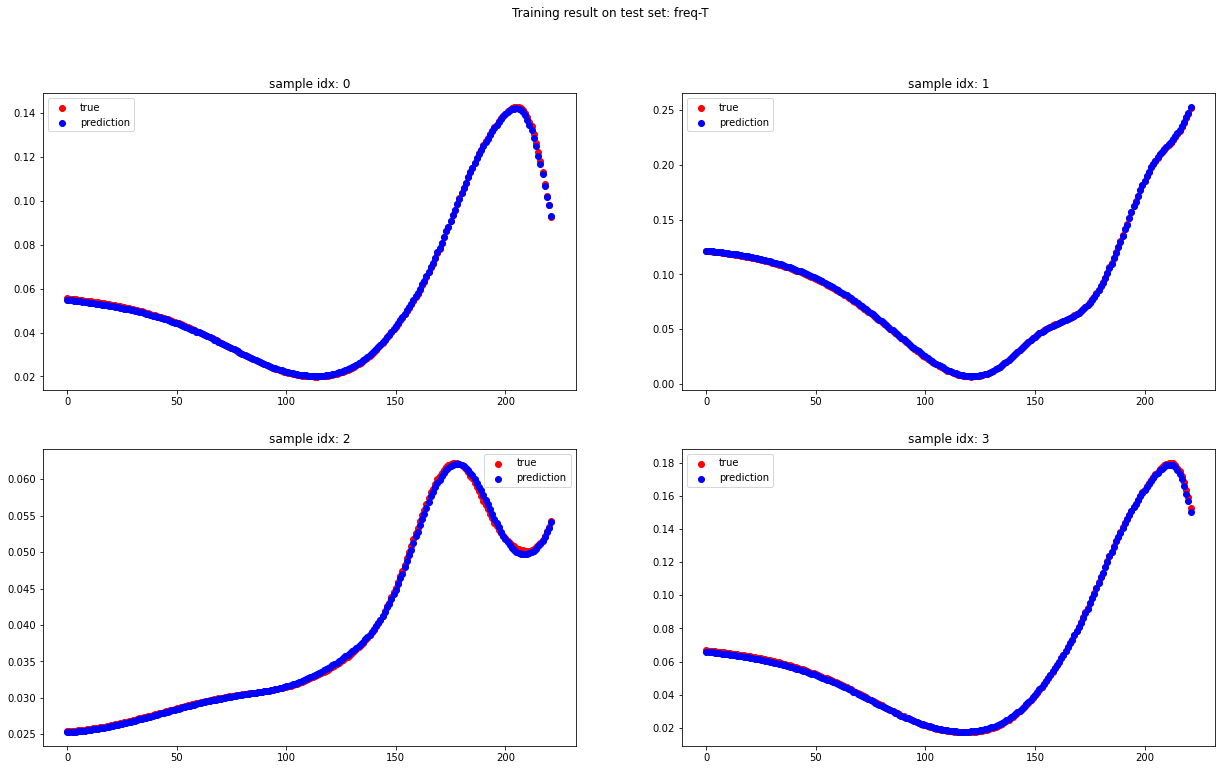

params_pick.shape: (10, 4)
params_pick: [[145. 121. 160.  75.]
 [145. 122. 160.  75.]
 [146. 121. 160.  75.]
 [146. 122. 160.  75.]
 [145. 120. 160.  75.]
 [147. 122. 160.  75.]
 [145. 123. 160.  75.]
 [146. 123. 160.  75.]
 [147. 121. 160.  75.]
 [146. 120. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


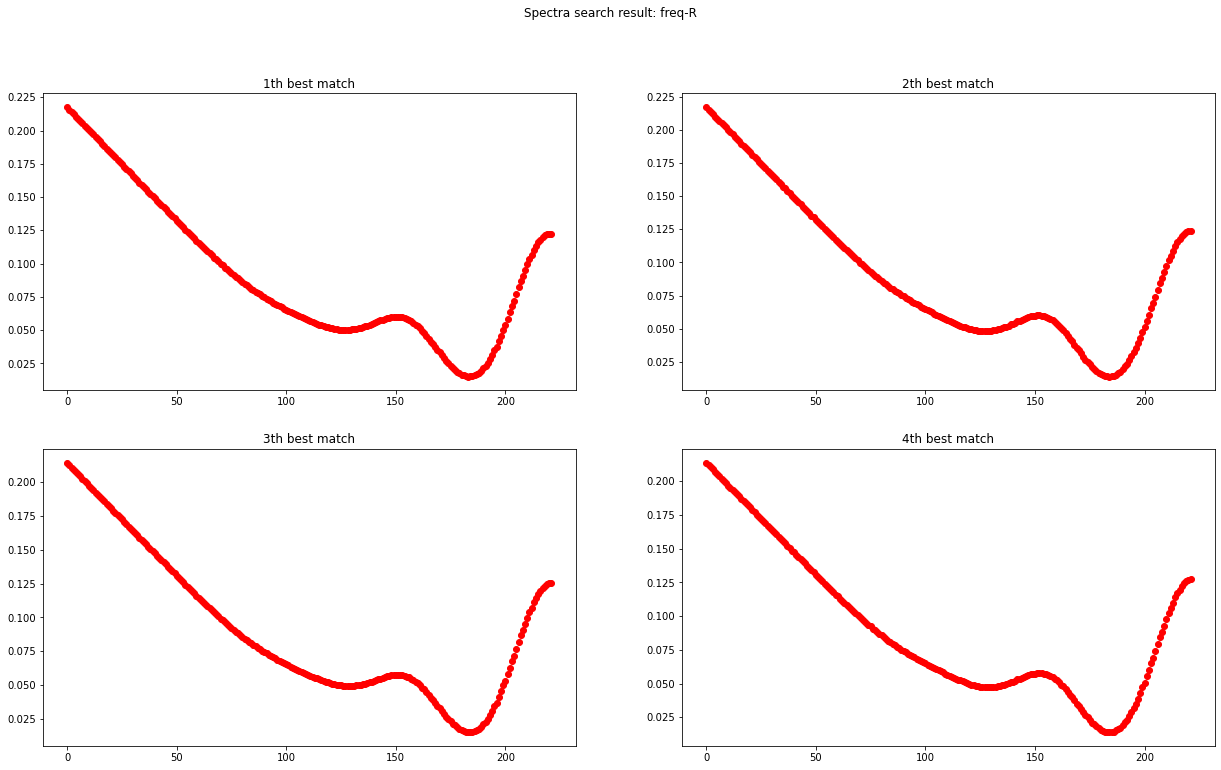

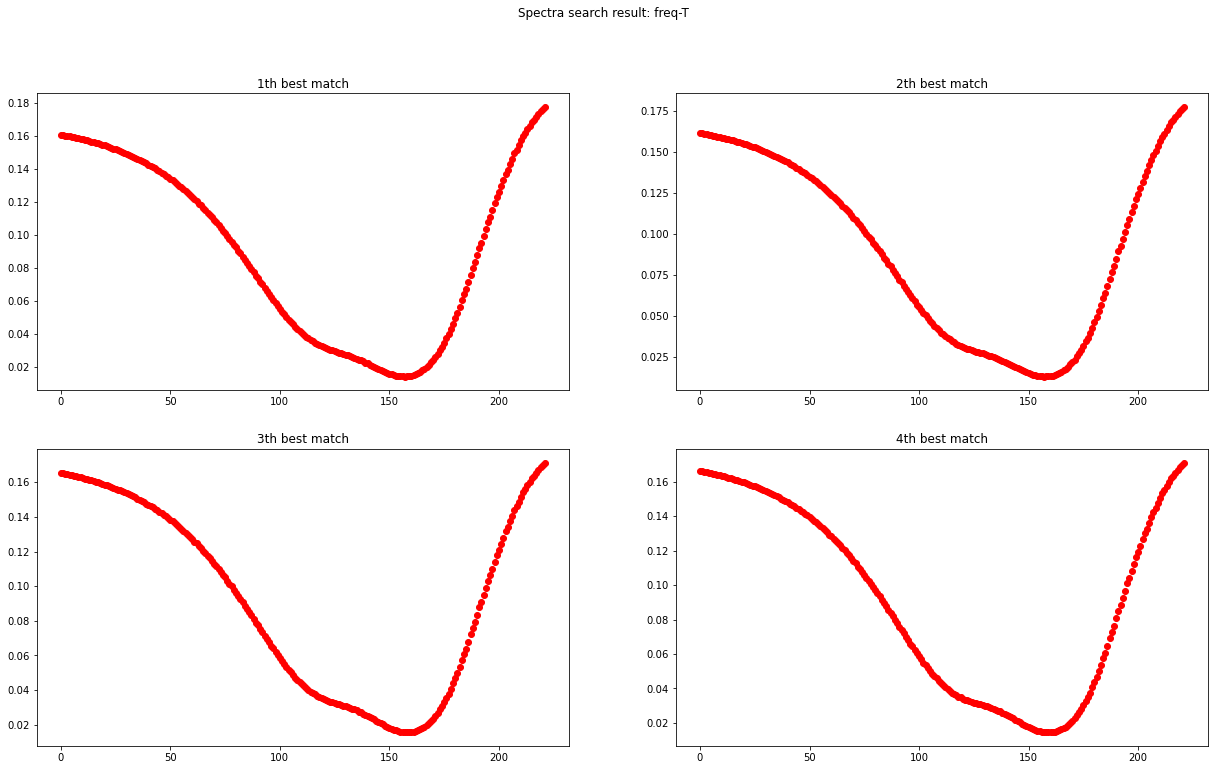

*** Reruning RCWA on picked params
params_dict.shape: (1020, 4)
R_dict.shape: (1020, 222)
T_dict.shape: (1020, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 120. 160.  75.] params_pick: [145. 120. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
---------

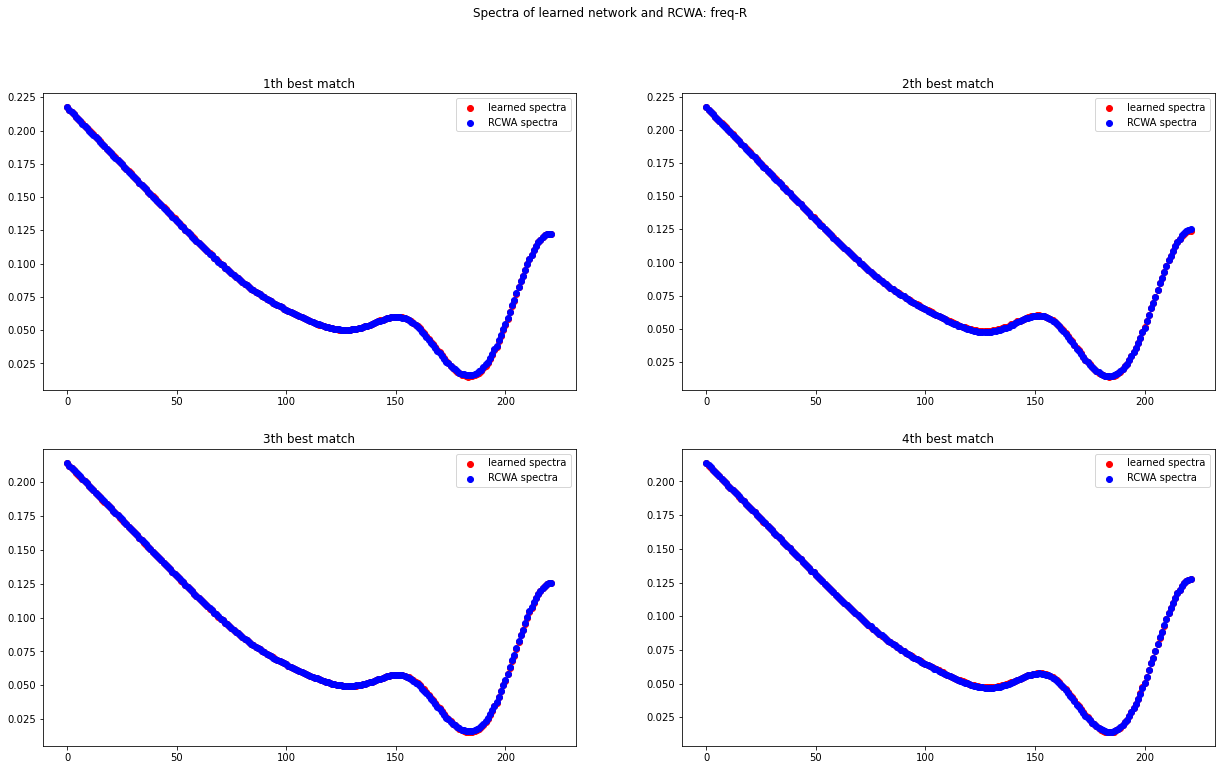

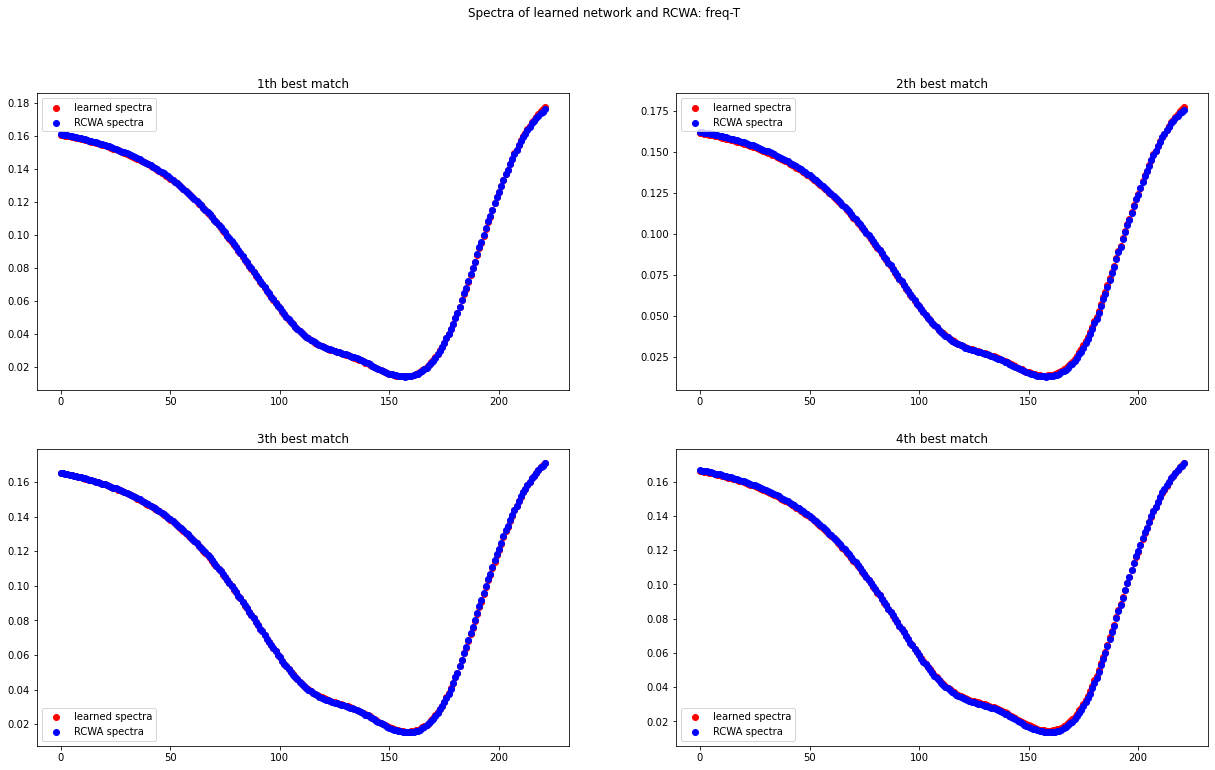

** Model saved.
**************************** ROUND 6 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1220
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [144.  73.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [109.  52.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [128.  85.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 56. 109.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 79. 120.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 61. 120.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [120. 147.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [81. 71.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [116. 132.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 85. 121.]
Calculation

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [123. 113.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [90. 56.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [120. 103.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [131.  81.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [133.  66.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [ 83. 103.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [82. 73.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 64. 132.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [142. 101.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 84. 144.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [99. 84.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 78. 110.]
Calculation Progress: 100%
-------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 3.5687652408699654e-05
### TEST LOSS  0.00013410758363438378
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 2.259443988928293e-05
### TEST LOSS  1.4440236937891887e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 1.0417457117087257e-05
### TEST LOSS  5.3256705158626e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 6.962643365286157e-06
### TEST LOSS  4.478334738833885e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 3.790659208764133e-06
### TEST LOSS  3.2504897382367697e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 9.168581713843234e-06
### TEST LOSS  4.005279139930376e-06
----------------------------------------------------------------------
**

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.525847896307117e-06
### TEST LOSS  2.865115926684475e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 2.3841910790260915e-06
### TEST LOSS  1.0961826941830191e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.5170813940056208e-06
### TEST LOSS  8.119746290073013e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.315105634032944e-06
### TEST LOSS  6.379184678974669e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.561455936434523e-06
### TEST LOSS  1.4162866782977578e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.0416738836343086e-06
### TEST LOSS  1.6909775919621576e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 2.3872910992010797e-06
### TEST LOSS  1.8290823893613906e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.599032473411607e-06
### TEST LOSS  2.8690966892578503e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.4359118945210003e-06
### TEST LOSS  9.23882109155353e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 9.422750495177211e-07
### TEST LOSS  7.301660233631418e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 8.397625260787286e-07
### TEST LOSS  1.4191245590585534e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.1443698437300579e-06
### TEST LOSS  9.442769264990746e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 1.2918255794217515e-06
### TEST LOSS  5.149435352043503e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 6.43619273333695e-07
### TEST LOSS  5.961173913324034e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 1.1620466210732115e-06
### TEST LOSS  8.484281759018287e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 2.1499785938865406e-06
### TEST LOSS  1.0307729511575752e-06
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.1334569831549343e-06
### TEST LOSS  6.210369867020697e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.312609801887248e-07
### TEST LOSS  8.465465749682871e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 5.967931711452235e-07
### TEST LOSS  3.445354792575017e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.462215035688503e-07
### TEST LOSS  4.38281380124145e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 5.256302137677285e-07
### TEST LOSS  4.594424377788336e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.557188973569875e-07
### TEST LOSS  5.174311916945092e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.660158939987083e-07
### TEST LOSS  4.846665358639401e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 6.07581735108e-07
### TEST LOSS  4.77118904104588e-07
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 6.098705808286052e-07
### TEST LOSS  9.327104740015401e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 1.1218037947516257e-06
### TEST LOSS  8.415499247635844e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.868556854751693e-07
### TEST LOSS  3.7965344440157137e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.551676943006018e-07
### TEST LOSS  5.672165816337694e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.837945707406534e-07
### TEST LOSS  4.792703736568097e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.156530512369703e-07
### TEST LOSS  4.5028423151530946e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 5.153377620826229e-07
### TEST LOSS  4.892760524686118e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.425332110384434e-07
### TEST LOSS  4.806257227061762e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 5.192213304231238e-07
### TEST LOSS  4.3758845884823177e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.777589323821508e-07
### TEST LOSS  5.400580960213119e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.475029306242456e-07
### TEST LOSS  4.6343365505364136e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.540237769046764e-07
### TEST LOSS  8.447726564123801e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 5.28505799569991e-07
### TEST LOSS  5.008969145891521e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.323929749303114e-07
### TEST LOSS  3.9798012464512125e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.371051429878852e-07
### TEST LOSS  3.420272432058961e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.841428514329541e-07
### TEST LOSS  4.0280584668930955e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 5.790339460980325e-07
### TEST LOSS  3.6444524946426483e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.93624399451222e-07
### TEST LOSS  3.4836040933776914e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 5.267699469396849e-07
### TEST LOSS  4.1264788227348806e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.808860513728622e-07
### TEST LOSS  3.738968964147429e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.5484651075657874e-07
### TEST LOSS  4.785172836220323e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 5.275267435235555e-07
### TEST LOSS  3.6520735067681114e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.290160055434898e-07
### TEST LOSS  4.013678727388699e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 1.036684444582228e-06
### TEST LOSS  4.847118101511833e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.0275206629710973e-07
### TEST LOSS  3.067805553918764e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.0854597548923824e-07
### TEST LOSS  2.8005523981726966e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.253915821591205e-07
### TEST LOSS  4.360119485107517e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.222046406040204e-07
### TEST LOSS  3.06980941158336e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.9276752977568024e-07
### TEST LOSS  5.470008764069988e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.234055041321273e-07
### TEST LOSS  4.854571246046123e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.3173710505095735e-07
### TEST LOSS  3.6383056567501626e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 5.164544730089029e-07
### TEST LOSS  6.021056330945086e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 5.248205300378293e-07
### TEST LOSS  3.3893385726083865e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.5915469128802487e-07
### TEST LOSS  4.700637188498628e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.6007831299464606e-07
### TEST LOSS  4.397089532248126e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.865338390259329e-07
### TEST LOSS  2.585100657513881e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.0182600697753553e-07
### TEST LOSS  4.1797111736597896e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.613076676606537e-07
### TEST LOSS  8.11603127347457e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.0671651407773215e-07
### TEST LOSS  3.524419059287634e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.825272333420582e-07
### TEST LOSS  2.785399752718532e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.2844432203421494e-07
### TEST LOSS  5.296129742012119e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.2411697156936855e-07
### TEST LOSS  7.860588587056171e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.1485927041942784e-07
### TEST LOSS  3.2141041341865756e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.9043287159523834e-07
### TEST LOSS  2.926309517043161e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.668159669549372e-07
### TEST LOSS  3.1323191469829525e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.082449837302168e-07
### TEST LOSS  2.8981500876350193e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.55283348234245e-07
### TEST LOSS  7.301210901364118e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.0480423620215705e-07
### TEST LOSS  3.33172838090353e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.2918320807712995e-07
### TEST LOSS  3.296520726567714e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.318518640764093e-07
### TEST LOSS  2.938547875206304e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.607375940286376e-07
### TEST LOSS  3.996664789060321e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.652488181078148e-07
### TEST LOSS  2.368963886343217e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.448874420122533e-07
### TEST LOSS  4.2800904584270795e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.741056750183516e-07
### TEST LOSS  3.808967595600016e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.960317108715909e-07
### TEST LOSS  3.136365448522395e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.412798366677409e-07
### TEST LOSS  2.7174783443378575e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.460932261012224e-07
### TEST LOSS  2.597852835307142e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 4.0233695651449645e-07
### TEST LOSS  3.7999114217774676e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.688073905521827e-07
### TEST LOSS  2.935609234997939e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.268097729966001e-07
### TEST LOSS  3.350062492676156e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.7502164430201517e-07
### TEST LOSS  2.9629620413336515e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.6344786403924306e-07
### TEST LOSS  6.721159727955015e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 6.591339950814546e-07
### TEST LOSS  3.838459861071897e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.923964529888957e-07
### TEST LOSS  3.008726288929833e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.4289959965231813e-07
### TEST LOSS  3.115368611504796e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.5175842755889884e-07
### TEST LOSS  2.391640573537906e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.1634159379443945e-07
### TEST LOSS  4.3324838004896024e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.1975299433208763e-07
### TEST LOSS  4.561300371326644e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.7794722199250233e-07
### TEST LOSS  3.2554556870117696e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.207876099544066e-07
### TEST LOSS  4.769775704229878e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.2367934041750496e-07
### TEST LOSS  3.198323421309779e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.6926309302684524e-07
### TEST LOSS  2.47633866628779e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.2626029942103523e-07
### TEST LOSS  3.2039778605657804e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.6004914588715554e-07
### TEST LOSS  2.494871034442488e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.2827078569176053e-07
### TEST LOSS  2.1486559974523276e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.026464461162389e-07
### TEST LOSS  2.992310335888473e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.126584498829044e-07
### TEST LOSS  2.3762671961130286e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.132835404196137e-07
### TEST LOSS  2.8840724709018677e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.381439837556109e-07
### TEST LOSS  3.937954916541218e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.7315135736467116e-07
### TEST LOSS  3.344789383007944e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.9408405105077335e-07
### TEST LOSS  2.731041034490102e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.14716648757625e-07
### TEST LOSS  2.4631516288608463e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.5266786299733076e-07
### TEST LOSS  3.8156214917475343e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.448048091739765e-07
### TEST LOSS  2.9216579752013975e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.098526178455191e-07
### TEST LOSS  2.3976348092889423e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.216383633776715e-07
### TEST LOSS  4.643533561408587e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.0328063092727996e-07
### TEST LOSS  3.699236132385857e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.2517847475111613e-07
### TEST LOSS  2.6801620459824146e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.2232002104568775e-07
### TEST LOSS  3.562955269767611e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.0627841080807744e-07
### TEST LOSS  3.3785798486381905e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.104225557696967e-07
### TEST LOSS  3.023117038106935e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.2089517846005774e-07
### TEST LOSS  3.7571904511567385e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.306132184706538e-07
### TEST LOSS  2.0004408889618438e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.9915760742215703e-07
### TEST LOSS  2.3309456316000202e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.223403729057757e-07
### TEST LOSS  3.428019472027556e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.5075834378645487e-07
### TEST LOSS  4.1187512591166427e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.1890157898293524e-07
### TEST LOSS  3.1674150217273375e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.1900183772777513e-07
### TEST LOSS  2.1158605309928566e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.599662509780037e-07
### TEST LOSS  3.9617691976146535e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.2724116572942925e-07
### TEST LOSS  2.893422046518505e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.477707409451963e-07
### TEST LOSS  5.428510196213066e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.8735630238440804e-07
### TEST LOSS  2.677999894355085e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.2779655555317764e-07
### TEST LOSS  6.092451844539793e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.0761346300219196e-07
### TEST LOSS  2.547161168302792e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.981065348147009e-07
### TEST LOSS  2.728358503801294e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.8294360696004686e-07
### TEST LOSS  2.5536500839064645e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.83540671821715e-07
### TEST LOSS  2.7776733858038487e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.8963515589685944e-07
### TEST LOSS  2.934758064635676e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.035281546337294e-07
### TEST LOSS  2.1490211939803167e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.902835760268351e-07
### TEST LOSS  2.755180108387752e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.040792970106391e-07
### TEST LOSS  2.3251164437074054e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.833391104020654e-07
### TEST LOSS  3.580508704496759e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.855972781139034e-07
### TEST LOSS  2.300487544085914e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.6700800056056646e-07
### TEST LOSS  2.5719586984139726e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.7503928796981706e-07
### TEST LOSS  2.6103351714075533e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.6826832266240264e-07
### TEST LOSS  6.115121478662906e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.1810736927946774e-07
### TEST LOSS  2.716223787645408e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.991082673156574e-07
### TEST LOSS  2.3767054738312397e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.049675669971662e-07
### TEST LOSS  3.7448983161275945e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.9025492319881956e-07
### TEST LOSS  3.069495306817771e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.1938528002135665e-07
### TEST LOSS  2.4652317614182767e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.900320509630345e-07
### TEST LOSS  3.94877778382196e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.210480349765731e-07
### TEST LOSS  4.4638488218065744e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.362438623576818e-07
### TEST LOSS  4.4117282982369943e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.028190547307078e-07
### TEST LOSS  2.3337849902897064e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.0158284665199957e-07
### TEST LOSS  3.228437366799067e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.0058189725213154e-07
### TEST LOSS  2.2590905314844255e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.859423963007553e-07
### TEST LOSS  2.463689165659544e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.941285739832908e-07
### TEST LOSS  2.802350886548466e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.372009271355661e-07
### TEST LOSS  2.724695222193412e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.8621743489229276e-07
### TEST LOSS  1.855424613950163e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.069702299448457e-07
### TEST LOSS  3.675297424060294e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.2031064153263516e-07
### TEST LOSS  2.640061437300813e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.7473319610830595e-07
### TEST LOSS  1.8402599790222572e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.047886439932488e-07
### TEST LOSS  2.387492118391253e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.755389987518604e-07
### TEST LOSS  3.2747069224713317e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.8418449953780976e-07
### TEST LOSS  2.1917314840218176e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.3040234820441445e-07
### TEST LOSS  2.4131445062075247e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.753811574839356e-07
### TEST LOSS  2.2892225023210095e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.8888014824264904e-07
### TEST LOSS  3.460855312273213e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.7149554819678805e-07
### TEST LOSS  2.5520576304858735e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.643422036323726e-07
### TEST LOSS  2.0993361491300197e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.7897928883017724e-07
### TEST LOSS  2.6497821555662274e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.8940999812319527e-07
### TEST LOSS  6.259727979939175e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.7014547079900575e-07
### TEST LOSS  3.3511423530877723e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.1110359925796765e-07
### TEST LOSS  2.0623916142133232e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.00971464454672e-07
### TEST LOSS  2.543467281001492e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.6190818440212394e-07
### TEST LOSS  2.1819827030580391e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.7812520986743284e-07
### TEST LOSS  2.4808378677670063e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.958538164094426e-07
### TEST LOSS  2.647436885856797e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.9757641112694827e-07
### TEST LOSS  2.475226786576681e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.7399887583741376e-07
### TEST LOSS  1.803560491596631e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.8665004328074906e-07
### TEST LOSS  2.7492286921857924e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.574852997221305e-07
### TEST LOSS  2.1054586490639563e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.0095123744480526e-07
### TEST LOSS  4.4457395556731314e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.7722064794552753e-07
### TEST LOSS  2.478004866564956e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.600345569966228e-07
### TEST LOSS  2.3477939237182e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.86825229150203e-07
### TEST LOSS  3.6492616423426e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.208686541647293e-07
### TEST LOSS  2.545745542791242e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 5.330892163010247e-07
### TEST LOSS  6.305326693516116e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 4.791923794597631e-07
### TEST LOSS  2.734999094101161e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.7370420089067506e-07
### TEST LOSS  4.2369312699233167e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 3.5638372760714775e-07
### TEST LOSS  3.601218108279251e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.1400441269660344e-07
### TEST LOSS  3.463747460548467e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.836951754578295e-07
### TEST LOSS  2.498677673656857e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.5736815758788636e-07
### TEST LOSS  3.2326910645439823e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.727739651465031e-07
### TEST LOSS  4.054613184148605e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.9741249702571255e-07
### TEST LOSS  2.8258886393479387e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 4.222483711750973e-07
### TEST LOSS  3.8821941179896e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.762842079075918e-07
### TEST LOSS  3.334530955917695e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.757801536258538e-07
### TEST LOSS  4.611687649302391e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.9166357014595795e-07
### TEST LOSS  4.7617193313511195e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.4935901119348595e-07
### TEST LOSS  3.8523091318079663e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.844609369078536e-07
### TEST LOSS  6.754126547404763e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 3.025073453416243e-07
### TEST LOSS  2.1704931896238122e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 3.0039480235153933e-07
### TEST LOSS  6.781726226204467e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.9874337034618653e-07
### TEST LOSS  2.5901715616782894e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.991622156994869e-07
### TEST LOSS  3.2453664738041926e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.717639923169085e-07
### TEST LOSS  2.3415562335877007e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 4.254958707922232e-07
### TEST LOSS  2.2173593917709935e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.6026620721330015e-07
### TEST LOSS  3.8910465231143273e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.80002729029068e-07
### TEST LOSS  3.646255956817568e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.578269216485063e-07
### TEST LOSS  3.1612438907526855e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.7357097503919494e-07
### TEST LOSS  2.880679891117516e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.590388722233765e-07
### TEST LOSS  3.189614658008634e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.817737584024954e-07
### TEST LOSS  2.1731001484831245e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.9289273584545465e-07
### TEST LOSS  2.6635004919745896e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.5988358541894276e-07
### TEST LOSS  2.0286835117052474e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.809632861725476e-07
### TEST LOSS  2.569359854700643e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.781115857797824e-07
### TEST LOSS  2.94802429392037e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.9158505706125414e-07
### TEST LOSS  3.0959436595654363e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.7461512124548623e-07
### TEST LOSS  2.7959543489798404e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.7265795446857195e-07
### TEST LOSS  2.095238651116616e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.6166127387075896e-07
### TEST LOSS  2.0061127926103502e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.509544279253991e-07
### TEST LOSS  1.6984225861972988e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.5822346827937526e-07
### TEST LOSS  1.039324184890383e-06
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.004794346192178e-07
### TEST LOSS  4.925339956236329e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 3.013433420202076e-07
### TEST LOSS  2.043838453334358e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.7584841648628193e-07
### TEST LOSS  3.1209562373054437e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.680276806794139e-07
### TEST LOSS  2.0340953267948768e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.574903604550197e-07
### TEST LOSS  2.744425722467943e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.723994847653723e-07
### TEST LOSS  2.584126204247265e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.871748034082682e-07
### TEST LOSS  3.3542190031336135e-07
** loss_train 2.871748034082682e-07
** loss_test 3.3542190031336135e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


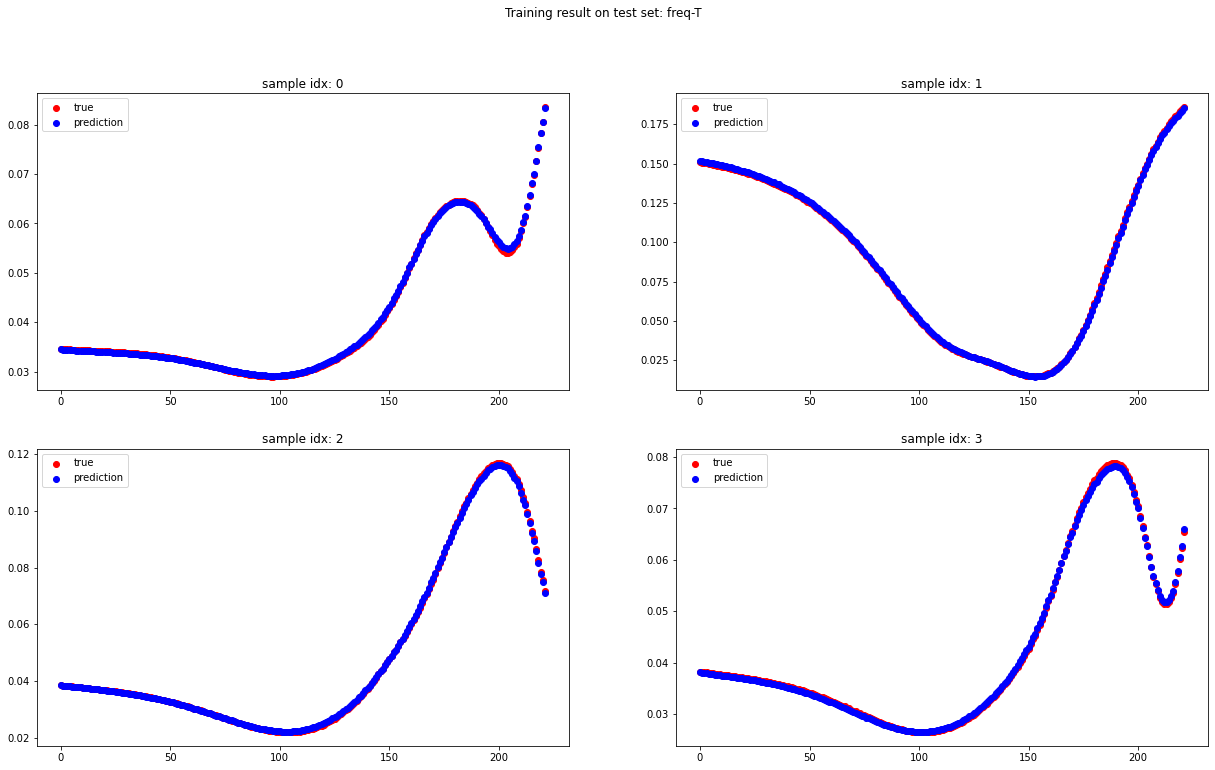

params_pick.shape: (10, 4)
params_pick: [[145. 121. 160.  75.]
 [146. 121. 160.  75.]
 [145. 120. 160.  75.]
 [145. 122. 160.  75.]
 [144. 121. 160.  75.]
 [147. 121. 160.  75.]
 [146. 120. 160.  75.]
 [146. 122. 160.  75.]
 [147. 120. 160.  75.]
 [147. 122. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


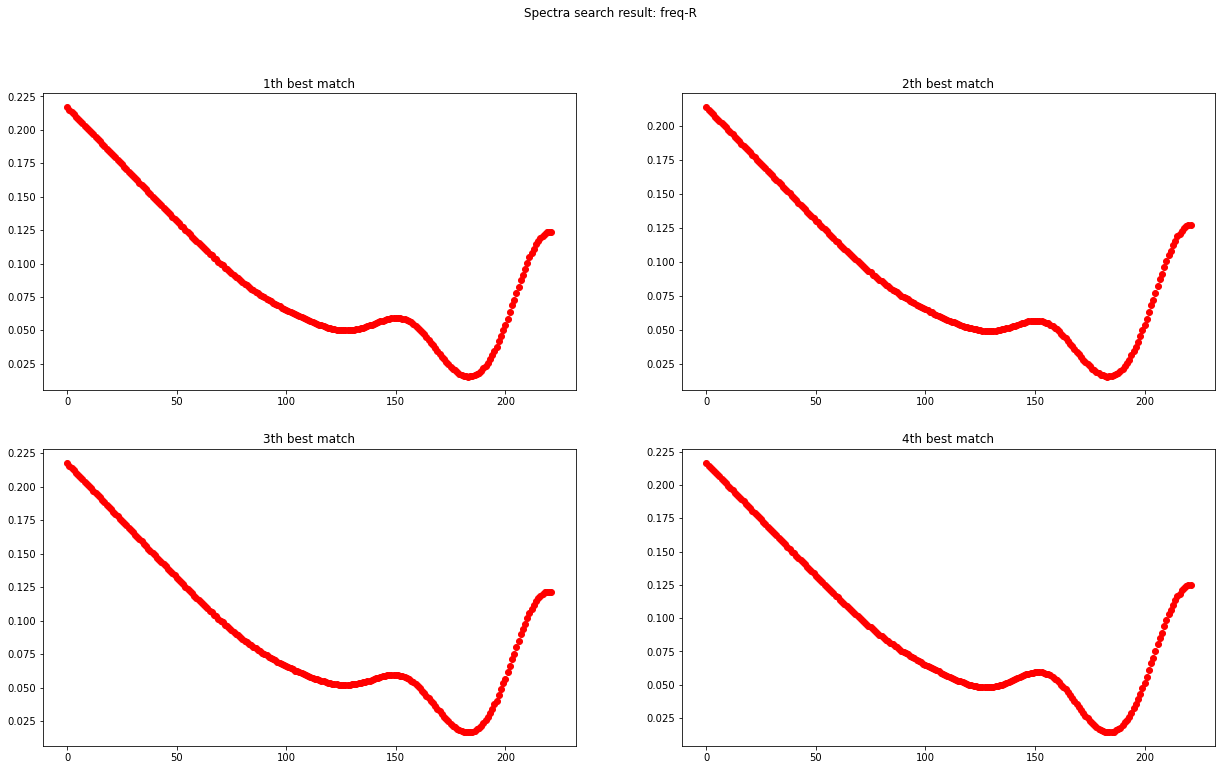

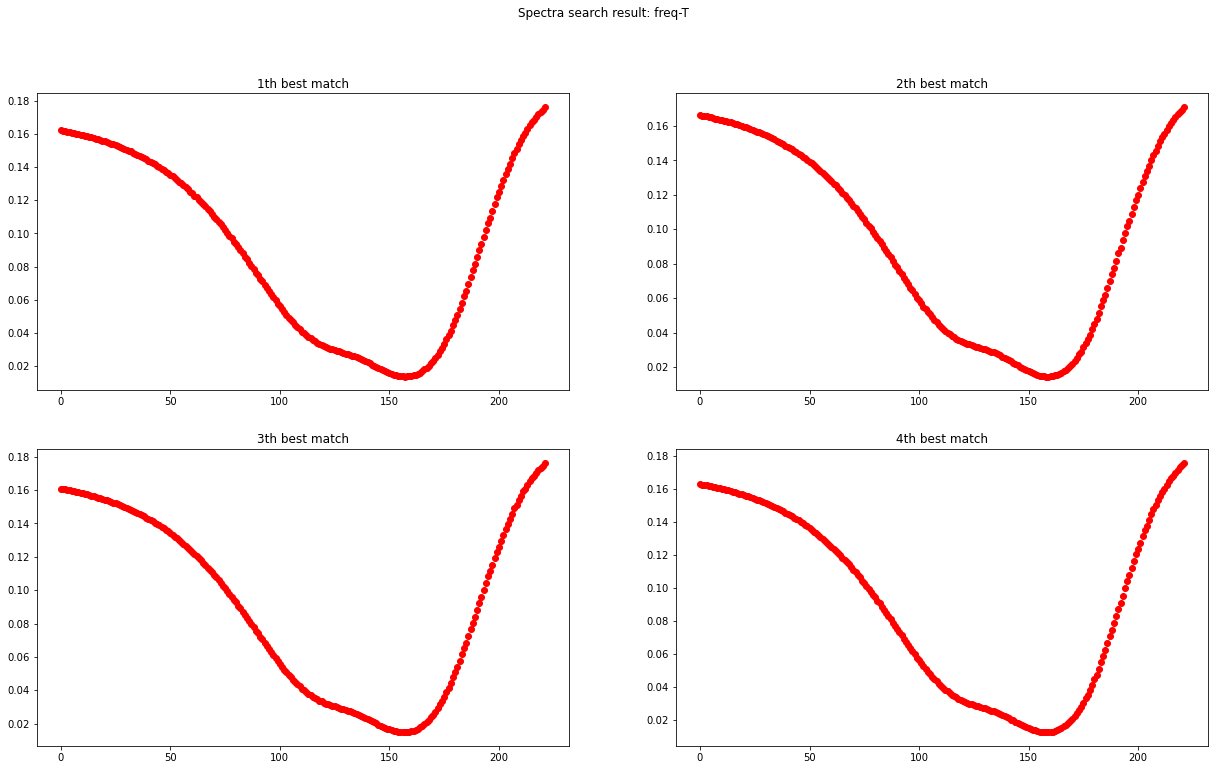

*** Reruning RCWA on picked params
params_dict.shape: (1220, 4)
R_dict.shape: (1220, 222)
T_dict.shape: (1220, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [145. 120. 160.  75.] params_pick: [145. 120. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
5 th match
Not in the dict, calling RCWA...
# params_pick: [144. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
6 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [146. 120. 160.  7

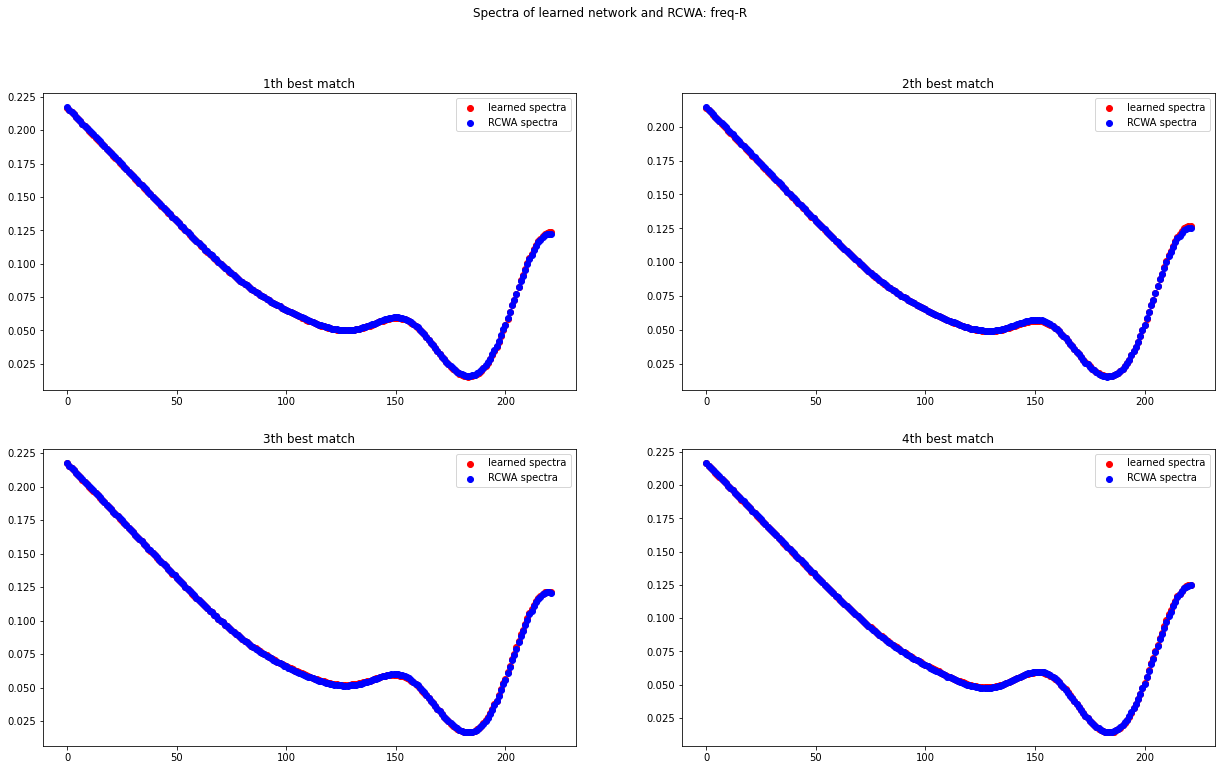

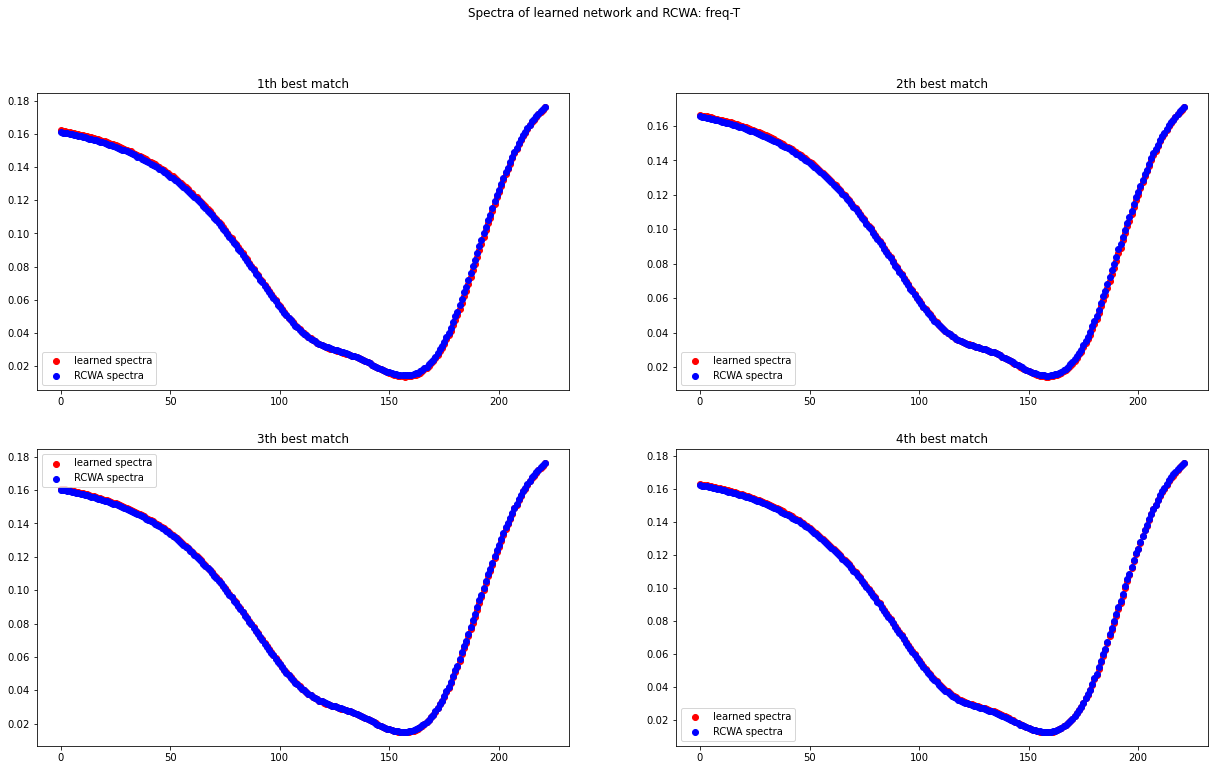

** Model saved.
**************************** ROUND 7 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1421
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [122. 143.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [108. 145.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [64. 84.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [132. 130.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [126. 115.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 76. 116.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [64. 57.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [150. 125.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [124. 112.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [101. 135.]
Calculation P

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 80. 128.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [146.  63.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [101.  72.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [132.  79.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [101.  92.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [123. 136.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [111. 137.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [112. 120.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [137.  65.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [126. 125.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [100.  55.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 89. 127.]
Calculation Progress: 100%
-

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 3.892064497835393e-05
### TEST LOSS  0.00011755253349706022
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.2133727839537122e-05
### TEST LOSS  3.6064520724142892e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 4.8787876472214826e-06
### TEST LOSS  4.456944132223064e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 4.596579714328928e-06
### TEST LOSS  2.7149265571841337e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.3921129453361876e-06
### TEST LOSS  2.28258066540961e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 2.233607113465618e-06
### TEST LOSS  1.2271950631450388e-06
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 5.578501245295547e-07
### TEST LOSS  7.900322833103762e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 7.069301929628633e-07
### TEST LOSS  4.911723423943344e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 6.864303829719659e-07
### TEST LOSS  1.1198706240313847e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.2153318971930392e-06
### TEST LOSS  7.382358210799628e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.1005097843300326e-06
### TEST LOSS  8.009803206153844e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 8.766871358241516e-07
### TEST LOSS  6.202903558067357e-07
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.735716624884982e-06
### TEST LOSS  6.427954585578018e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 7.13791907144778e-07
### TEST LOSS  5.66374707618293e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 6.018440267131575e-07
### TEST LOSS  5.542545409298327e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 5.074225071261356e-07
### TEST LOSS  1.1495724446707423e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 8.095018482192135e-07
### TEST LOSS  6.338707033199337e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 5.045794705710327e-07
### TEST LOSS  4.1251522408071073e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 4.634629029953973e-07
### TEST LOSS  5.07497103089091e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 4.2477081741830236e-07
### TEST LOSS  4.90706257365177e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 4.2745001511427844e-07
### TEST LOSS  5.137392559039323e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 3.764895087976302e-07
### TEST LOSS  3.176819983640268e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 4.6033102777052466e-07
### TEST LOSS  5.379698341750389e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 4.7008619581240286e-07
### TEST LOSS  3.8673799387176833e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 3.747240317300964e-07
### TEST LOSS  2.6352216247522103e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 4.3200190307990165e-07
### TEST LOSS  7.230644999109163e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 4.1981214191259683e-07
### TEST LOSS  3.803399331238986e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 4.5354025706052183e-07
### TEST LOSS  4.259859193470303e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 4.5604896078459783e-07
### TEST LOSS  3.5274317414487916e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 3.9541730101914885e-07
### TEST LOSS  3.439711313355722e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.227917660377912e-07
### TEST LOSS  3.5967689045306045e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 3.6136018580343736e-07
### TEST LOSS  3.8191027520249254e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 3.884780480436452e-07
### TEST LOSS  3.696099368384735e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.1224254963018714e-07
### TEST LOSS  5.1563180198338e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 3.750172545298007e-07
### TEST LOSS  3.153837582203778e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 3.803603577432512e-07
### TEST LOSS  4.254390869494852e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.635572840184267e-07
### TEST LOSS  2.8016519916139837e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.7859704270825335e-07
### TEST LOSS  4.461973449307069e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 3.548399546676009e-07
### TEST LOSS  7.023582652850151e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.5892664998535276e-07
### TEST LOSS  3.5276514154247707e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.8256223153046846e-07
### TEST LOSS  3.5851004363187466e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.3076432923844217e-07
### TEST LOSS  2.371305614898037e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.586886009828395e-07
### TEST LOSS  3.8898213910504803e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.9225164891525794e-07
### TEST LOSS  3.043037227453996e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.278987428070717e-07
### TEST LOSS  2.988882373115716e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.263670217888505e-07
### TEST LOSS  3.0779986559537065e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.565391973414515e-07
### TEST LOSS  2.9398822285677606e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.3516201166058663e-07
### TEST LOSS  4.599023862345513e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.4720388778706085e-07
### TEST LOSS  3.9037047889161675e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.066301228234163e-07
### TEST LOSS  2.2393929619759298e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.187683947288873e-07
### TEST LOSS  5.678688691804464e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.2069533818910533e-07
### TEST LOSS  2.713766530281315e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.355531733195967e-07
### TEST LOSS  3.2570158416753903e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.3116384805009516e-07
### TEST LOSS  2.4467646785420916e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.3258121571800716e-07
### TEST LOSS  3.203420765823301e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 2.9175200129529475e-07
### TEST LOSS  2.7265839267184594e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.4246385776933967e-07
### TEST LOSS  3.3251080046945636e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.4650138186467677e-07
### TEST LOSS  3.3964536976844267e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 2.967565306251393e-07
### TEST LOSS  3.301458829954837e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 2.850259676014149e-07
### TEST LOSS  2.756011351256017e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.311477062392421e-07
### TEST LOSS  3.261540022301481e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 2.997778858002575e-07
### TEST LOSS  3.1031398412489414e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 2.9348974545107606e-07
### TEST LOSS  3.401326825848049e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.1569220860969903e-07
### TEST LOSS  3.0984690433590667e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.1389890812246914e-07
### TEST LOSS  2.0424392359204416e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.0042990726374195e-07
### TEST LOSS  2.1095760613124268e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.426432129904517e-07
### TEST LOSS  4.362817313883418e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 2.966358049340642e-07
### TEST LOSS  2.396092239368128e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.280660536962745e-07
### TEST LOSS  2.2168916431879057e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.9951103171650585e-07
### TEST LOSS  2.4202346018207455e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 2.976463386391018e-07
### TEST LOSS  3.619745660382085e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.2757298776695816e-07
### TEST LOSS  3.002509316729629e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.1785865911262454e-07
### TEST LOSS  2.8637740776751097e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.849118086011239e-07
### TEST LOSS  4.5586149739888654e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.0775935280225865e-07
### TEST LOSS  2.693641860673779e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.0622563262275794e-07
### TEST LOSS  2.9149334905427665e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.915003812702991e-07
### TEST LOSS  2.715326507479238e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.9470206468005145e-07
### TEST LOSS  2.894592609240218e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.390982671425992e-07
### TEST LOSS  2.6110973875988336e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.856179820682644e-07
### TEST LOSS  5.870805520916375e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.1241770553894105e-07
### TEST LOSS  2.334887586708977e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 2.920295747437651e-07
### TEST LOSS  2.444991202630511e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.6935109505251574e-07
### TEST LOSS  2.7082230567223386e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 2.7066818261780735e-07
### TEST LOSS  2.6714552089660254e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 2.792494337254252e-07
### TEST LOSS  4.712325159578706e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.0851611201167994e-07
### TEST LOSS  3.334333006870855e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.900019377910633e-07
### TEST LOSS  3.078898164300302e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 2.9143632990666475e-07
### TEST LOSS  3.37004496874339e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 2.896059188449106e-07
### TEST LOSS  2.2686569293868655e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.8877180844714436e-07
### TEST LOSS  2.546198978527834e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 2.8213009788739934e-07
### TEST LOSS  2.2702198844047994e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 2.793018554833442e-07
### TEST LOSS  2.8262820964383456e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.4125993693923794e-07
### TEST LOSS  3.790406333853918e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 2.781542192547431e-07
### TEST LOSS  2.60151658437735e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 2.815878487324463e-07
### TEST LOSS  2.0704649211273302e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 2.9926912034418945e-07
### TEST LOSS  2.291712988267136e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.7082319394725026e-07
### TEST LOSS  2.2263695727402097e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 2.914248936513285e-07
### TEST LOSS  2.723589622116213e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.2879209205527254e-07
### TEST LOSS  6.690638785626519e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.1801035500640975e-07
### TEST LOSS  2.83769321899027e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.719199385687137e-07
### TEST LOSS  2.972506623874241e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.704964641572601e-07
### TEST LOSS  1.9177349227819915e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.696853894062283e-07
### TEST LOSS  4.180941485546183e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.704651429421883e-07
### TEST LOSS  2.6333956591108953e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.7084680847255146e-07
### TEST LOSS  3.048178604878806e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 2.698443521358291e-07
### TEST LOSS  5.198390908844885e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.687355342807182e-07
### TEST LOSS  1.9861944622334704e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.6294156068206226e-07
### TEST LOSS  2.7877579226883015e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.7792296055563417e-07
### TEST LOSS  2.5022272480286617e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 2.943567789115076e-07
### TEST LOSS  2.4361251408064083e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.6580911342169676e-07
### TEST LOSS  3.0652313463199543e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.788119403422827e-07
### TEST LOSS  2.254843926927854e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.6209915709925046e-07
### TEST LOSS  2.576870834693843e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.044351254772842e-07
### TEST LOSS  2.90937585780491e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.574237856916866e-07
### TEST LOSS  3.2707137103732914e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.8248847438203797e-07
### TEST LOSS  3.0198411593573837e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.665959141190099e-07
### TEST LOSS  2.955624122013102e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.707839001351647e-07
### TEST LOSS  2.5335610005909487e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.6254913645961503e-07
### TEST LOSS  3.2062797830886586e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.5391295093545375e-07
### TEST LOSS  4.883968268193878e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.5541227270626456e-07
### TEST LOSS  2.170400670500137e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.8384180986371905e-07
### TEST LOSS  1.8354342562981235e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.5547475780819574e-07
### TEST LOSS  1.90437972300763e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.676189029494139e-07
### TEST LOSS  4.518809969443861e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.7305106828827695e-07
### TEST LOSS  1.9929968301953108e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.523086173786843e-07
### TEST LOSS  1.9647796278832175e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 5.909317773008479e-07
### TEST LOSS  4.721630220542879e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.628970697471839e-07
### TEST LOSS  2.922704948363472e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.4871727302497225e-07
### TEST LOSS  2.9198649801029125e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.270314879683253e-07
### TEST LOSS  2.747781638587102e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.5088027140922974e-07
### TEST LOSS  1.809464616929869e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.900983110287044e-07
### TEST LOSS  3.471264823867221e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.505088763878388e-07
### TEST LOSS  3.1943708478365807e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.3198405373301956e-07
### TEST LOSS  2.0028089732125987e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.932470895789815e-07
### TEST LOSS  1.761777632871351e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.911406321343526e-07
### TEST LOSS  2.2971837733042444e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.522591209104576e-07
### TEST LOSS  3.489858254500756e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.55141216081e-07
### TEST LOSS  2.304973459775862e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.3900649651199353e-07
### TEST LOSS  2.4680718010730823e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.667095332051566e-07
### TEST LOSS  2.1768926798544766e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.548945225473094e-07
### TEST LOSS  2.491792275546603e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.5471021210191427e-07
### TEST LOSS  2.1742480333324982e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.7479807362357406e-07
### TEST LOSS  2.265572838020737e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.547241195446307e-07
### TEST LOSS  2.8693324338746606e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.563892850439016e-07
### TEST LOSS  5.186277679637318e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.5154049435849445e-07
### TEST LOSS  2.3044889665222648e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.388920328175477e-07
### TEST LOSS  4.145863347172384e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.4463642630919646e-07
### TEST LOSS  3.0488236420338083e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.395289708300844e-07
### TEST LOSS  1.8733602757947665e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.9157151640748865e-07
### TEST LOSS  2.26295715580446e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.522365533406258e-07
### TEST LOSS  2.775445567108777e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.5213298105124606e-07
### TEST LOSS  2.3102599494057524e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.522932204213807e-07
### TEST LOSS  1.9862753607536765e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.400601937293607e-07
### TEST LOSS  4.079762628738205e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.447101983062306e-07
### TEST LOSS  1.9025138184050858e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.5906096401516225e-07
### TEST LOSS  4.339692635953311e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.437650124690559e-07
### TEST LOSS  1.9871423585403714e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.366049717192196e-07
### TEST LOSS  1.9266404197279288e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.403717151408893e-07
### TEST LOSS  2.1027074126322987e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.576688737025627e-07
### TEST LOSS  2.4913324252069785e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.61627535444705e-07
### TEST LOSS  2.911798466181443e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.8050420847914814e-07
### TEST LOSS  2.9725363633174723e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.5366554054989785e-07
### TEST LOSS  2.968330221619908e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.4936605619139906e-07
### TEST LOSS  2.37513868936193e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.5555176784373247e-07
### TEST LOSS  2.1135807706038825e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.42725440830025e-07
### TEST LOSS  2.0604268448985089e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.2717056050183609e-07
### TEST LOSS  2.4009551550947933e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.6455926916701984e-07
### TEST LOSS  1.825576406004488e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.3517607044136587e-07
### TEST LOSS  2.616733186497103e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.449711502174947e-07
### TEST LOSS  2.1069488037090361e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.2689540738268699e-07
### TEST LOSS  2.0741986875546817e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.8041951320013064e-07
### TEST LOSS  2.260801588766464e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.5105765530677605e-07
### TEST LOSS  1.822218691090298e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 7.206750714018125e-07
### TEST LOSS  6.347851834479198e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.3457919694601899e-07
### TEST LOSS  2.0878239000281115e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.655702249949461e-07
### TEST LOSS  3.0895586242898143e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.444091725197138e-07
### TEST LOSS  4.3350652586840705e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.648705202435391e-07
### TEST LOSS  1.8949119606759268e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.6089255472661673e-07
### TEST LOSS  2.0501223668196128e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.646078284551297e-07
### TEST LOSS  4.920041347263164e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.4172241785672216e-07
### TEST LOSS  1.9945305302309696e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.504373165838575e-07
### TEST LOSS  2.9131929256788103e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.54929739894215e-07
### TEST LOSS  2.4883398129883394e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.6168447889208207e-07
### TEST LOSS  2.186732450065227e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.5084034478658367e-07
### TEST LOSS  1.606970401594894e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.134008660815739e-07
### TEST LOSS  4.15954998929506e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.350828006166303e-07
### TEST LOSS  1.8347670276015873e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.2765933266540293e-07
### TEST LOSS  3.16936057681067e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.3501294791407307e-07
### TEST LOSS  2.075353739366454e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.3354756260312859e-07
### TEST LOSS  4.4007765738611354e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.510195081574068e-07
### TEST LOSS  2.0958339903968823e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.4964965770117863e-07
### TEST LOSS  2.1910273514694464e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.285208362182369e-07
### TEST LOSS  3.183407799993306e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.458502906948557e-07
### TEST LOSS  2.1912697046776553e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.509919000106583e-07
### TEST LOSS  1.9953985033990565e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.2683292447463776e-07
### TEST LOSS  3.6907008972196886e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.432439197565621e-07
### TEST LOSS  2.469398713794197e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.6186341839069035e-07
### TEST LOSS  2.4320351728461404e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.284499227356288e-07
### TEST LOSS  2.1749116091934245e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.4157313675192497e-07
### TEST LOSS  2.1773800217384964e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.2930496327849353e-07
### TEST LOSS  2.450565029283263e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.6549679511723885e-07
### TEST LOSS  2.2584090428071332e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.489438723378018e-07
### TEST LOSS  2.343371505730829e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.389853817482911e-07
### TEST LOSS  2.3406611404652722e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.2728314427821383e-07
### TEST LOSS  2.6890875465762126e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.2927296579524736e-07
### TEST LOSS  1.846364625635033e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.3677582331262887e-07
### TEST LOSS  2.0035453151091465e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.464080932277703e-07
### TEST LOSS  1.8813866892680214e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.3391192488028352e-07
### TEST LOSS  5.356058907905621e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.3647694364894115e-07
### TEST LOSS  3.015617919417805e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.299240407355529e-07
### TEST LOSS  2.5651201696064163e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.2121254376739212e-07
### TEST LOSS  2.1271695322349676e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.3862344221935294e-07
### TEST LOSS  2.9610899397105395e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.2835851262774635e-07
### TEST LOSS  1.8288216161656898e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.2203809187330228e-07
### TEST LOSS  2.80571498478821e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.2810527564299828e-07
### TEST LOSS  4.3200603660021775e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.3044891070898102e-07
### TEST LOSS  1.9797717857014421e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.5314532491640616e-07
### TEST LOSS  2.4745950097130015e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.2882185175538724e-07
### TEST LOSS  1.9018763905168354e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.375906754883548e-07
### TEST LOSS  3.133630844910261e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.239822123466358e-07
### TEST LOSS  2.1563602362303672e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.411378005172746e-07
### TEST LOSS  1.8609040417707298e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.194601670559073e-07
### TEST LOSS  2.2380362387573108e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.372945177496279e-07
### TEST LOSS  2.2463089392617389e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.426136321202638e-07
### TEST LOSS  2.7575281339150853e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.564199801188141e-07
### TEST LOSS  1.6662152740371478e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.3425424272907112e-07
### TEST LOSS  1.7763113840436e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.2060199772783185e-07
### TEST LOSS  2.72839710905001e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 3.6518003865563635e-07
### TEST LOSS  2.7767932147588165e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.8931956631592033e-07
### TEST LOSS  3.3914523036380406e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.3954291322877826e-06
### TEST LOSS  1.3673334794103456e-06
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 1.0214588641363293e-06
### TEST LOSS  5.873763936650985e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 7.354329504954245e-07
### TEST LOSS  6.664914270583143e-07
** loss_train 7.354329504954245e-07
** loss_test 6.664914270583143e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


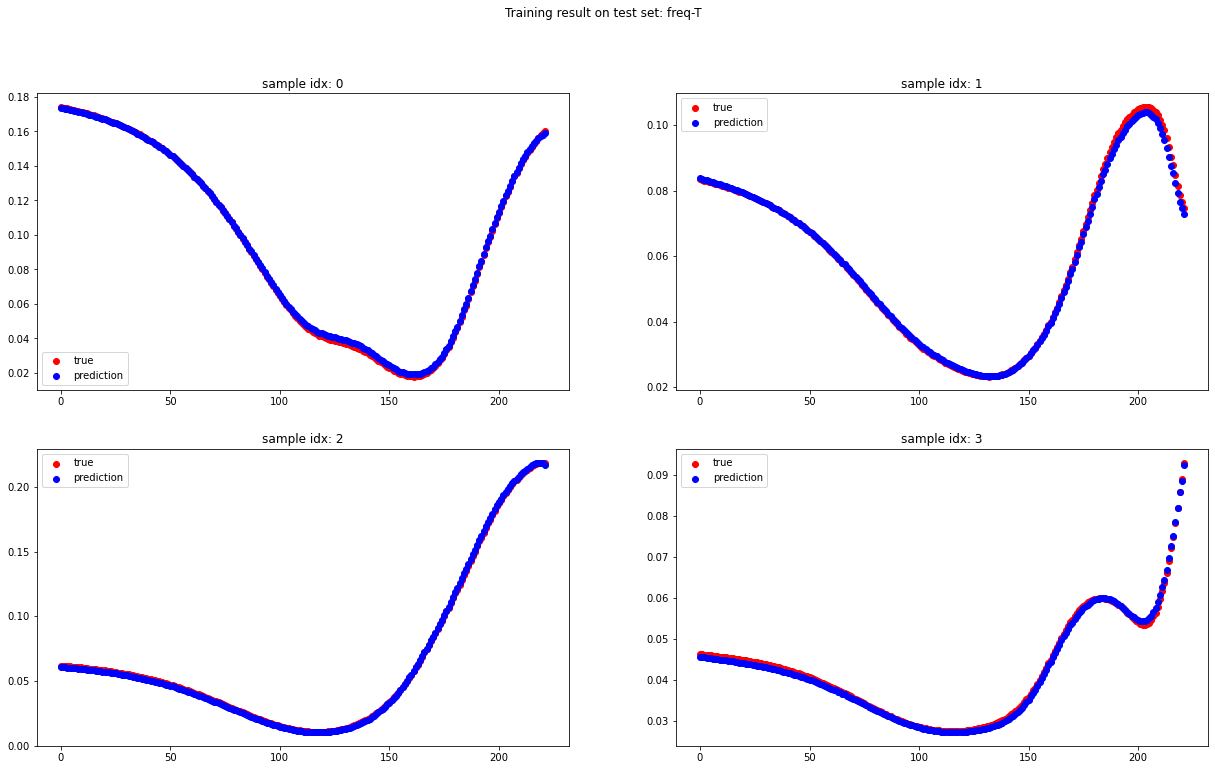

params_pick.shape: (10, 4)
params_pick: [[145. 121. 160.  75.]
 [145. 122. 160.  75.]
 [145. 120. 160.  75.]
 [146. 121. 160.  75.]
 [145. 123. 160.  75.]
 [146. 122. 160.  75.]
 [144. 121. 160.  75.]
 [144. 120. 160.  75.]
 [144. 122. 160.  75.]
 [145. 119. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


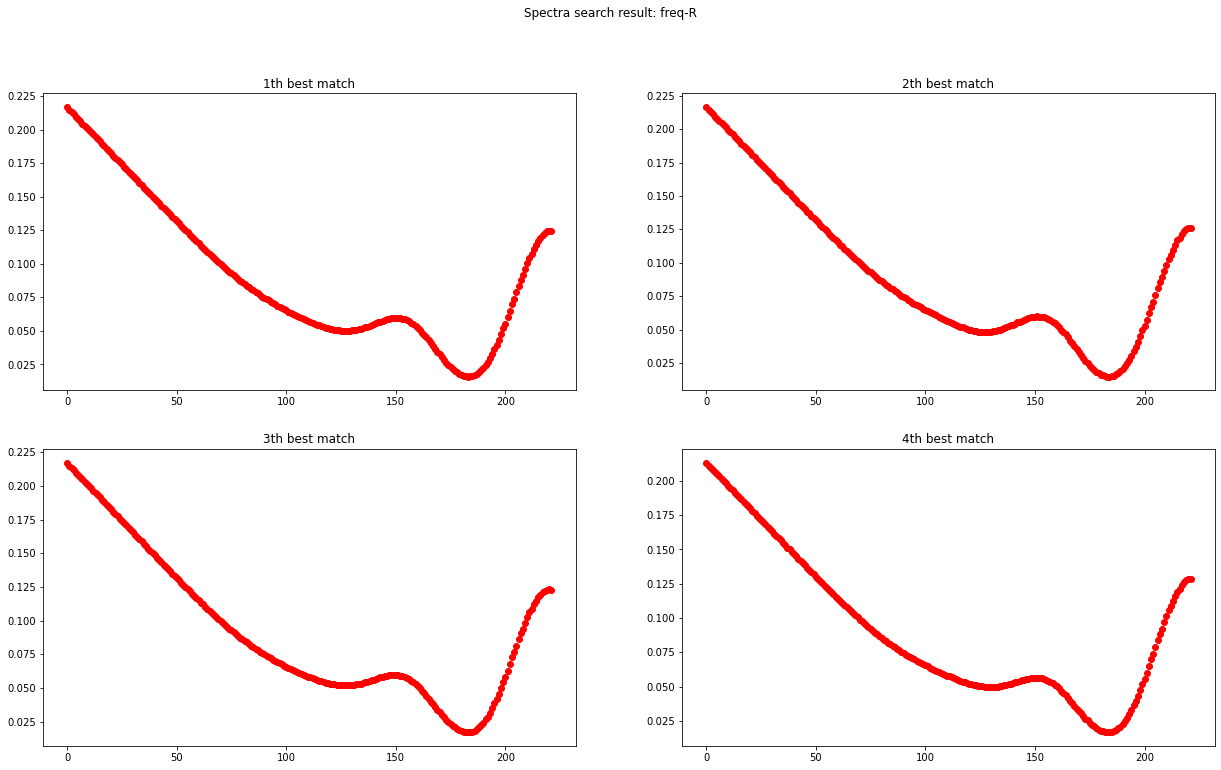

*** Reruning RCWA on picked params
params_dict.shape: (1421, 4)
R_dict.shape: (1421, 222)
T_dict.shape: (1421, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [145. 120. 160.  75.] params_pick: [145. 120. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [144. 121. 160.  75.] params_pick: [144. 121. 160.  75.]
---------

** Model saved.
**************************** ROUND 8 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1623
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [144. 101.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [146. 100.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 74. 111.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [136.  86.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [119. 104.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [149. 104.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [ 96. 128.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [127.  69.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [ 89. 118.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [147.  92.]
Calculati

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 98. 127.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [135. 146.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 69. 116.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [52. 72.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 97. 149.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [ 75. 106.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 58. 109.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [87. 93.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [132. 124.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [124. 130.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [121. 112.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [99. 85.]
Calculation Progress: 100%
-------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 3.756759546062765e-05
### TEST LOSS  0.00023643266584258527
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.2053490993106847e-05
### TEST LOSS  4.924163058603881e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 4.023110188246098e-06
### TEST LOSS  4.945668001710146e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 4.4875574873109836e-06
### TEST LOSS  4.941873021380161e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 3.886723076191663e-06
### TEST LOSS  4.828940604966192e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 6.1712245462411335e-06
### TEST LOSS  3.083390440679068e-06
----------------------------------------------------------------------
*

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 7.934695973466597e-07
### TEST LOSS  1.139765572588658e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 7.740397041389194e-07
### TEST LOSS  6.199517792992992e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.5196185151955614e-06
### TEST LOSS  1.0882032279369014e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 8.727952261742432e-07
### TEST LOSS  6.119863394360436e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 8.341279167716625e-07
### TEST LOSS  6.91415270921425e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.7699645692998657e-06
### TEST LOSS  1.6609871158834721e-06
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 4.936275553275364e-07
### TEST LOSS  6.682378841560421e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 7.08771465441348e-07
### TEST LOSS  4.7577397936038326e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 6.416833893208285e-07
### TEST LOSS  5.820116587074154e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 6.095323058231086e-07
### TEST LOSS  4.2076613567587627e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 6.587183827769274e-07
### TEST LOSS  2.135048275704321e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 6.795419076653214e-07
### TEST LOSS  5.149507967416867e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 4.2348185970431965e-07
### TEST LOSS  6.623857541399047e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 8.949500936830937e-07
### TEST LOSS  1.1108041258012236e-06
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.379550600355962e-07
### TEST LOSS  4.834233902784036e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 7.878351742092508e-07
### TEST LOSS  7.496465877920855e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 5.902630378690015e-07
### TEST LOSS  2.7987612952529164e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 5.42562452769032e-07
### TEST LOSS  6.226508401141473e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 4.4700745160127554e-07
### TEST LOSS  4.066817632519815e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.560157798145595e-07
### TEST LOSS  7.749251824407111e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 8.215330921796255e-07
### TEST LOSS  8.371039803023451e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 4.960722170684629e-07
### TEST LOSS  3.749948143649817e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 4.535352133119241e-07
### TEST LOSS  4.033601010178245e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 4.484529094876098e-07
### TEST LOSS  3.394427335479122e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.986561313687601e-07
### TEST LOSS  8.103203606424358e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.759557370185742e-07
### TEST LOSS  4.037508659848754e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.88613583117262e-07
### TEST LOSS  3.822743565251585e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.2987737812765406e-07
### TEST LOSS  2.9551363695645704e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.320626109594731e-07
### TEST LOSS  8.69286498073052e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.877915193758862e-07
### TEST LOSS  8.002438300991343e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.39658781939167e-07
### TEST LOSS  4.2715557697192707e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.1090176691565475e-07
### TEST LOSS  4.518421985721943e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.035923489881534e-07
### TEST LOSS  2.7329967053901785e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.8876348433562043e-07
### TEST LOSS  3.731587901256717e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.6097649718419694e-07
### TEST LOSS  3.345934305798437e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.955797087516241e-07
### TEST LOSS  2.6082167210006445e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.806410508899943e-07
### TEST LOSS  2.896270666497003e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.047226717954737e-07
### TEST LOSS  3.2499541589459115e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.111033916934581e-07
### TEST LOSS  2.4049495834788103e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.932237106248356e-07
### TEST LOSS  2.7661438082304814e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.91325410458636e-07
### TEST LOSS  3.969611691445607e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.2122931444699646e-07
### TEST LOSS  3.419362383283442e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.5470155425349387e-07
### TEST LOSS  3.120841915915662e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.543874834369024e-07
### TEST LOSS  3.4527619732216406e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.371150974185652e-07
### TEST LOSS  2.722657706044629e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.717487547320056e-07
### TEST LOSS  2.903910393570186e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.9776824743715126e-07
### TEST LOSS  2.4248682052530056e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.424189823051341e-07
### TEST LOSS  2.858904520053329e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.2811072928773396e-07
### TEST LOSS  5.538664174764563e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.51971087449375e-07
### TEST LOSS  3.67154626133015e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.8255770966691643e-07
### TEST LOSS  3.0231875939534804e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.3736492812770804e-07
### TEST LOSS  2.7281415668767297e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.6129205264327886e-07
### TEST LOSS  3.2775318231870187e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.76143719717637e-07
### TEST LOSS  2.794428127117499e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.2041133418692923e-07
### TEST LOSS  2.6027686544694007e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.53527173118402e-07
### TEST LOSS  3.197554576672701e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.6432496780307124e-07
### TEST LOSS  5.713690927677817e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 1.5564288138120181e-06
### TEST LOSS  6.311125764568714e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 7.361884089801236e-07
### TEST LOSS  3.5713543582005515e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.3448478066382384e-07
### TEST LOSS  3.3844140148175936e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.785312730604545e-07
### TEST LOSS  2.7282378709969636e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.404469870367471e-07
### TEST LOSS  3.750100131583167e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.5936931182849167e-07
### TEST LOSS  3.871512501518737e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.2715468975512487e-07
### TEST LOSS  3.0520821098889427e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.912816777331099e-07
### TEST LOSS  3.722539008776948e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.364676202615793e-07
### TEST LOSS  3.704268317505921e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.302531940389719e-07
### TEST LOSS  5.350686353722267e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.1707289548584474e-07
### TEST LOSS  4.182867883173458e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.6414817072154387e-07
### TEST LOSS  2.8495522201410496e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 5.231047628492793e-07
### TEST LOSS  1.312361628151848e-06
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.8517861387858705e-07
### TEST LOSS  3.240046987684764e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.396855342860963e-07
### TEST LOSS  9.484718100338795e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.1870132453159115e-07
### TEST LOSS  3.232326292845755e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.15253504962756e-07
### TEST LOSS  4.6577759462707034e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.346330575047877e-07
### TEST LOSS  4.719226819815958e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.3616848726087926e-07
### TEST LOSS  3.4022133604594274e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.8484983754528863e-07
### TEST LOSS  2.636813263734439e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.2350820849974984e-07
### TEST LOSS  2.821481234605017e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.201509132662554e-07
### TEST LOSS  3.190211441506108e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.249073785983512e-07
### TEST LOSS  3.4312149864490494e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.2458482208683076e-07
### TEST LOSS  2.2962019045280612e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.7356658368967643e-07
### TEST LOSS  3.0243248545502864e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.1688906210602593e-07
### TEST LOSS  1.4031992213858758e-06
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.084885518877282e-07
### TEST LOSS  2.550212752794323e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.8183311772381904e-07
### TEST LOSS  2.4558180029998765e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 1.5841459415771436e-06
### TEST LOSS  2.2607386131312524e-06
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 1.334492455035938e-06
### TEST LOSS  5.462733668082364e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 1.0096952414798703e-06
### TEST LOSS  5.013107033846609e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 1.0215094334087204e-06
### TEST LOSS  4.5261212392233576e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 1.0079183292197642e-06
### TEST LOSS  9.251157882772532e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.057847012614819e-07
### TEST LOSS  2.937170921768484e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 2.974890874373496e-07
### TEST LOSS  2.669612160843826e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.079915497555288e-07
### TEST LOSS  2.2655516488612192e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 6.16740944919858e-07
### TEST LOSS  5.079914831185306e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 4.5258119113732154e-07
### TEST LOSS  3.3985803156610926e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.585520854001129e-07
### TEST LOSS  4.181758038157568e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.006424163384189e-07
### TEST LOSS  6.044974259111768e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.521192344102202e-07
### TEST LOSS  2.9881960813327167e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.876162490373128e-07
### TEST LOSS  3.5969215446129964e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.0078320603748e-07
### TEST LOSS  2.1731577930950153e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.9776402384863344e-07
### TEST LOSS  2.719239790849315e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.961362353989728e-07
### TEST LOSS  2.51927512522343e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.949249868915781e-07
### TEST LOSS  4.126796648051823e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.303109507952879e-07
### TEST LOSS  4.002955483883852e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.9663631236764846e-07
### TEST LOSS  3.527914475398575e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.978909995002326e-07
### TEST LOSS  2.260876971149628e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.732861915319378e-07
### TEST LOSS  2.549016534203474e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.8841684748074385e-07
### TEST LOSS  4.2517908013905983e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.6049616275409415e-07
### TEST LOSS  4.4275392383497094e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.619384189919935e-07
### TEST LOSS  3.0301481046990375e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 4.830621518291918e-07
### TEST LOSS  2.8900511154006383e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.113126720770241e-07
### TEST LOSS  3.924924283182918e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.8799214791064727e-07
### TEST LOSS  2.3399700751269848e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.760882152343425e-07
### TEST LOSS  2.709719257154575e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.789960724844645e-07
### TEST LOSS  1.987465083175266e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.9023153634298787e-07
### TEST LOSS  2.785081545653156e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.9592401937644017e-07
### TEST LOSS  2.4396968967721477e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.868063686324975e-07
### TEST LOSS  2.4293125250096637e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.732083646817498e-07
### TEST LOSS  2.3624368111541117e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.0452140700689966e-07
### TEST LOSS  2.7988296210423867e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.9941016649165606e-07
### TEST LOSS  3.2254795883090993e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.827973623507621e-07
### TEST LOSS  3.5520210190043144e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.73835778282251e-07
### TEST LOSS  1.9381492450065707e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.9306081422978833e-07
### TEST LOSS  3.234657947359665e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.6507837672758857e-07
### TEST LOSS  3.273567529049615e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.8027179564955246e-07
### TEST LOSS  2.3679283344790747e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.8004924235535e-07
### TEST LOSS  2.57277418427293e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.7974447376243115e-07
### TEST LOSS  3.6724873552884674e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.9739077637230333e-07
### TEST LOSS  2.689691137902628e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.665957596711932e-07
### TEST LOSS  3.953761768116237e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.876565020735152e-07
### TEST LOSS  2.438236811030947e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.714131317590694e-07
### TEST LOSS  3.8133654925331936e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.777059540070229e-07
### TEST LOSS  7.152949501687544e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.956185525034486e-07
### TEST LOSS  1.8727190422396235e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.7395940650704405e-07
### TEST LOSS  3.534771099111822e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.8463390226604674e-07
### TEST LOSS  2.586705414842072e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.5186564615395006e-07
### TEST LOSS  3.9725488477415637e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.613280844079982e-07
### TEST LOSS  2.4487542532369844e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.9520796314316914e-07
### TEST LOSS  5.1523612114579e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.982270507090002e-07
### TEST LOSS  3.700491322433663e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.657450971111527e-07
### TEST LOSS  2.1925531370925455e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.6626393117675145e-07
### TEST LOSS  2.2401889964385192e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.558265366935835e-07
### TEST LOSS  2.211922713968306e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.809001678588878e-07
### TEST LOSS  3.272354149430612e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.6836868563113394e-07
### TEST LOSS  2.6204516245798004e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.675485879752986e-07
### TEST LOSS  2.0465589159357478e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.71566401944276e-07
### TEST LOSS  1.865075046225684e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.7648376532938247e-07
### TEST LOSS  3.008232573620262e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.5990716373598633e-07
### TEST LOSS  2.1622063513859758e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.897745317000552e-07
### TEST LOSS  1.8854984375593632e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.551932110710637e-07
### TEST LOSS  2.932014251655346e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.41615671906887e-07
### TEST LOSS  2.3670592213420605e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.549431088671752e-07
### TEST LOSS  2.2530694423039678e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.5952171051998537e-07
### TEST LOSS  2.6364080952134827e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.2459724799952905e-07
### TEST LOSS  2.1197968237629537e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.4423337546033056e-07
### TEST LOSS  2.3132230921873998e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.4648047948084934e-07
### TEST LOSS  2.0650808039590628e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.5811552715225106e-07
### TEST LOSS  2.9366394755925284e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.6094842909157123e-07
### TEST LOSS  1.9617648945313703e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.5698959036557563e-07
### TEST LOSS  2.4598832339961516e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.5590458066645606e-07
### TEST LOSS  2.2206850189832039e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.0967166740113956e-07
### TEST LOSS  3.7539324921453953e-07
----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.7697168542954295e-07
### TEST LOSS  2.2505984929921398e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.6876741749758087e-07
### TEST LOSS  2.513386857572186e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.6203430418840116e-07
### TEST LOSS  2.589879562719943e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.41877430415505e-07
### TEST LOSS  2.3735105173727788e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.448222141195802e-07
### TEST LOSS  2.40620704516914e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.5681195828360134e-07
### TEST LOSS  3.3920429018508005e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.4664044188304254e-07
### TEST LOSS  2.3069044061685417e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.481413624456577e-07
### TEST LOSS  4.5667984636565963e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.3075640686770438e-07
### TEST LOSS  2.0466131388729992e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.465947698147382e-07
### TEST LOSS  3.917343735793111e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.5151055407115e-07
### TEST LOSS  1.7588054220141204e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.4607154217183214e-07
### TEST LOSS  2.8405391844898986e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.3722755140146516e-07
### TEST LOSS  1.8650571377065716e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.572174210058059e-07
### TEST LOSS  2.3604945198485439e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.6509380589385114e-07
### TEST LOSS  8.503399840265046e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.365827653011083e-07
### TEST LOSS  3.1407128233240654e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.654959573741747e-07
### TEST LOSS  2.607911483210046e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.416152449595754e-07
### TEST LOSS  2.98438861818795e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.6130174235274106e-07
### TEST LOSS  3.088702845843727e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.6241098356097176e-07
### TEST LOSS  3.1459153433388564e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.3708856999535944e-07
### TEST LOSS  3.986737146988162e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.487610236035333e-07
### TEST LOSS  2.9775724954106407e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.4646389508614425e-07
### TEST LOSS  2.028534794362713e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.574386414533938e-07
### TEST LOSS  3.0138780971356027e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.3967893704485616e-07
### TEST LOSS  2.1733787377797853e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.4880255722555997e-07
### TEST LOSS  2.509532316707919e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.412460425295997e-07
### TEST LOSS  1.9966165950791037e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.5393603160914074e-07
### TEST LOSS  2.291083569616603e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.3602317393973487e-07
### TEST LOSS  3.009467349102124e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.510093180849083e-07
### TEST LOSS  2.0573620986397146e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 3.3611010925796143e-07
### TEST LOSS  3.035572183307522e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.606627324726108e-07
### TEST LOSS  2.2432272885453132e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.174943106553265e-07
### TEST LOSS  2.0692052999038424e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.3228265826790452e-07
### TEST LOSS  2.000071162910899e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.476599705816539e-07
### TEST LOSS  2.346107766015848e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.412137784525184e-07
### TEST LOSS  1.577725589640977e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.489747720813404e-07
### TEST LOSS  1.8309076551759063e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.3678386163987215e-07
### TEST LOSS  2.0995035868054401e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.4071962340223753e-07
### TEST LOSS  1.6333548046532088e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.4725706989027225e-07
### TEST LOSS  2.2860612148178916e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.4563365983953527e-07
### TEST LOSS  2.0659519350374467e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.6876939217486567e-07
### TEST LOSS  2.1076625273508397e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.576232224320873e-07
### TEST LOSS  2.544906800494573e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.6487119506232326e-07
### TEST LOSS  2.2799573969223276e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.4598534409392414e-07
### TEST LOSS  2.6568234829937864e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.394689100718403e-07
### TEST LOSS  2.629696081157817e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.9935963702646815e-07
### TEST LOSS  2.274857484962922e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.3082823905423727e-07
### TEST LOSS  3.009532179021335e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.5208011937330825e-07
### TEST LOSS  1.8038894097571756e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.7322078976920286e-07
### TEST LOSS  2.458214237321954e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.524788744177642e-07
### TEST LOSS  3.220494585320921e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.525106751541085e-07
### TEST LOSS  3.295136184533476e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.464952701776196e-07
### TEST LOSS  2.0930179232436784e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.2791152638945943e-07
### TEST LOSS  2.331211612727202e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.2885997415491381e-07
### TEST LOSS  1.79930636932113e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.7809317225846145e-07
### TEST LOSS  3.559437135436383e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.3503095501903082e-07
### TEST LOSS  4.236657832734636e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.2264328869316304e-07
### TEST LOSS  2.8954868412256475e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.2005716829338812e-07
### TEST LOSS  2.6821555536571396e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.3069165356168057e-07
### TEST LOSS  1.6714551890117945e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.7794699586290314e-07
### TEST LOSS  2.353670157617671e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.546855537354384e-07
### TEST LOSS  1.9064144169078645e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.9482802487925597e-07
### TEST LOSS  2.6518766674143987e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.3098977699957685e-07
### TEST LOSS  2.0114584174280025e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.459042531491894e-07
### TEST LOSS  2.2238534711505053e-07
** loss_train 2.459042531491894e-07
** loss_test 2.2238534711505053e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [145. 121. 160.  75.]
 [146. 122. 160.  75.]
 [146. 120. 160.  75.]
 [147. 121. 160.  75.]
 [147. 122. 160.  75.]
 [145. 122. 160.  75.]
 [145. 120. 160.  75.]
 [147. 120. 160.  75.]
 [147. 123. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


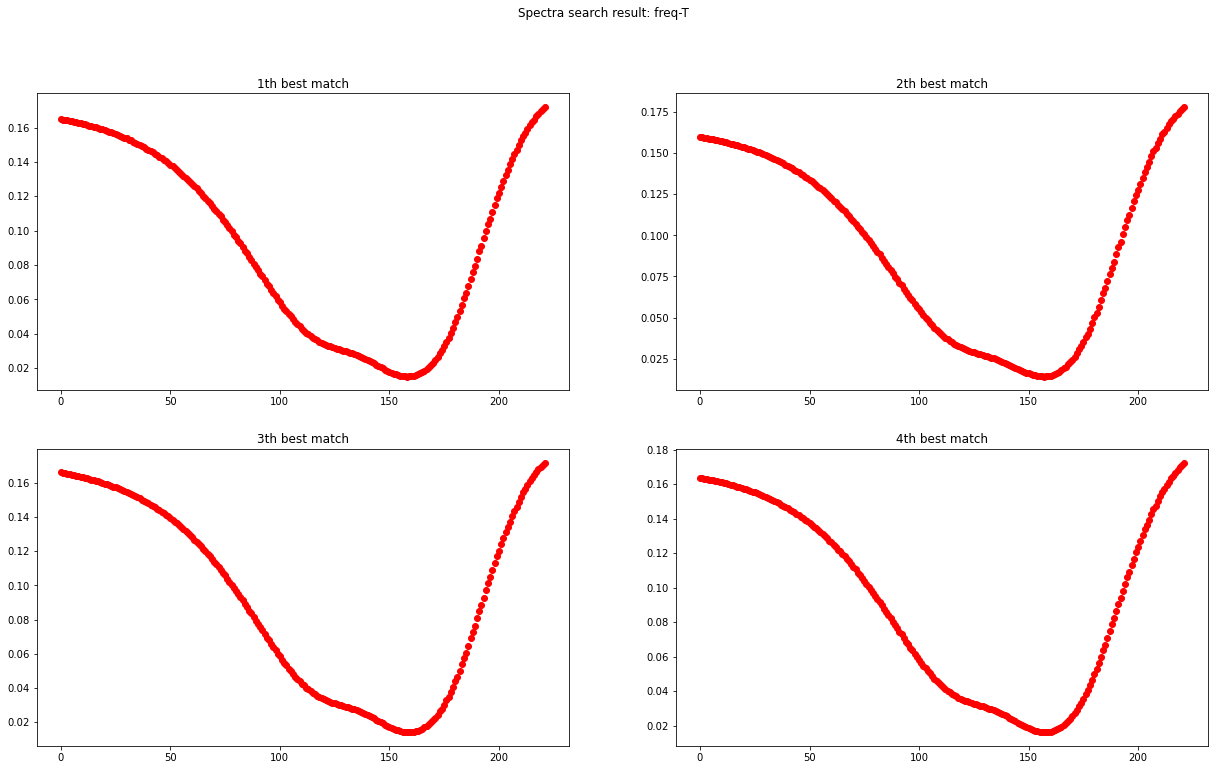

*** Reruning RCWA on picked params
params_dict.shape: (1623, 4)
R_dict.shape: (1623, 222)
T_dict.shape: (1623, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
---------

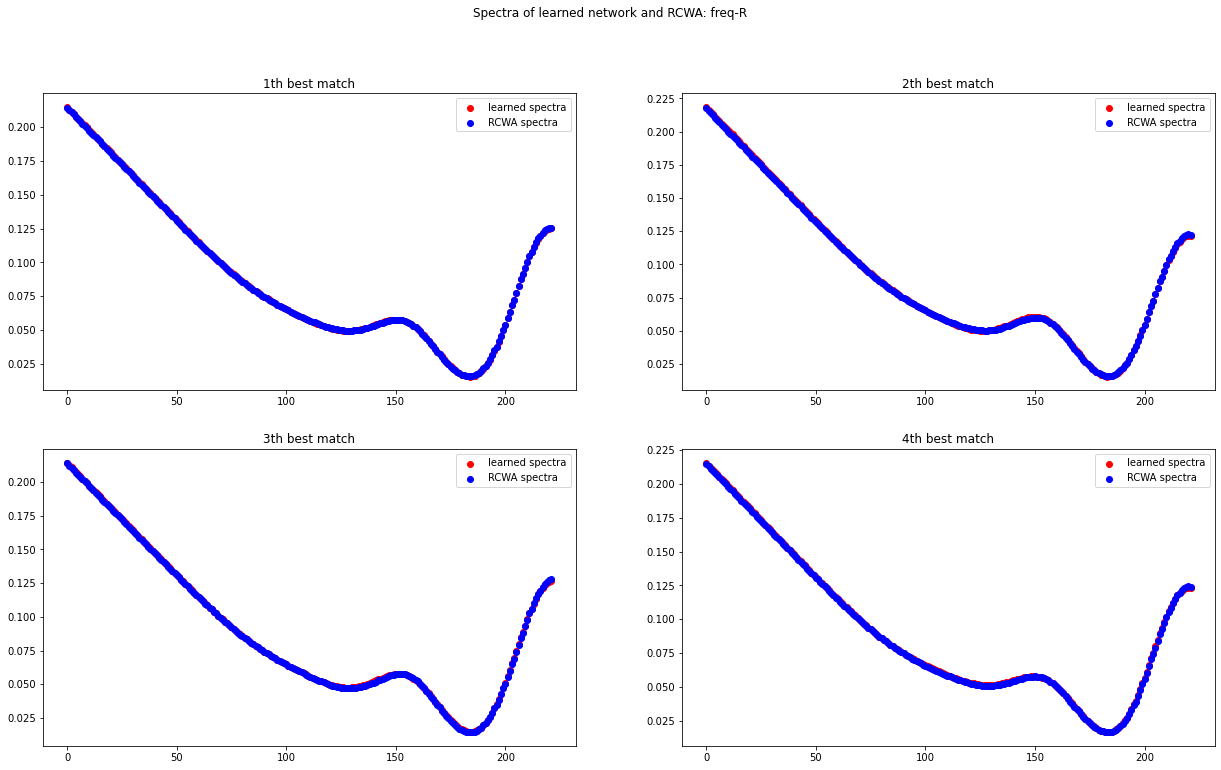

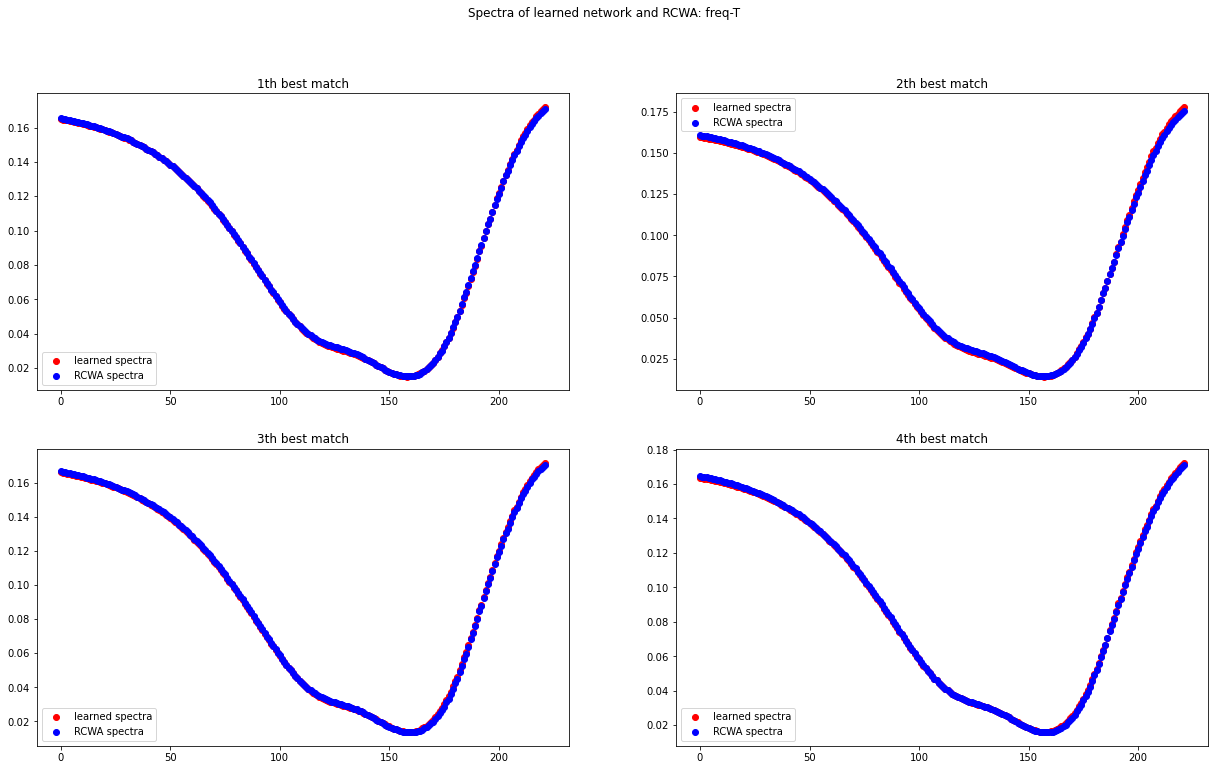

** Model saved.
**************************** ROUND 9 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1824
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [105.  60.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 72. 129.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [141. 146.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [129.  80.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [85. 76.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 58. 128.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [147. 133.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [68. 94.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [95. 55.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [69. 99.]
Calculation Progr

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [116. 113.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [104. 139.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [124. 135.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [70. 53.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 98. 146.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [147.  82.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 83. 132.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 96. 103.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [98. 76.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 90. 102.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [145. 118.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [82. 82.]
Calculation Progress: 100%
-------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 2.8298830195476393e-05
### TEST LOSS  8.83885221420704e-05
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.7319451710970818e-05
### TEST LOSS  3.3476433876395665e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 3.928524068703659e-06
### TEST LOSS  2.3305035930271904e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 4.347066664980616e-06
### TEST LOSS  3.460483063528435e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.776897821255593e-06
### TEST LOSS  1.779688960011429e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 2.7312728794076354e-06
### TEST LOSS  3.5827684874740432e-06
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.01191616445627e-06
### TEST LOSS  1.0394588879795004e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.441638869476501e-06
### TEST LOSS  7.764656554546232e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.6128065142966313e-06
### TEST LOSS  1.3072580437827647e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 9.652774675498559e-07
### TEST LOSS  4.3131897038100373e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.013695044130951e-06
### TEST LOSS  5.010981673032282e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.8344544409739084e-06
### TEST LOSS  2.441452163485077e-06
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 5.963944541631711e-07
### TEST LOSS  7.921499626409709e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 5.559220738447024e-07
### TEST LOSS  4.169523494722073e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 5.672634722421247e-07
### TEST LOSS  7.700315295876083e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 6.965012389098621e-07
### TEST LOSS  2.940249278334964e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 5.499884338355408e-07
### TEST LOSS  3.9649761467736813e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 6.310052170075876e-07
### TEST LOSS  4.4600494370732644e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 8.227997134540656e-07
### TEST LOSS  5.404129217773905e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 7.738780180907031e-07
### TEST LOSS  5.105307110397916e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 4.7330075361388095e-07
### TEST LOSS  8.07004499035559e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.253995607896706e-07
### TEST LOSS  6.333200204267087e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 4.98524005511345e-07
### TEST LOSS  5.997626035179695e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 4.80414321754851e-07
### TEST LOSS  3.8100442623090203e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 8.757021992632449e-07
### TEST LOSS  1.1460616698449095e-05
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 1.088784253346441e-06
### TEST LOSS  7.285665942293105e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 2.63754696039537e-06
### TEST LOSS  1.4192825728644363e-06
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 8.507915528404254e-07
### TEST LOSS  4.6220041127753575e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.161828937830773e-07
### TEST LOSS  3.2710498944408884e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 6.069078681115588e-07
### TEST LOSS  5.203037015836085e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.429972136762192e-07
### TEST LOSS  4.2327431718344345e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 9.205876659926372e-07
### TEST LOSS  4.828312084116857e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 9.140037215445224e-07
### TEST LOSS  4.1917826162521775e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.231292871363891e-07
### TEST LOSS  3.8743987472246643e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.4317256650014453e-07
### TEST LOSS  2.9962609054174596e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.526603536272439e-07
### TEST LOSS  5.178309651552939e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.414012725328931e-07
### TEST LOSS  5.783013773249682e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.1525944754454354e-07
### TEST LOSS  5.233220292666374e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 3.7949484977778295e-07
### TEST LOSS  3.951205716897935e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.8278048466377864e-07
### TEST LOSS  3.015730223004149e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 7.162931112287791e-07
### TEST LOSS  3.168402982518208e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.1931356268170833e-07
### TEST LOSS  4.2025969244312886e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.56668770447005e-07
### TEST LOSS  7.888224859341011e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.177034534778491e-07
### TEST LOSS  2.5163664878797523e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.7574291025555764e-07
### TEST LOSS  5.705515491172264e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.717009757550091e-07
### TEST LOSS  3.453659930739507e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.784072101804887e-07
### TEST LOSS  3.3652012275199793e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.6257988054158535e-07
### TEST LOSS  2.3302920786656095e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.597974145851137e-07
### TEST LOSS  3.224146313738986e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.494798212303844e-07
### TEST LOSS  2.640999140014953e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.7782777818784864e-07
### TEST LOSS  3.03043263118395e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.9550373077640214e-07
### TEST LOSS  2.653263539035119e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.3879918068003503e-07
### TEST LOSS  3.7007253439469423e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.049965364611957e-07
### TEST LOSS  2.6571668344997435e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.736842239668644e-07
### TEST LOSS  3.1184545993109427e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.540320557787649e-07
### TEST LOSS  2.672771078745687e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.7739825816888155e-07
### TEST LOSS  4.12898147926301e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.0629789946198726e-07
### TEST LOSS  6.510471856862361e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.4496089261895963e-07
### TEST LOSS  2.4415102676097635e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.423350098124429e-07
### TEST LOSS  2.421550178155485e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.2916663291768284e-07
### TEST LOSS  2.999982246113372e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.3567935011752664e-07
### TEST LOSS  2.3739563254870128e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.832839550480702e-07
### TEST LOSS  5.41542920221413e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.5657651084938254e-07
### TEST LOSS  2.701392120789998e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.326616120142611e-07
### TEST LOSS  2.2458647665400478e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.553463306889149e-07
### TEST LOSS  2.610147105437071e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.4356735565083283e-07
### TEST LOSS  2.7526625296608085e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.1059606405722857e-07
### TEST LOSS  2.792894784014217e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.383100912210439e-07
### TEST LOSS  3.0282110482663225e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.4659787751065395e-07
### TEST LOSS  2.725871282344932e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.329314756768666e-07
### TEST LOSS  3.0492845378863163e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.345704515276154e-07
### TEST LOSS  2.8292873415531563e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.1386519273843916e-07
### TEST LOSS  2.3504807294167612e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.3761398891366906e-07
### TEST LOSS  4.3766193564514264e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.438248282827878e-07
### TEST LOSS  4.582134676768744e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.2254171227734314e-07
### TEST LOSS  4.2690875647265004e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.229159683732428e-07
### TEST LOSS  3.1255967262008457e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.5123568485252503e-07
### TEST LOSS  3.587864532456868e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.199793072903184e-07
### TEST LOSS  2.729652435513279e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.5206191120886275e-07
### TEST LOSS  2.6904091906690806e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.2488547922492087e-07
### TEST LOSS  2.618556627404749e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.35185820609817e-07
### TEST LOSS  3.5259157929853503e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.9653497772583505e-07
### TEST LOSS  5.831982404304524e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.327278965135929e-07
### TEST LOSS  3.476328446692735e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.5019479912209067e-07
### TEST LOSS  2.3785174160398777e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.2306100201233737e-07
### TEST LOSS  3.2023692142502114e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.4556519601186067e-07
### TEST LOSS  3.016371635007025e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 8.698931418955575e-07
### TEST LOSS  2.160135803056359e-06
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 6.899033716193362e-07
### TEST LOSS  3.867795318309878e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.776523518009814e-07
### TEST LOSS  2.161951537159114e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.653157762367645e-07
### TEST LOSS  2.931120336922634e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.7648028133593184e-07
### TEST LOSS  3.9141225930247205e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.259086836389052e-07
### TEST LOSS  2.8954622065059864e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.088391706857027e-07
### TEST LOSS  2.4951217828369667e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.261160134325894e-07
### TEST LOSS  2.4603061581680255e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 9.91880634347989e-07
### TEST LOSS  1.0509009038222367e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.384240759189426e-07
### TEST LOSS  3.4423039098539577e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.0658639976949773e-07
### TEST LOSS  3.0308340573778227e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.950303860377994e-07
### TEST LOSS  2.4991015530011804e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 2.907194511100545e-07
### TEST LOSS  3.715196343583622e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.122962396209161e-07
### TEST LOSS  2.3875896206147574e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.980703010047243e-07
### TEST LOSS  4.892188170759124e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.9822888875973814e-07
### TEST LOSS  2.1907726629625097e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.6893987961186373e-07
### TEST LOSS  2.4252626015400634e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.027223995726926e-07
### TEST LOSS  2.743227461061386e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.074579455455924e-07
### TEST LOSS  2.2781229144389466e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.1123167446558913e-07
### TEST LOSS  2.6321307292472997e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.1537310915492767e-07
### TEST LOSS  2.546193031654249e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.120147073536316e-07
### TEST LOSS  2.477036242152865e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.134476180151019e-07
### TEST LOSS  3.5560030348895974e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.4767567175437095e-07
### TEST LOSS  3.4428601785358684e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.2468739630058876e-07
### TEST LOSS  2.0587940038499904e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.8099425590243113e-07
### TEST LOSS  2.858987657410645e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.882752041151922e-07
### TEST LOSS  2.1135903186372422e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.074178699390164e-07
### TEST LOSS  2.4086265934134386e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.066625636858022e-07
### TEST LOSS  2.720980647146527e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.9534696619267793e-07
### TEST LOSS  2.461611628185827e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 4.7395726156714463e-07
### TEST LOSS  1.7179313951081504e-06
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 5.229948859980224e-07
### TEST LOSS  5.626513127156483e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 5.6896075085218e-07
### TEST LOSS  5.681439369758274e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.780571435469591e-07
### TEST LOSS  2.1979169874595884e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.7669774661178433e-07
### TEST LOSS  2.7592083132585034e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.812235573360224e-07
### TEST LOSS  2.447496300866143e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.943352698753135e-07
### TEST LOSS  5.518483752504315e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.0376273907047716e-07
### TEST LOSS  2.4435037764598224e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.005625396054026e-07
### TEST LOSS  2.0637678943558058e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.886462758898642e-07
### TEST LOSS  3.056755686665318e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.0005872196477425e-07
### TEST LOSS  2.7973988027594844e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.0934587054126565e-07
### TEST LOSS  2.4277809375559757e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.9164020631800014e-07
### TEST LOSS  2.0093469034674983e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.107940026272466e-07
### TEST LOSS  2.919676097081135e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.956305277187897e-07
### TEST LOSS  3.113829098059081e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.7234243858235513e-07
### TEST LOSS  2.4868906121712696e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.7598295470093833e-07
### TEST LOSS  3.556653902186164e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.958866511502201e-07
### TEST LOSS  2.902249731968303e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.0651544369125274e-07
### TEST LOSS  2.3464359445922257e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.7346053831698573e-07
### TEST LOSS  2.694179492834792e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.835125365488223e-07
### TEST LOSS  2.97163041856103e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.718520477618114e-07
### TEST LOSS  2.378104291267391e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.9329610903509033e-07
### TEST LOSS  3.5882830522788414e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.865481052818481e-07
### TEST LOSS  3.458558199197016e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.978277830399497e-07
### TEST LOSS  2.762330742557749e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.712714237197881e-07
### TEST LOSS  3.3889096836706554e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.087544000020527e-07
### TEST LOSS  3.3473273778180814e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.2025760123376375e-07
### TEST LOSS  4.026086171750519e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.855736879445814e-07
### TEST LOSS  2.1981203346399525e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 5.222514622427177e-07
### TEST LOSS  6.999548623249601e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.3374976017453263e-07
### TEST LOSS  2.7371098149891235e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.709489935465841e-07
### TEST LOSS  2.637924794157698e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.866289138833737e-07
### TEST LOSS  4.1986750838012607e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.9080186778003437e-07
### TEST LOSS  2.34013057820448e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.838221669851225e-07
### TEST LOSS  2.421842206144577e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.9024270989921835e-07
### TEST LOSS  2.1755129202866946e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.8700227808744987e-07
### TEST LOSS  2.529733938518218e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.808560214230124e-07
### TEST LOSS  3.0830497012500147e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.2237767132108587e-07
### TEST LOSS  2.873124270560571e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.7817743852951126e-07
### TEST LOSS  2.7298649334690186e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.5976543077871825e-07
### TEST LOSS  2.229234757424235e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.1153121177477546e-07
### TEST LOSS  7.524470179630174e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 7.1333905452144e-07
### TEST LOSS  3.077387792213163e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.2981529829445577e-07
### TEST LOSS  1.9900299008668298e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.688254343282506e-07
### TEST LOSS  2.982743768801096e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.8635235443746423e-07
### TEST LOSS  1.935168409009488e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.268836817484443e-07
### TEST LOSS  2.5863489331153945e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.734511250816873e-07
### TEST LOSS  2.571780533295558e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.8571721430886416e-07
### TEST LOSS  2.2716708666540138e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.687583591378194e-07
### TEST LOSS  2.2742155130523705e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.6826664629486214e-07
### TEST LOSS  1.7810505578300502e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.7479843302428706e-07
### TEST LOSS  2.048716076785695e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.8357496519879117e-07
### TEST LOSS  2.84897521701006e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.8196215202630396e-07
### TEST LOSS  2.341446863697781e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.9123474274592606e-07
### TEST LOSS  2.9733560172725705e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.0479204708259527e-07
### TEST LOSS  3.4644214506686565e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.64605622128777e-07
### TEST LOSS  3.0978400492439763e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.5192141694356447e-07
### TEST LOSS  2.618070118793574e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.7776357180304653e-07
### TEST LOSS  2.522042653449067e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.8001266957559094e-07
### TEST LOSS  2.490170375933433e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.596303286971494e-07
### TEST LOSS  2.6677248397634556e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.621485256687581e-07
### TEST LOSS  4.887178976429953e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.839432573684569e-07
### TEST LOSS  3.1191063243340977e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 9.606402587224002e-07
### TEST LOSS  3.5049205645723956e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.6860847179644335e-07
### TEST LOSS  2.5535936336902e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.058915757748612e-07
### TEST LOSS  2.7620122773035813e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.9712106786623853e-07
### TEST LOSS  3.2026598922081053e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.7207574394814216e-07
### TEST LOSS  2.0940391668286144e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.8265906653388843e-07
### TEST LOSS  2.8844272697321163e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.7181519646494353e-07
### TEST LOSS  2.9248034445166535e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.5727042695821294e-07
### TEST LOSS  2.994957917223928e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.583421197005595e-07
### TEST LOSS  2.3344338271970499e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.694443224717128e-07
### TEST LOSS  2.1891074197810667e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.892244994553837e-07
### TEST LOSS  2.8561079901123776e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.7749578646820435e-07
### TEST LOSS  1.9452086823840936e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.689507928042869e-07
### TEST LOSS  3.2351308476563645e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.893257966385009e-07
### TEST LOSS  2.574384433882772e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.814165948751922e-07
### TEST LOSS  2.1426105080633663e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.681967378600706e-07
### TEST LOSS  1.8534401112292797e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.5048836190732867e-07
### TEST LOSS  2.529600214375348e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.754739915690644e-07
### TEST LOSS  2.511040777213631e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.5337116652905206e-07
### TEST LOSS  2.431236286578756e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.686158803741394e-07
### TEST LOSS  2.4337899213427203e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.530619260965706e-07
### TEST LOSS  2.370809824014941e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.7729205507387637e-07
### TEST LOSS  3.7317594449502523e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.581516084086323e-07
### TEST LOSS  2.3429689883463262e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.893958505047176e-07
### TEST LOSS  1.9934823772668357e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.753141614160532e-07
### TEST LOSS  4.057691985589632e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.807587244494155e-07
### TEST LOSS  2.1426592157679026e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.876177611145673e-07
### TEST LOSS  1.896006445178955e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.8925109193701173e-07
### TEST LOSS  3.436965622581413e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.8032892849425447e-07
### TEST LOSS  2.8849821934581345e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 3.089023846110251e-07
### TEST LOSS  2.030333955563687e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.533526037802481e-07
### TEST LOSS  2.1417290087453823e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.6177482748914467e-07
### TEST LOSS  3.667263460524087e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.386781793940921e-07
### TEST LOSS  2.0412096546351677e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.489558900415483e-07
### TEST LOSS  2.17926432709094e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.6134138112846966e-07
### TEST LOSS  2.1772422391969875e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.5164084795739176e-07
### TEST LOSS  1.6683242064021086e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.6366293827674555e-07
### TEST LOSS  2.3202249518508973e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.6272720932920275e-07
### TEST LOSS  1.716670391869814e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.496991166339042e-07
### TEST LOSS  2.4147988091678077e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.789886451255597e-07
### TEST LOSS  2.570986324152662e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.7533428638694376e-07
### TEST LOSS  2.0885166459752975e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.6180564833502014e-07
### TEST LOSS  2.292905882939067e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.7074964284397197e-07
### TEST LOSS  1.7774738201938233e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.505172885198959e-07
### TEST LOSS  2.3431572821713026e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.5205636081835233e-07
### TEST LOSS  2.0766156235855045e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.5078764270338067e-07
### TEST LOSS  2.2272824651281553e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.5067444602230724e-07
### TEST LOSS  2.0134784760119017e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.622738847057492e-07
### TEST LOSS  2.2405648181234028e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.512344605210188e-07
### TEST LOSS  2.2561887799302634e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.4655641131083056e-07
### TEST LOSS  2.1976894056966296e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.5071773518403617e-07
### TEST LOSS  2.4945603018165586e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.490725311408616e-07
### TEST LOSS  3.0856853681728224e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.451790796050281e-07
### TEST LOSS  3.7102847422992067e-07
** loss_train 2.451790796050281e-07
** loss_test 3.7102847422992067e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


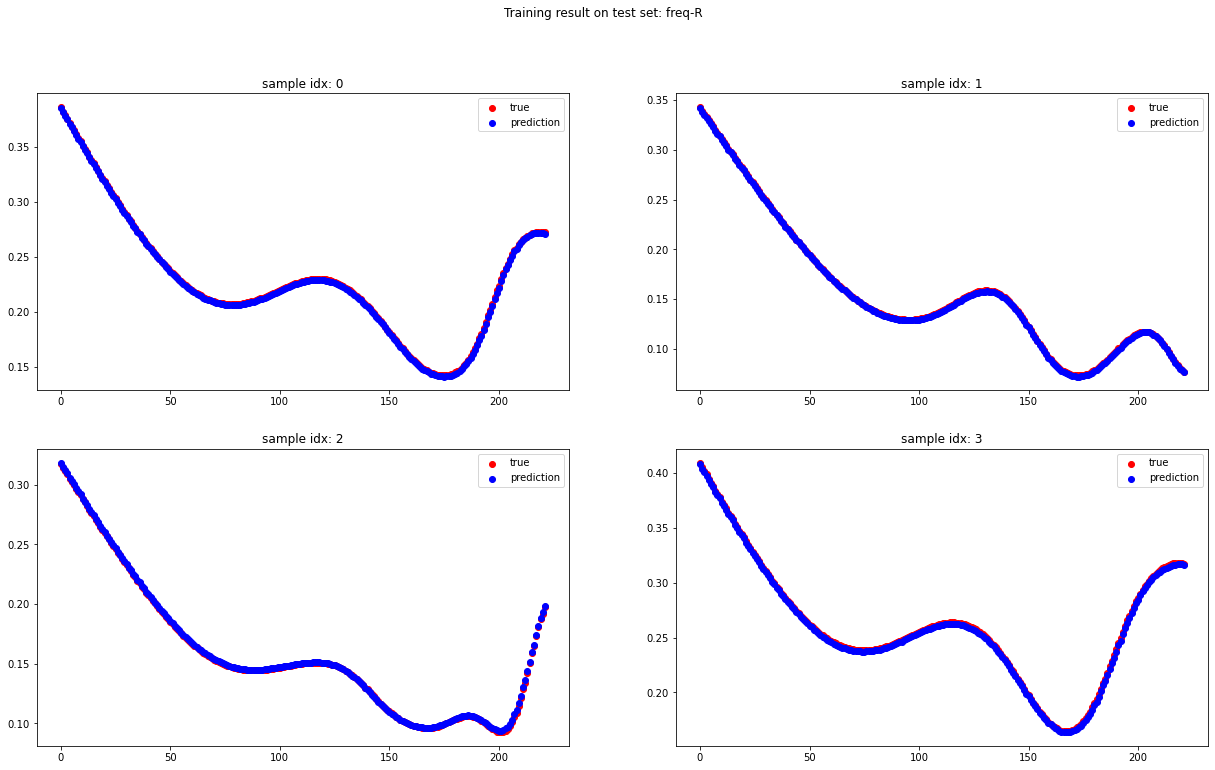

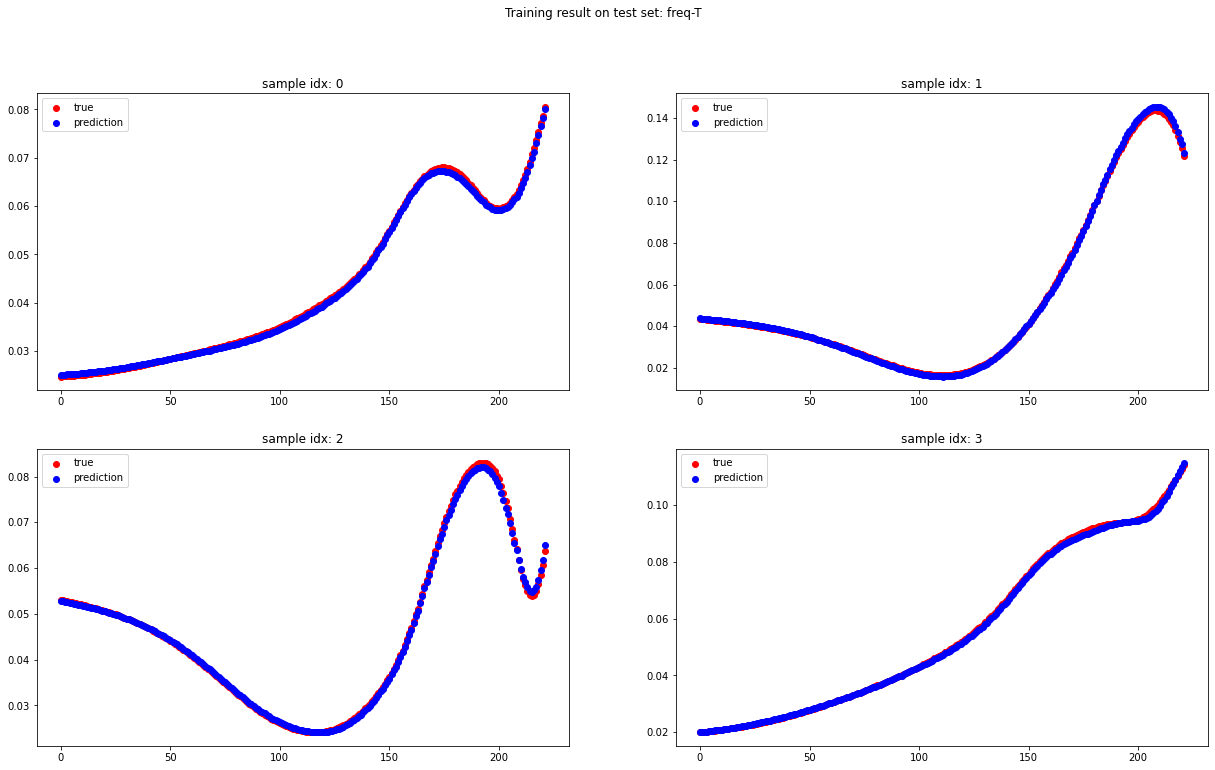

params_pick.shape: (10, 4)
params_pick: [[145. 121. 160.  75.]
 [145. 122. 160.  75.]
 [146. 121. 160.  75.]
 [146. 120. 160.  75.]
 [146. 122. 160.  75.]
 [145. 120. 160.  75.]
 [145. 123. 160.  75.]
 [147. 120. 160.  75.]
 [147. 121. 160.  75.]
 [147. 119. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


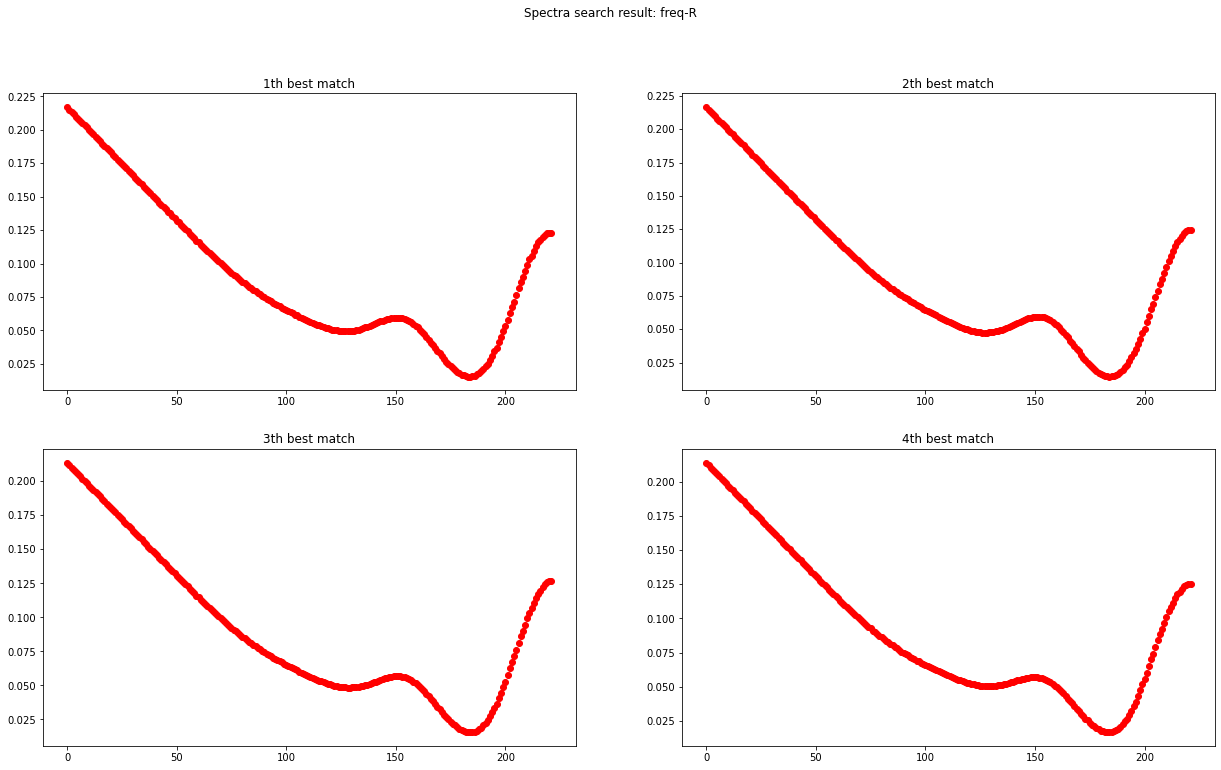

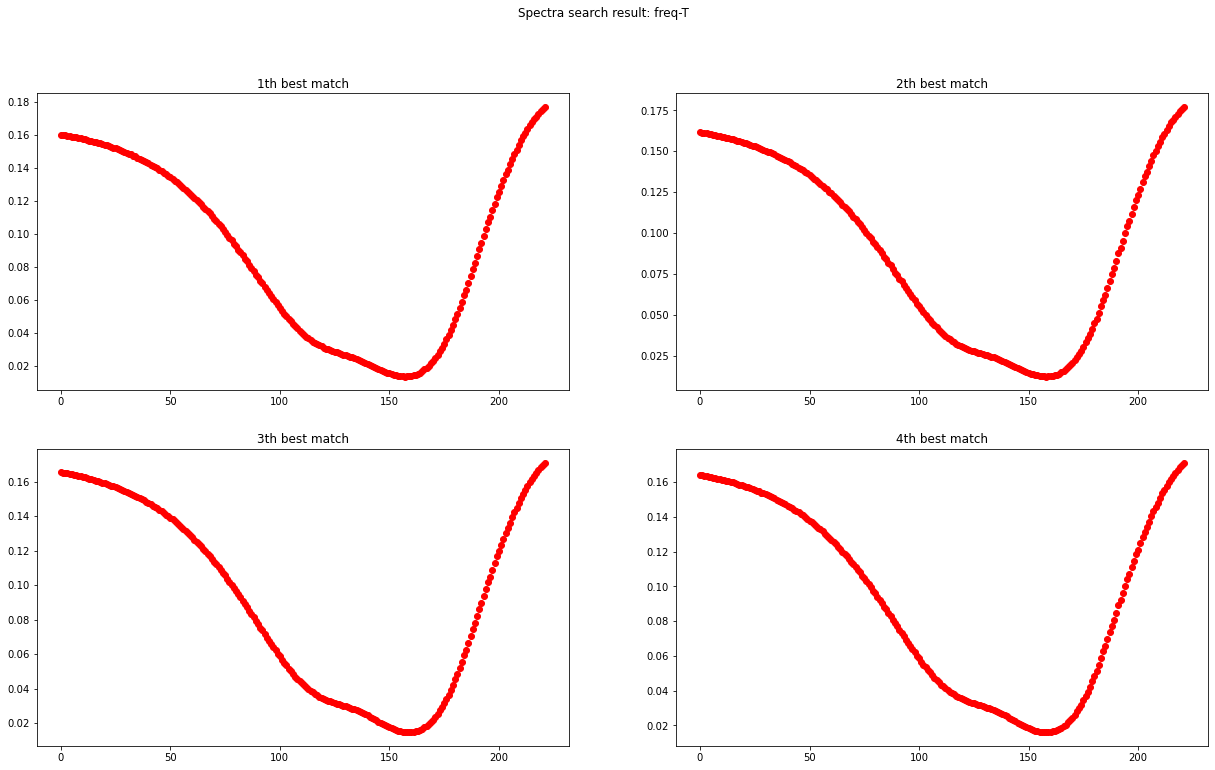

*** Reruning RCWA on picked params
params_dict.shape: (1824, 4)
R_dict.shape: (1824, 222)
T_dict.shape: (1824, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [145. 120. 160.  75.] params_pick: [145. 120. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
---------

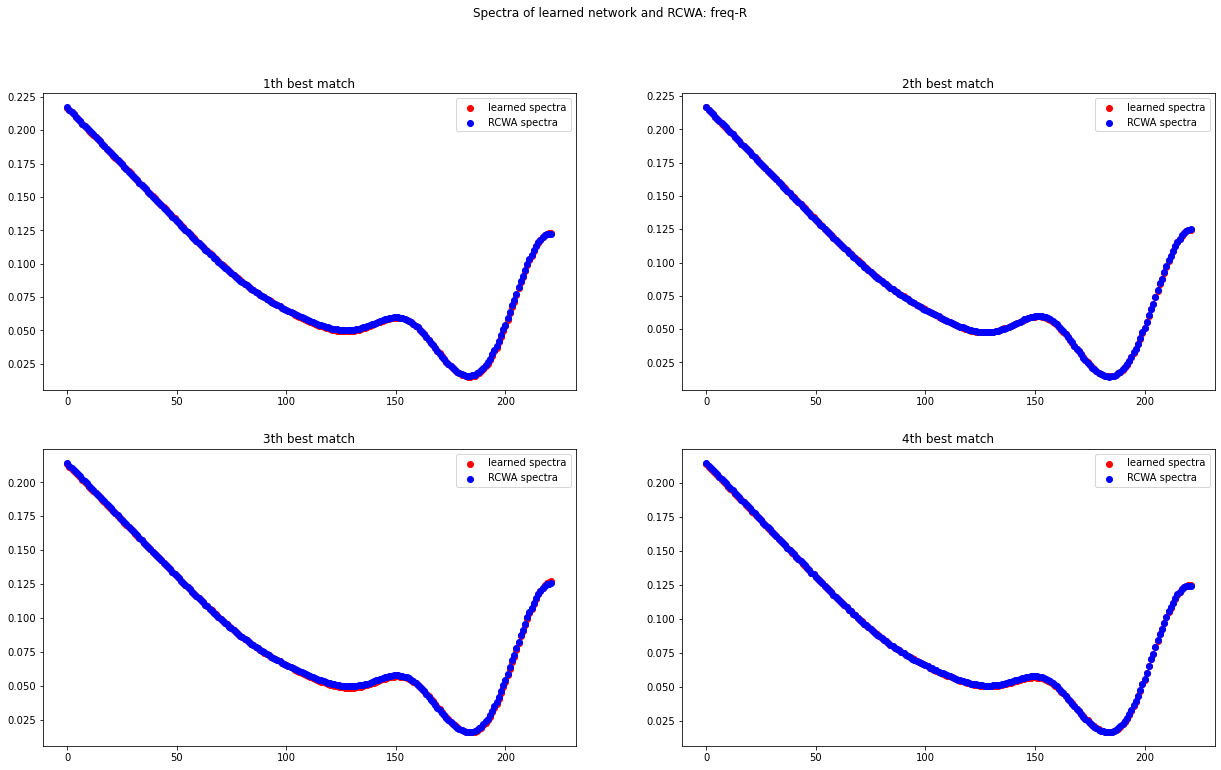

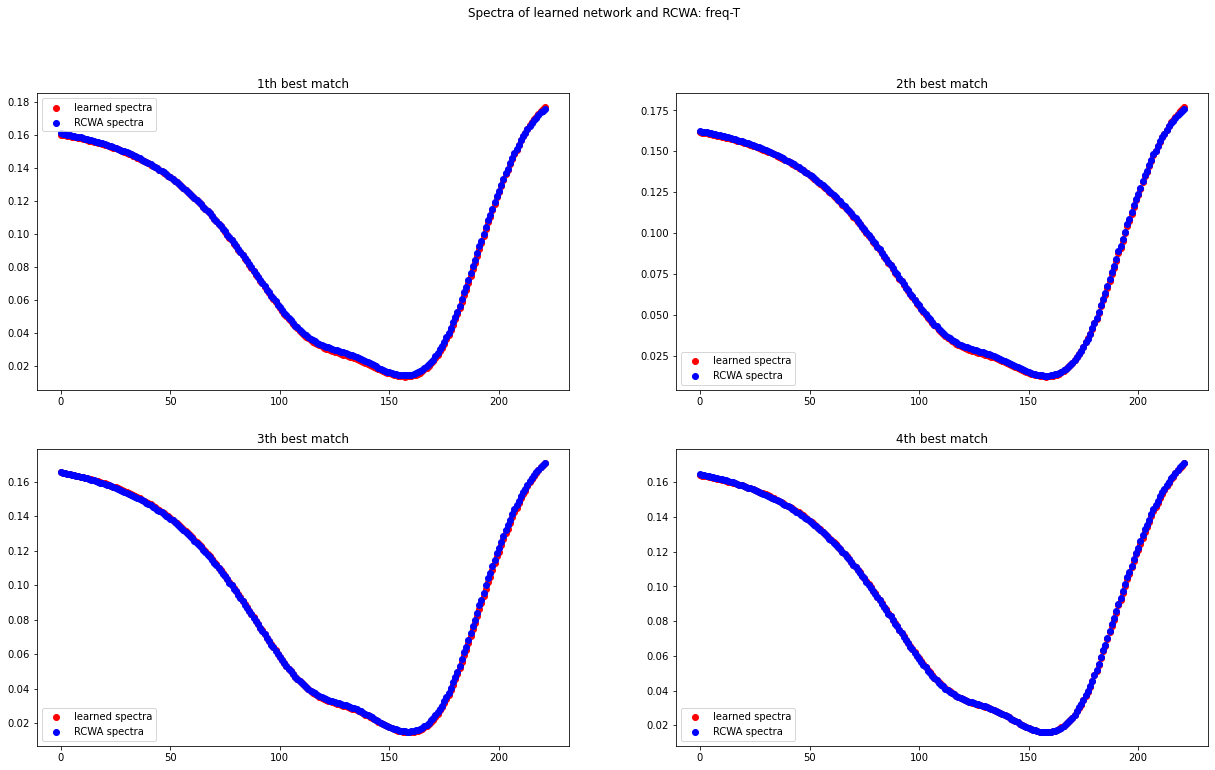

** Model saved.
**************************** ROUND 10 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 2024
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [110.  90.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [136. 109.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [105. 141.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [141.  88.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [56. 59.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [123. 135.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [80. 92.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [143.  75.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [ 67. 101.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [130.  92.]
Calculation 

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [99. 74.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [62. 62.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [145.  77.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [100. 139.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [143.  84.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [116.  51.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [128. 120.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [67. 91.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [136.  80.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [112.  59.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [117. 135.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [60. 87.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 2.1088842122384804e-05
### TEST LOSS  9.434882174959526e-05
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.3882383752624953e-05
### TEST LOSS  1.0429097499347276e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 1.1875454950416177e-05
### TEST LOSS  6.3264434145587015e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 4.69691438115458e-06
### TEST LOSS  4.691507302272986e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 4.1652327396777515e-06
### TEST LOSS  2.6235931925604686e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 2.4513611314327712e-06
### TEST LOSS  2.3010898222574108e-06
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.3209711840144993e-06
### TEST LOSS  1.559328416812106e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 9.962007497954988e-07
### TEST LOSS  5.298740061774762e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.3826958990682041e-06
### TEST LOSS  1.5143968994379975e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.3841828872345319e-06
### TEST LOSS  8.678496260839188e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 7.287503363018243e-06
### TEST LOSS  2.3596063629743333e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.6883471860661472e-06
### TEST LOSS  3.7701506038678005e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 9.424081114219507e-07
### TEST LOSS  6.032476361020423e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 7.760613365850032e-07
### TEST LOSS  7.995892056280882e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 6.47263529632105e-07
### TEST LOSS  7.57017485027738e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.122239643348509e-06
### TEST LOSS  5.647331823682531e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 7.229928790865814e-07
### TEST LOSS  4.6199116904825777e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.0815726613803807e-06
### TEST LOSS  2.832761237509511e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 6.37120470090946e-07
### TEST LOSS  4.2818732026717043e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 5.810325888178355e-07
### TEST LOSS  5.105390280571174e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.385405825239754e-07
### TEST LOSS  5.954947090275152e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.808757733700761e-07
### TEST LOSS  6.254619580108884e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.19124814249747e-07
### TEST LOSS  8.392846428162762e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.028273763380484e-07
### TEST LOSS  8.005107896414918e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 1.4385093649295328e-06
### TEST LOSS  9.584626244788758e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 1.0160680218478546e-06
### TEST LOSS  3.924184586741185e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.110360081592884e-07
### TEST LOSS  3.724803095352517e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 5.10214158820133e-07
### TEST LOSS  4.3845919101899667e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.261079492110888e-07
### TEST LOSS  2.848718021332095e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.511179792791092e-07
### TEST LOSS  4.254804751678509e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 7.400629220309547e-07
### TEST LOSS  5.648142383330607e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.466588673360032e-07
### TEST LOSS  4.335010531474015e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.246816438640925e-07
### TEST LOSS  3.708508805564106e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.009597612503883e-07
### TEST LOSS  3.472990334601843e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 7.286781760698844e-07
### TEST LOSS  4.661984282774351e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.459753162581638e-07
### TEST LOSS  4.1477374401027544e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.7618644513802804e-06
### TEST LOSS  8.525043335060716e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 8.940372434872459e-07
### TEST LOSS  6.649249707108186e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 2.177200658285991e-06
### TEST LOSS  7.309625063513639e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 8.28215944676211e-07
### TEST LOSS  1.0654009730065046e-06
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 6.668463249603336e-07
### TEST LOSS  3.8972612973368323e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 6.198725324761245e-07
### TEST LOSS  4.346121962102658e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.4423698322901545e-07
### TEST LOSS  4.6415942275387114e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.786713063882351e-07
### TEST LOSS  6.199029723663238e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.1711441011053374e-07
### TEST LOSS  3.3391322429657347e-06
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 1.0837756806950039e-06
### TEST LOSS  2.261309327144362e-06
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 9.448986046459854e-07
### TEST LOSS  5.077096037923419e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.895881062932247e-07
### TEST LOSS  6.09293336185968e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 5.067731856571626e-07
### TEST LOSS  3.715218034292247e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.6195703721179565e-07
### TEST LOSS  5.244246733215527e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.302530557988573e-07
### TEST LOSS  4.0314532615441076e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 5.641828781090105e-07
### TEST LOSS  5.195939976484594e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.9623075820306386e-07
### TEST LOSS  3.9859472350702074e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.122544751387293e-07
### TEST LOSS  1.4810973938907526e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.289218731643785e-07
### TEST LOSS  3.4910738030879243e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.400840023414169e-07
### TEST LOSS  3.527679763787854e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.3928603152419376e-07
### TEST LOSS  3.2527512233525246e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.037282509447757e-07
### TEST LOSS  7.350879330612858e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.85372534930882e-07
### TEST LOSS  4.3101666110047633e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 5.281963932287237e-07
### TEST LOSS  3.474524437625669e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.524574634324574e-07
### TEST LOSS  4.638756530722833e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.76998237518141e-07
### TEST LOSS  4.6189170039988604e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.962386303197246e-07
### TEST LOSS  5.024479202303713e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.6187674513138926e-07
### TEST LOSS  9.55038796834537e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.2699524871897826e-07
### TEST LOSS  3.307745356184363e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.219348275284186e-07
### TEST LOSS  2.5372980551016934e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.9887176337694974e-07
### TEST LOSS  3.234343476914282e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.0714344268244235e-07
### TEST LOSS  2.950109017862609e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 7.771899847340322e-07
### TEST LOSS  4.3081744325395597e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.4475990334641163e-07
### TEST LOSS  5.814715787862717e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.8658092518433124e-07
### TEST LOSS  3.061235508810921e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.554130520267018e-07
### TEST LOSS  3.6880762873777475e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.797433245800394e-07
### TEST LOSS  5.738869934967008e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.567491298381102e-07
### TEST LOSS  3.7602348635529426e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.004253733589395e-07
### TEST LOSS  3.375805434760907e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.23705994750089e-07
### TEST LOSS  1.5267105720428638e-06
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.5982234196470045e-07
### TEST LOSS  2.91149561807317e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.957958101904552e-07
### TEST LOSS  2.540773117919842e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.933645388129952e-07
### TEST LOSS  2.8887109879765525e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.1440434876172805e-07
### TEST LOSS  6.04510166941773e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.9869367641675135e-07
### TEST LOSS  2.4009086343407795e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 4.013155496736819e-07
### TEST LOSS  5.514404497188803e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.6386468856486154e-07
### TEST LOSS  5.128505656850921e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.906166102089644e-07
### TEST LOSS  3.643362025550525e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.807613906572654e-07
### TEST LOSS  3.35482860874993e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.9150886712114896e-07
### TEST LOSS  4.61501384147449e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.436708831614229e-07
### TEST LOSS  6.056018915592909e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.724887085548702e-07
### TEST LOSS  4.300798687220395e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.2398868294178466e-07
### TEST LOSS  3.090737678693615e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.944117848113036e-07
### TEST LOSS  3.5694920636468586e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.970802612129415e-07
### TEST LOSS  3.007864636071733e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.862990068721843e-07
### TEST LOSS  3.291542831844239e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.239876656668072e-07
### TEST LOSS  5.082662732269044e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.823371421518343e-07
### TEST LOSS  3.055476665372959e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.585595056456304e-07
### TEST LOSS  4.640025440861087e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.8514302193507405e-07
### TEST LOSS  2.5171022484975705e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.7144522485577353e-07
### TEST LOSS  3.295669819914521e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.812997684444772e-07
### TEST LOSS  4.6206729705538176e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.599513065178113e-07
### TEST LOSS  3.0704743934503285e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.580025650018295e-07
### TEST LOSS  2.299809290390488e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.9007675852079826e-07
### TEST LOSS  5.369230017725884e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.851091571066973e-07
### TEST LOSS  2.661760002946457e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.5756276205765647e-07
### TEST LOSS  2.6591624008130654e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.6196644551419244e-07
### TEST LOSS  2.4747475844921406e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.320921093358703e-07
### TEST LOSS  3.798593430628311e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.6820730218007486e-07
### TEST LOSS  4.166563705380653e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.363067953940862e-07
### TEST LOSS  3.14266020862511e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.279378310214593e-07
### TEST LOSS  4.0995190748881506e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.4238437684843576e-07
### TEST LOSS  2.698003678534083e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.4217411161677147e-07
### TEST LOSS  2.991402314386681e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.8208859348665397e-07
### TEST LOSS  3.645363514417641e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.48405484575027e-07
### TEST LOSS  2.6439885773250413e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.560297219078459e-07
### TEST LOSS  3.061142473554003e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.434451001327859e-07
### TEST LOSS  2.464926284016744e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.264093962654489e-07
### TEST LOSS  3.442677077894205e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.693870579777395e-07
### TEST LOSS  5.028569242151735e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.762066514842422e-07
### TEST LOSS  3.089391076437389e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.723968527205568e-07
### TEST LOSS  3.5024352668290615e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 4.086108379031468e-07
### TEST LOSS  2.7851053901838074e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.643042292050221e-07
### TEST LOSS  3.196820049681499e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.1514159703072625e-07
### TEST LOSS  3.0218625342528073e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.263565232981358e-07
### TEST LOSS  3.040666071331455e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.0371803356796157e-07
### TEST LOSS  2.550924765757607e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.2117990405683394e-07
### TEST LOSS  3.1187529668474577e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.71328566169549e-07
### TEST LOSS  2.339796260971085e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.972356426992752e-07
### TEST LOSS  3.0237873670191016e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.2540893176369146e-07
### TEST LOSS  2.559941273441455e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.3713102125073435e-07
### TEST LOSS  2.052539281477596e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.5530317170971215e-07
### TEST LOSS  4.457716457754061e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.0785136876863833e-07
### TEST LOSS  3.4594572093004486e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.4641130187112246e-07
### TEST LOSS  8.579999424059239e-07
----------------------------------------------------------------------
*** EPOCH 1118 || AVG LOSS 3.6469161017027224e-07
### TEST LOSS  3.403836749091551e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.812389576063379e-07
### TEST LOSS  2.7241498083830883e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.1621427970419874e-07
### TEST LOSS  5.327356074846443e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.804643507252848e-07
### TEST LOSS  3.606502451519543e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.8899038903192057e-07
### TEST LOSS  2.886676763717978e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.6360895086945816e-07
### TEST LOSS  2.9029287968422713e-07
----------------------------------------------------------------------
*** EPOCH 1170 || AVG LOSS 3.956213338975775e-07
### TEST LOSS  2.7181765735730876e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.5478063386711633e-07
### TEST LOSS  3.2963778276171654e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.416188899685796e-07
### TEST LOSS  3.5470644239731265e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.2042710057193563e-07
### TEST LOSS  3.696994854767728e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.7553888236097766e-07
### TEST LOSS  2.651232908911263e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.1145347180872646e-07
### TEST LOSS  3.967529930686132e-07
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 3.076193139532223e-07
### TEST LOSS  3.7314809593490573e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.315175332635983e-07
### TEST LOSS  2.1202540775418804e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.2591929856828467e-07
### TEST LOSS  2.5666453633411655e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.0183226551241804e-07
### TEST LOSS  2.4937103152326254e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.277935569285672e-07
### TEST LOSS  2.410818340084945e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.508786688191645e-07
### TEST LOSS  5.259937634696877e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 3.469115584696748e-07
### TEST LOSS  2.724144110288762e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.9919624078895094e-07
### TEST LOSS  4.7230748493582784e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.474402701212095e-07
### TEST LOSS  2.069448456612947e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.2945264669181246e-07
### TEST LOSS  2.167196294250619e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.0028008557842745e-07
### TEST LOSS  2.3999213650063945e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.051741873996431e-07
### TEST LOSS  3.31723675395962e-07
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 3.373233121225852e-07
### TEST LOSS  3.6965192403811433e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.3743069158320044e-07
### TEST LOSS  3.121932155086289e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.1350095966563235e-07
### TEST LOSS  3.7664336475480074e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 6.468751419841949e-07
### TEST LOSS  3.8336412536233597e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.3199137802763934e-07
### TEST LOSS  3.488842708065931e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.0754160982111684e-07
### TEST LOSS  2.5414009397287196e-07
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 3.0918834065712963e-07
### TEST LOSS  2.915996612918823e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 8.523613552904643e-07
### TEST LOSS  4.997934875137293e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 5.120583094933211e-07
### TEST LOSS  6.57336829957081e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.681093582100566e-07
### TEST LOSS  3.6481009421931374e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.5729411548670353e-07
### TEST LOSS  3.42165785769471e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.373633150440699e-07
### TEST LOSS  2.2032912601198697e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 3.426977213029035e-07
### TEST LOSS  8.696052524951923e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 3.3609021480575213e-07
### TEST LOSS  2.791791881544404e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.035792417151157e-07
### TEST LOSS  2.614599901745908e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.824709560327356e-07
### TEST LOSS  3.7227986680473777e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.905941994194236e-07
### TEST LOSS  2.660963988795805e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.053753353762669e-07
### TEST LOSS  1.9926719990199936e-07
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 3.254120469801645e-07
### TEST LOSS  2.679576206512666e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.210547711128624e-07
### TEST LOSS  2.3792881987197512e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.6161291225004444e-07
### TEST LOSS  3.396806996827382e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.1053853968744455e-07
### TEST LOSS  3.0917556984839454e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.3332211196175276e-07
### TEST LOSS  2.648677650540776e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.2091605271026547e-07
### TEST LOSS  3.31277545324009e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 3.416113753542645e-07
### TEST LOSS  2.8588890692786194e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.031463877569055e-07
### TEST LOSS  3.2479883270386177e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.1998703674466006e-07
### TEST LOSS  2.9154399691554814e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.216884435378909e-07
### TEST LOSS  4.017881711925222e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.1837491808826074e-07
### TEST LOSS  3.915103905587931e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.6210855279928855e-07
### TEST LOSS  6.034955265843769e-07
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 3.30000125646386e-07
### TEST LOSS  2.7907067498466445e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.0671434864543706e-07
### TEST LOSS  3.8095530343188357e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.3330720812074555e-07
### TEST LOSS  4.499435887385428e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.03432810738856e-07
### TEST LOSS  2.4874503741366717e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.096737835595185e-07
### TEST LOSS  3.0719553066201997e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.2971812442383675e-07
### TEST LOSS  2.658767664526397e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 2.985612582195479e-07
### TEST LOSS  3.19455411514472e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.142092841547257e-07
### TEST LOSS  2.629624855070424e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.9973273602934336e-07
### TEST LOSS  3.247521917618571e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.0713642863080465e-07
### TEST LOSS  3.555070998301392e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.817527552453562e-07
### TEST LOSS  2.5591373470536294e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.042136269349212e-07
### TEST LOSS  3.868381530801637e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 2.882979449794271e-07
### TEST LOSS  2.3235446450041397e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.306000005120212e-07
### TEST LOSS  2.1721577987195374e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.078426527552201e-07
### TEST LOSS  2.811212000104264e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.94133516446847e-07
### TEST LOSS  8.002456260944581e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.4654248655566944e-07
### TEST LOSS  2.3828301671587283e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.987755219356718e-07
### TEST LOSS  2.7475268569237563e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 2.9187790410962106e-07
### TEST LOSS  2.2808817934014036e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.995530848754868e-07
### TEST LOSS  2.463180682217435e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 3.5088903486798317e-07
### TEST LOSS  3.0050165332428856e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.9635349014315443e-07
### TEST LOSS  8.777502414652132e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.763653798572203e-07
### TEST LOSS  2.7667896017280123e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 3.0072386573553805e-07
### TEST LOSS  2.646847581254699e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 3.084672617776071e-07
### TEST LOSS  3.1476278054249694e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 3.172495666398693e-07
### TEST LOSS  2.0087652327190647e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.1798603413467513e-07
### TEST LOSS  3.4508280849319905e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.8482010279654235e-07
### TEST LOSS  3.293918483347713e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.975127211915935e-07
### TEST LOSS  3.0806318539860866e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.8935755357440873e-07
### TEST LOSS  2.5712785878978695e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 3.126911374379106e-07
### TEST LOSS  3.406936053990296e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 4.540635765677873e-07
### TEST LOSS  1.9035644160589249e-06
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 3.812338386795359e-07
### TEST LOSS  2.150243927285227e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 3.211582211220714e-07
### TEST LOSS  4.670550265106407e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.9177580434136763e-07
### TEST LOSS  2.460689189327299e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.01201304065077e-07
### TEST LOSS  2.3274275180952946e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 2.709007832287029e-07
### TEST LOSS  2.930623428519832e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 3.167186002298116e-07
### TEST LOSS  2.523476564053248e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.842852418592718e-07
### TEST LOSS  3.08980610674142e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.875029457895399e-07
### TEST LOSS  2.652362699366002e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.8702263066063127e-07
### TEST LOSS  2.4512189611414215e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.950695978586164e-07
### TEST LOSS  2.647956843900594e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 3.23436323282213e-07
### TEST LOSS  2.37035475118964e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.960420430150758e-07
### TEST LOSS  4.158506104915667e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.947976695614332e-07
### TEST LOSS  2.406886150743782e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.003693649677547e-07
### TEST LOSS  2.3876710489759953e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.337166049753269e-07
### TEST LOSS  6.566727704686796e-07
** loss_train 3.337166049753269e-07
** loss_test 6.566727704686796e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


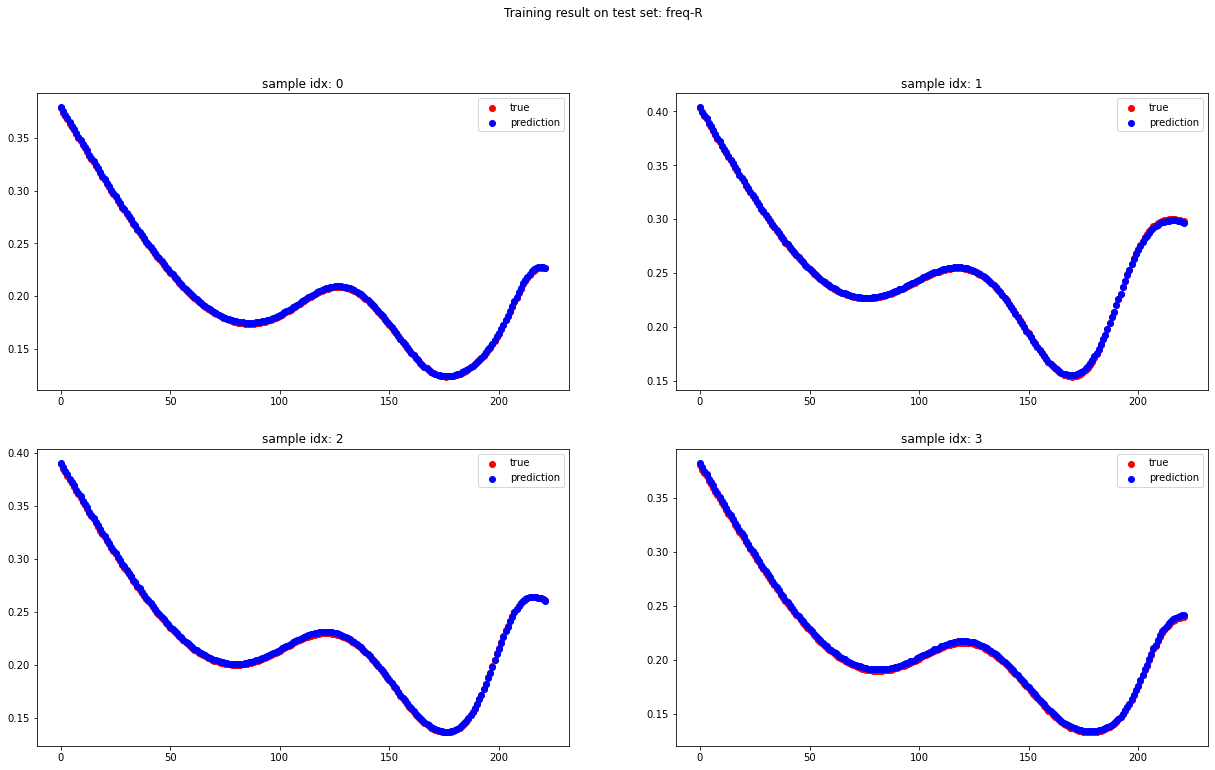

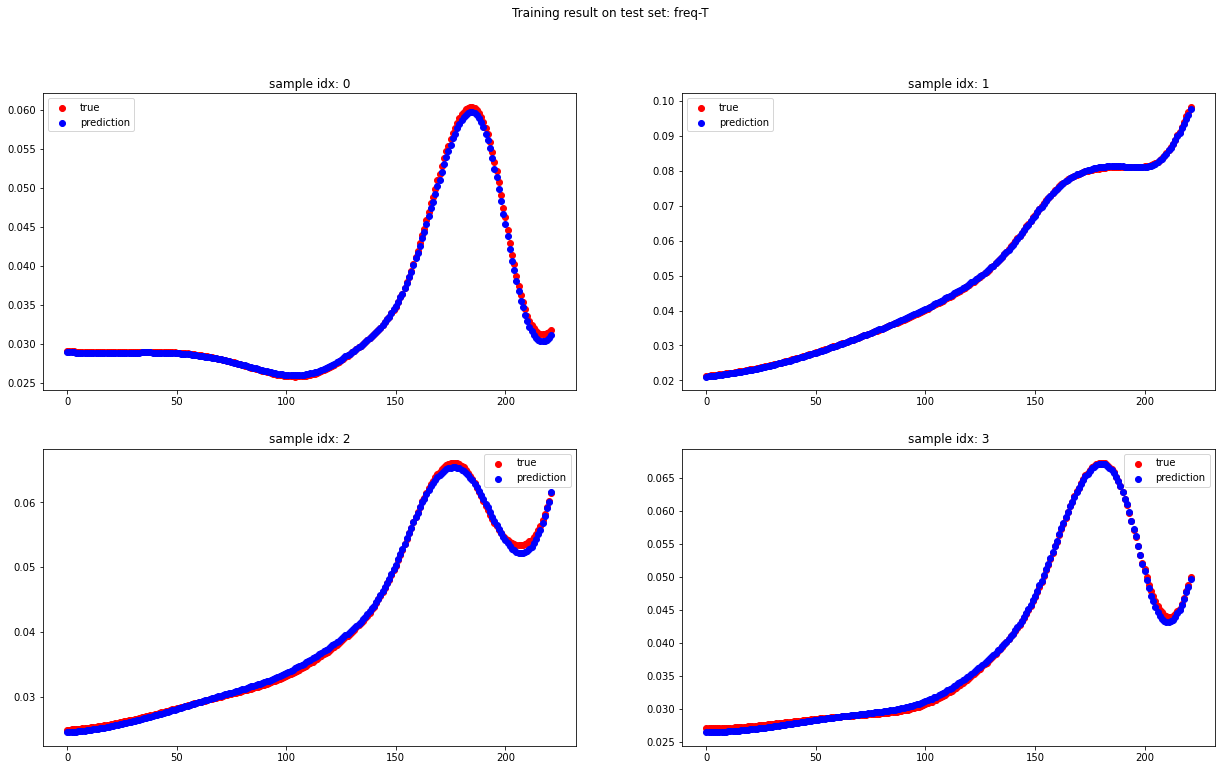

params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [146. 120. 160.  75.]
 [147. 120. 160.  75.]
 [147. 121. 160.  75.]
 [146. 122. 160.  75.]
 [147. 122. 160.  75.]
 [146. 119. 160.  75.]
 [146. 123. 160.  75.]
 [147. 119. 160.  75.]
 [145. 121. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


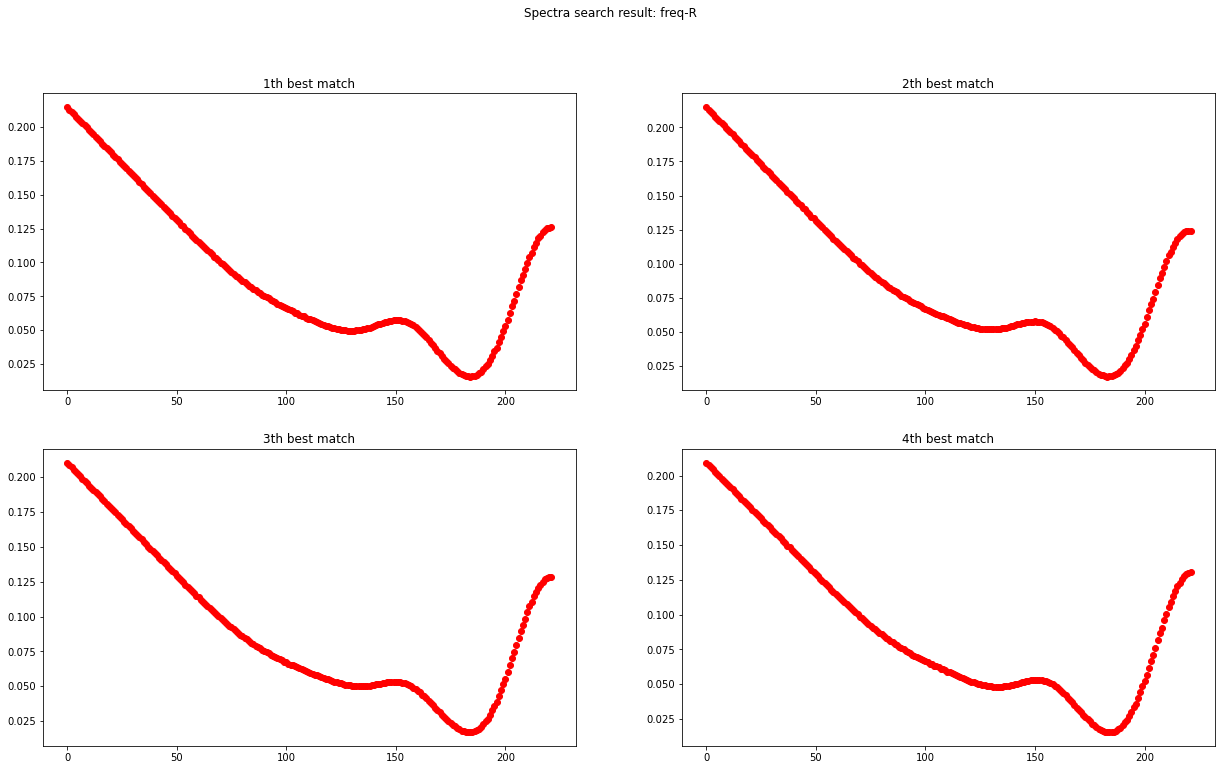

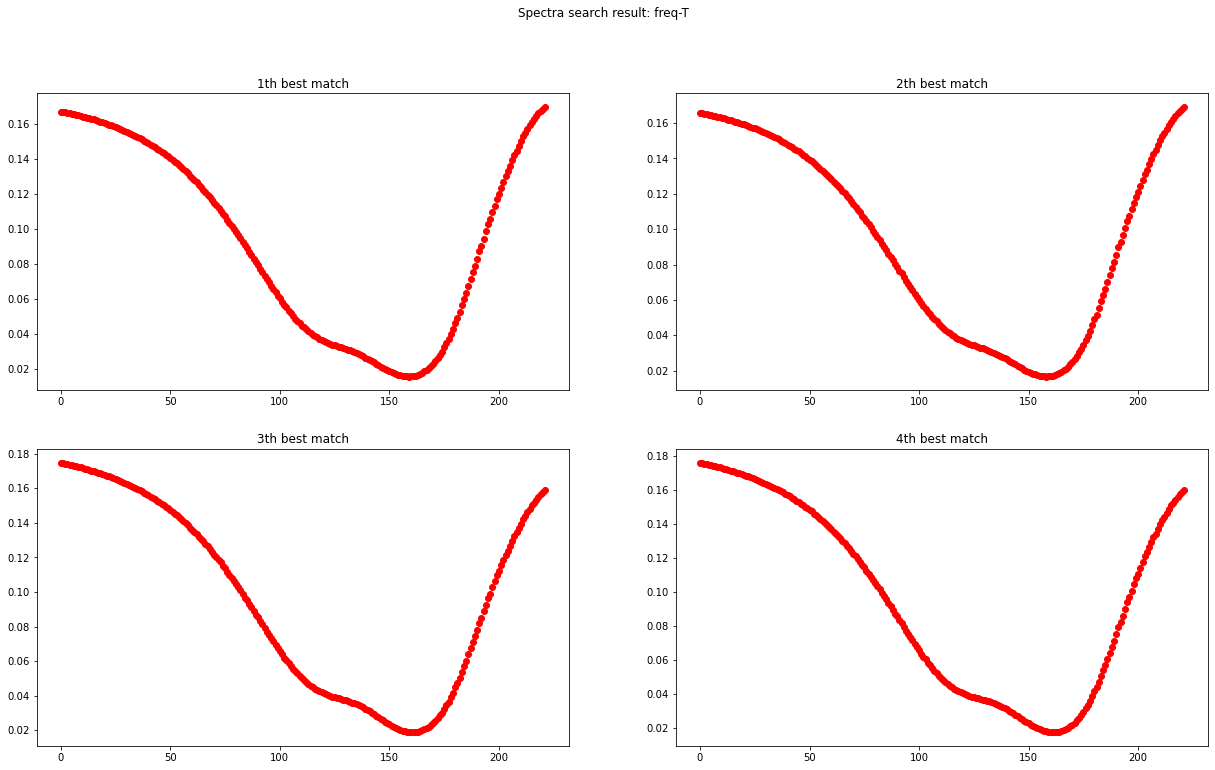

*** Reruning RCWA on picked params
params_dict.shape: (2024, 4)
R_dict.shape: (2024, 222)
T_dict.shape: (2024, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [147. 120. 160.  75.] params_pick: [147. 120. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [146. 119. 160.  75.] params_pick: [146. 119. 160.  75.]
---------

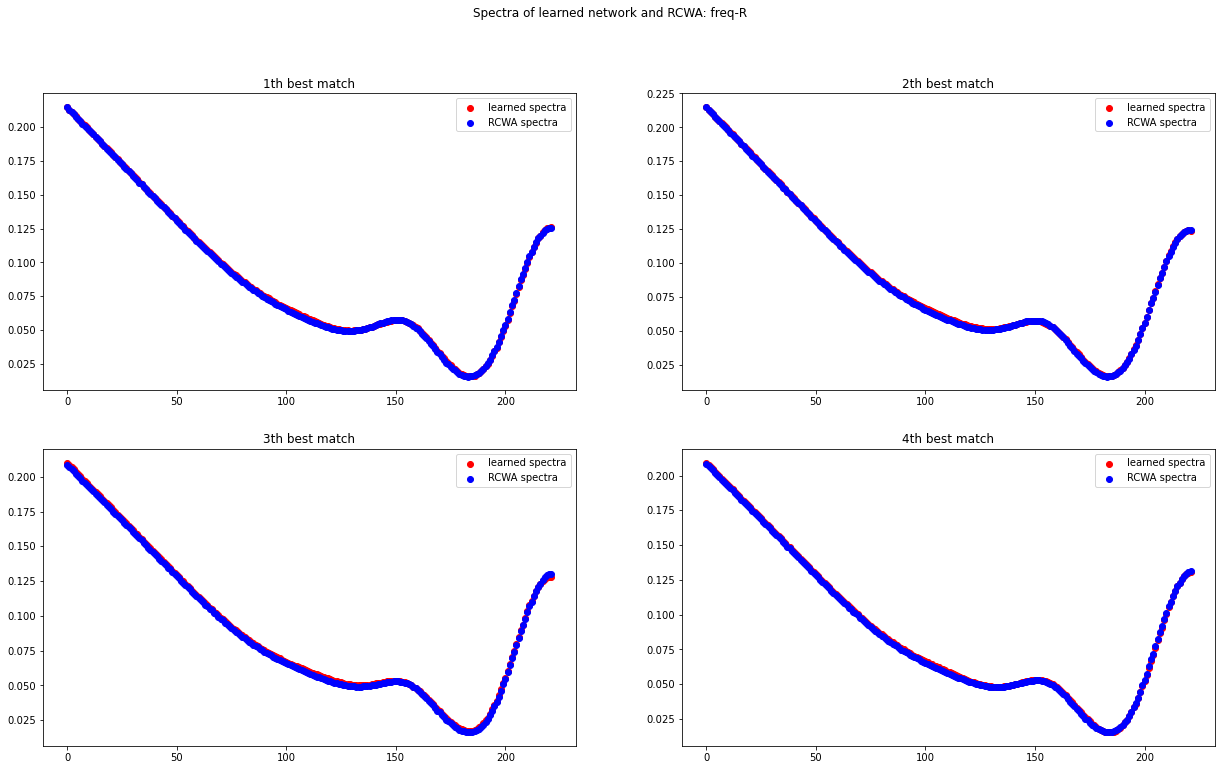

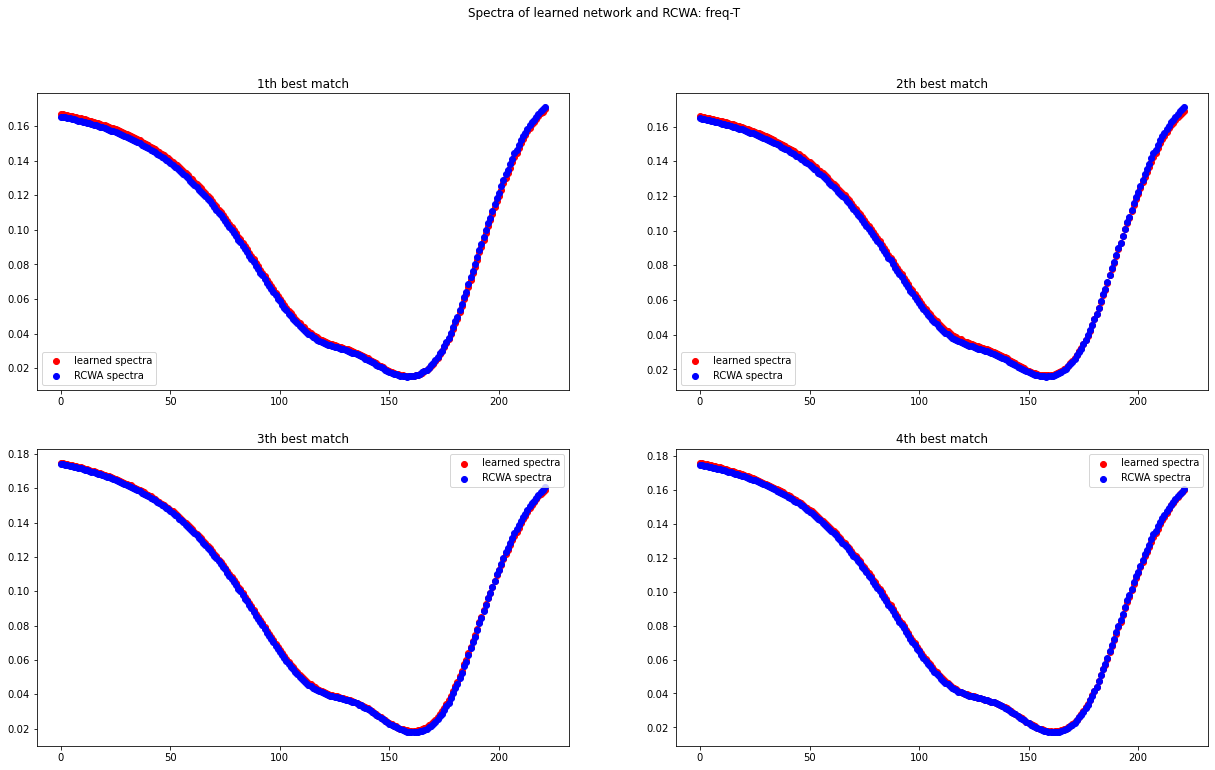

** Model saved.
**************************** ROUND 11 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 2224
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [118.  79.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [107.  97.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [134.  94.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 90. 100.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 81. 106.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [103.  77.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [51. 69.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [93. 67.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [63. 75.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 89. 101.]
Calculation Pr

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [108.  70.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [141. 135.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [149. 125.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [120. 119.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [113.  68.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [137. 120.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [88. 56.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [133. 137.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [71. 94.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [116.  83.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [144.  84.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [68. 70.]
Calculation Progress: 100%
-------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 2.0149307363272403e-05
### TEST LOSS  6.658584756865715e-05
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 6.558070486380755e-06
### TEST LOSS  2.1256442637957876e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 3.6708415583905024e-06
### TEST LOSS  4.7752088087637436e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 3.5723927397999615e-06
### TEST LOSS  1.7753981383601273e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.7012898026114023e-06
### TEST LOSS  2.5004602481631617e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 2.5452678135116554e-06
### TEST LOSS  1.0265809999723655e-06
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 4.840227229554478e-07
### TEST LOSS  7.052661333893732e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 9.718126136716866e-07
### TEST LOSS  4.818138337976266e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 9.44995234783399e-07
### TEST LOSS  6.293963010380941e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 5.63120021778075e-07
### TEST LOSS  6.085445843449205e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 7.525832606807074e-07
### TEST LOSS  4.1727809098253656e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 5.124598138070085e-07
### TEST LOSS  5.368212570414578e-07
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 4.122532836542363e-07
### TEST LOSS  4.786323753545302e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 3.825569280238923e-07
### TEST LOSS  6.699795061221641e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 4.196008579106925e-07
### TEST LOSS  4.0328119238812874e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 4.6498772021115634e-07
### TEST LOSS  4.586411150472379e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 4.392097065993677e-07
### TEST LOSS  4.355184703332698e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 4.072821623874101e-07
### TEST LOSS  4.399830853638859e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 4.19282632961503e-07
### TEST LOSS  4.5881795993890964e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 3.7073788583131027e-07
### TEST LOSS  4.546778464319847e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 3.9379003841938815e-07
### TEST LOSS  3.2282787204247356e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 3.8774159651219116e-07
### TEST LOSS  3.7132727219854773e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 3.982143364935727e-07
### TEST LOSS  4.764625400104491e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 3.7314617761553067e-07
### TEST LOSS  3.3611584375889565e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 3.706319498079675e-07
### TEST LOSS  2.2580969481195473e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 3.583936115027669e-07
### TEST LOSS  2.7392934665680086e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 3.461731462387429e-07
### TEST LOSS  3.612296448890822e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 3.53068294589507e-07
### TEST LOSS  2.7093126759074735e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 3.435109641596435e-07
### TEST LOSS  2.6939627543122374e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 3.5298264471542344e-07
### TEST LOSS  2.911576080364017e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 3.598329779114029e-07
### TEST LOSS  2.8961779379950017e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 3.317761662133327e-07
### TEST LOSS  3.3838233088759166e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 3.555148760505123e-07
### TEST LOSS  3.662822265101461e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 3.333129440022897e-07
### TEST LOSS  3.5484681859543343e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 3.81983817603061e-07
### TEST LOSS  3.6851721695123106e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 3.420141754123409e-07
### TEST LOSS  3.396167475871687e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.8701543168767654e-07
### TEST LOSS  6.481284545396406e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.7256530249055194e-07
### TEST LOSS  3.1894715052056413e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 3.744157107464298e-07
### TEST LOSS  5.168550421117021e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.676862917196151e-07
### TEST LOSS  3.997654436502404e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.448202161726029e-07
### TEST LOSS  3.46193942010252e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.8362327285247683e-07
### TEST LOSS  3.187933602328699e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.905868130222276e-07
### TEST LOSS  2.578508161497987e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.243785558474083e-07
### TEST LOSS  4.7814167955681e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.834167370799795e-07
### TEST LOSS  2.9632669734984816e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.37860771664312e-07
### TEST LOSS  3.2788711771846624e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.594237316414371e-07
### TEST LOSS  2.29934259971956e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.061177034751413e-07
### TEST LOSS  3.580867555416155e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.997124792465119e-07
### TEST LOSS  3.565619809866321e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.2111564339950206e-07
### TEST LOSS  4.0078735540806947e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.3628595766887635e-07
### TEST LOSS  3.008917024558019e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.325253626520331e-07
### TEST LOSS  2.3361166366070768e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.10079035056845e-07
### TEST LOSS  4.202810376842963e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.3106258080594236e-07
### TEST LOSS  3.043842966957634e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.7213724246427787e-07
### TEST LOSS  3.2470912923171827e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.241701413202849e-07
### TEST LOSS  3.0400701856545793e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.202700138938343e-07
### TEST LOSS  4.959825223990907e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.0937553695143175e-07
### TEST LOSS  3.4385776108833584e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 1.22551415915009e-06
### TEST LOSS  1.4808071769574086e-06
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.605923934651061e-07
### TEST LOSS  2.8355476607256446e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.2490086882117534e-07
### TEST LOSS  2.865332947642267e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.123661813804957e-07
### TEST LOSS  4.122017028360942e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.407823494170172e-07
### TEST LOSS  3.1181433717406166e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.311978331204864e-07
### TEST LOSS  3.382409165824891e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.08049491503644e-07
### TEST LOSS  2.276663605350811e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 1.446697660508572e-06
### TEST LOSS  1.1871143990848555e-05
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.481939363631068e-07
### TEST LOSS  2.838934153380572e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.3124694466505367e-07
### TEST LOSS  2.230820483111315e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.3957512822510005e-07
### TEST LOSS  4.7507119367818473e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.689862886969876e-07
### TEST LOSS  3.8508988270076074e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.322900944090961e-07
### TEST LOSS  2.556689655280559e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.144369032806001e-07
### TEST LOSS  3.503021968707371e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.4606020355156584e-07
### TEST LOSS  2.9280073142538585e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.092126094876649e-07
### TEST LOSS  2.9837254967400013e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.121762220476598e-07
### TEST LOSS  3.179523183823275e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.212144550498109e-07
### TEST LOSS  2.7040247771611466e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.335987988552674e-07
### TEST LOSS  6.86657107748675e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.2060272643400686e-07
### TEST LOSS  2.2595082406403035e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 2.922655390835853e-07
### TEST LOSS  5.458013251815347e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.2772660139556385e-07
### TEST LOSS  3.017501245996273e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.2638467447985296e-07
### TEST LOSS  6.082713188040062e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.013025873276095e-07
### TEST LOSS  4.257349380221807e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.042551828050743e-07
### TEST LOSS  4.3424195690236316e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.4665322609311036e-07
### TEST LOSS  2.9878554302593543e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.2435108365094797e-07
### TEST LOSS  2.6505307209176594e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.064127835154796e-07
### TEST LOSS  9.50829960335314e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.270687692814426e-07
### TEST LOSS  3.163281309572513e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.329687048535127e-07
### TEST LOSS  4.1860794443865043e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.0045339889820254e-07
### TEST LOSS  3.20160368386603e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.8506925833402835e-07
### TEST LOSS  2.0987329960194877e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.2786684563065386e-07
### TEST LOSS  2.7828011811232714e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.0070906908586146e-07
### TEST LOSS  3.093098575177197e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 2.9800582351362865e-07
### TEST LOSS  3.2507275365640667e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.004679512383508e-07
### TEST LOSS  2.225105098867008e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 2.970989209310209e-07
### TEST LOSS  3.432071940110023e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 2.928740442602878e-07
### TEST LOSS  2.593311855454939e-07
-----------------------------------------------------------

KeyboardInterrupt: 

In [6]:
loss_tolerance = 1e-3
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA Simulation Prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# make data dir if necessary
if not os.path.exists('./data/' + path_material_name + '/'):
    os.makedirs('./data/' + path_material_name + '/')

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 7  # RCWA accuracy, higher to be more accurate, use 7 for speed
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]

# ====== Generate Pseudo Params, [D1, D2] ======
range_D1 = [50,150,1]  # [range_start, range_end, step_size]
range_D2 = [50,150,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
# print(pseudo_params_D1_D2.shape)
# print(pseudo_params_D1_D2[-1])
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)  # [D1,D2,a,t]
# print(pseudo_params.shape)
# print(pseudo_params[0])

# ====== Define Target Spectra ======
tg_idx_freq_R = np.array([129])
tg_value_R = np.array([0.03])
tg_idx_freq_T = np.array([0, 167])
tg_value_T = np.array([0.23, 0.])
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Simulation ======
    num_data = 200
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params, R, T = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True)
    print('params.shape:', params.shape)
    print('R.shape:', R.shape)
    print('T.shape:', T.shape)
    
    # save all data
    path_all_data_round = './data/' + path_material_name + '/all_data_' + path_material_name + '_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params, R=R, T=T)
    print('** Round data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_all = params
        R_all = R
        T_all = T
    else:
        params_all = np.concatenate((params_all, params), axis=0)
        R_all = np.concatenate((R_all, R), axis=0)
        T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)
    print('R_all.shape:', R_all.shape)
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data_' + path_material_name + '.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('** All Rounds data saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 20
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # import network
    if ROUND==1:
        dim_in = params_all.shape[-1]  # N_param
        dim_out = R_all.shape[-1]  # N_freq
        net_dense = DenseConvTranspose1D(dim_in,dim_out)
        net_dense = net_dense.to(device)
    
    # *** train network
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    scheduler = None
    N_epoch = 2000  # number of epochs trained
    loss_train, loss_test = training_utils.train_model(dataloader, dataloader_test, optimizer, criteon, net_dense, device, NUM_EPOCH=N_epoch, scheduler=scheduler)
    print('** loss_train', loss_train)
    print('** loss_test', loss_test)
    
    # visualize spectra on test set
    visualize_trained_net(dataloader_test)
    
    
    # ====== Spectra Search ======
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, net_dense, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    params_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('params_pick.shape:', params_pick.shape)
    print('params_pick:', params_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
    visualize_spectra_search(params_pick, R_pick, T_pick)
    
    
    # ====== Run RCWA Search on Picked Params ======
    # add param dict check here to save more time
    print('*** Reruning RCWA on picked params')
    if ROUND==1:
        params_dict = params_all
        R_dict = R_all
        T_dict = T_all
    else:
        params_dict = np.concatenate((params_dict, params), axis=0)
        R_dict = np.concatenate((R_dict, R), axis=0)
        T_dict = np.concatenate((T_dict, T), axis=0)
    print('params_dict.shape:', params_dict.shape)
    print('R_dict.shape:', R_dict.shape)
    print('T_dict.shape:', T_dict.shape)
    
    rerun_params, R_simu, T_simu = np.zeros_like(params_pick), np.zeros_like(R_pick), np.zeros_like(T_pick)
    for idx_pick in range(R_pick.shape[0]):  # for each in N_top
        print('--------------------')
        print(idx_pick+1, 'th match')
        if np.any(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)):  # if picked params already in the dict
            print('Already in the dict.')
            idx_same = np.argwhere(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)==True)[0].squeeze()  # get the idx in the dict
            print('# params_dict:', params_dict[idx_same], 'params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = params_dict[idx_same][np.newaxis,...], R_dict[idx_same][np.newaxis,...], T_dict[idx_same][np.newaxis,...]
        else:  # picked params not in the dict, call rcwa solver
            print('Not in the dict, calling RCWA...')
            params_pick_rcwa = params_pick[idx_pick][np.newaxis,...]
            print('# params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=params_pick_rcwa)
            # add unseen simu data into dict
            params_dict = np.concatenate((params_dict, rerun_params_i), axis=0)
            R_dict = np.concatenate((R_dict, R_simu_i), axis=0)
            T_dict = np.concatenate((T_dict, T_simu_i), axis=0)
        rerun_params[idx_pick], R_simu[idx_pick], T_simu[idx_pick] = rerun_params_i, R_simu_i, T_simu_i
    # save the dict
    path_dict = './data/' + path_material_name + '/data_dict_' + path_material_name + '.npz'
    np.savez(path_dict, params=params_dict, R=R_dict, T=T_dict)
    print('** Dict data saved.')
    # save params_list and update all_params as params_dict (*optional)
    path_params_list = './data/' + path_material_name + '/params_list_' + path_material_name + '.npz'
    print('params_dict[..., 0:2].shape:', params_dict[..., 0:2].shape)
    np.savez(path_params_list, params_list=params_dict[..., 0:2])
    params_all, R_all, T_all = params_dict, R_dict, T_dict
    print('params_dict.shape:', params_dict.shape)
    
            
#     print('*** Reruning RCWA on picked params')
#     rerun_params, R_simu, T_simu = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
#                                            path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=param_pick)
    
    print('rerun_params.shape:', rerun_params.shape)
    print('R_simu.shape:', R_simu.shape)  # [N_top, N_freq]
    print('T_simu.shape:', T_simu.shape)
    # loss between learned spectra and simulated spectra
    loss_R = np.average(np.linalg.norm(R_pick-R_simu, ord=2, axis=-1))
    loss_T = np.average(np.linalg.norm(T_pick-T_simu, ord=2, axis=-1))
    print('** loss_R.shape:', np.linalg.norm(R_pick-R_simu, ord=2, axis=-1).shape)
    print('** loss_R for each:', np.linalg.norm(R_pick-R_simu, ord=2, axis=-1))
    print('** loss_T for each:', np.linalg.norm(T_pick-T_simu, ord=2, axis=-1))
    print('** loss_R:', loss_R, '|| loss_T:', loss_T)
    loss_RT_avg = np.average([loss_R, loss_T])
    loss = loss_RT_avg
    
    print('*** Average Loss between Trained Spectra and RCWA Spectra:', loss_RT_avg)
    # visualize learned spectra and RCWA true spectra
    visualize_learned_and_rcwa(params_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12))
    
    
    # ====== Save Trained Model ======
    # make data dir if necessary
    if not os.path.exists('./trained_models/' + path_material_name + '/'):
        os.makedirs('./trained_models/' + path_material_name + '/')
    PATH_MODEL = './trained_models/' + path_material_name + '/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net_dense.state_dict(), PATH_MODEL)
    print('** Model saved.')
    
#     if ROUND>3:
#         loss = 1e-7
    ROUND += 1
    
plt.ioff()

In [15]:
print(R_pick.shape)
print(R_simu.shape)
print('** loss_R for each:', np.linalg.norm(R_pick-R_simu, ord=2, axis=-1))
print('** loss_T for each:', np.linalg.norm(T_pick-T_simu, ord=2, axis=-1))
print(R_pick[0,0]-R_simu[0,0])

loss_norm = np.zeros((R_simu.shape[0],))
for idx_eg in range(R_simu.shape[0]):
    for idx_freq in range(R_simu.shape[1]):
        loss_norm_ele = (R_simu[idx_eg, idx_freq] - R_pick[idx_eg, idx_freq])**2
        loss_norm[idx_eg] += loss_norm_ele
    loss_norm[idx_eg] = loss_norm[idx_eg] / R_simu.shape[1]
print('# loss norm R:', loss_norm)
print('# loss norm R:', np.sqrt(loss_norm))

(10, 222)
(10, 222)
** loss_R for each: [0.00907684 0.00938663 0.01516623 0.01071246 0.01024743 0.01233544
 0.00834273 0.00832712 0.01467487 0.01224087]
** loss_T for each: [0.02143024 0.02077452 0.01323101 0.01302069 0.01897611 0.01133822
 0.02020189 0.02268866 0.01486094 0.01441358]
0.00018107891
# loss norm R: [3.71121880e-07 3.96886196e-07 1.03610094e-06 5.16922682e-07
 4.73017530e-07 6.85418688e-07 3.13518485e-07 3.12346802e-07
 9.70053665e-07 6.74950219e-07]
# loss norm R: [0.0006092  0.00062999 0.00101789 0.00071897 0.00068776 0.0008279
 0.00055993 0.00055888 0.00098491 0.00082155]


## Save Trained Model

In [ ]:
PATH_MODEL = './trained_models/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
torch.save(net_dense.state_dict(), PATH_MODEL)
print('Model saved.')